# Visualizing each variable vs a normally distributed.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pylab as plt
import seaborn as sns
from tqdm import tqdm

train_df = pd.read_csv('../input/train.csv')
test_df = pd.read_csv('../input/test.csv')

# Number of times the unique variable appears vs `np.random.normal` ...

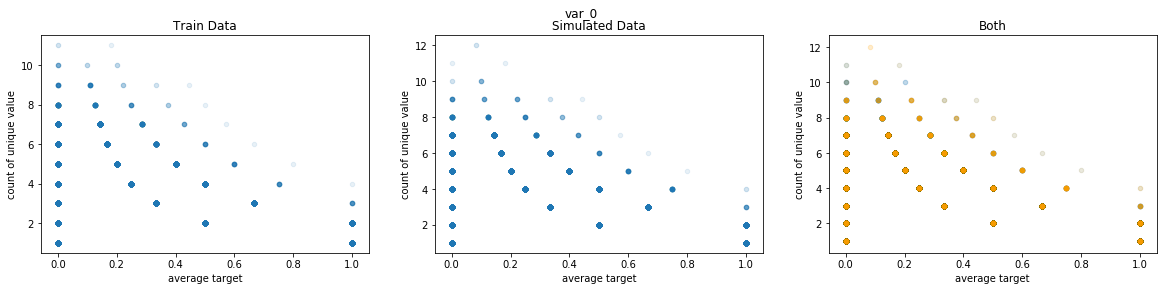

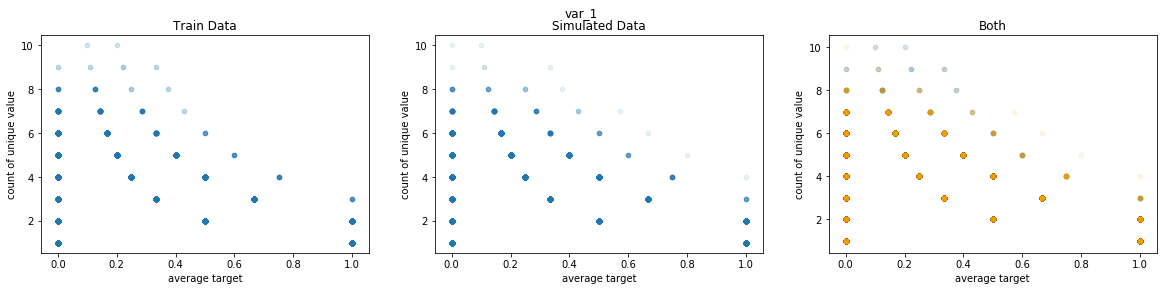

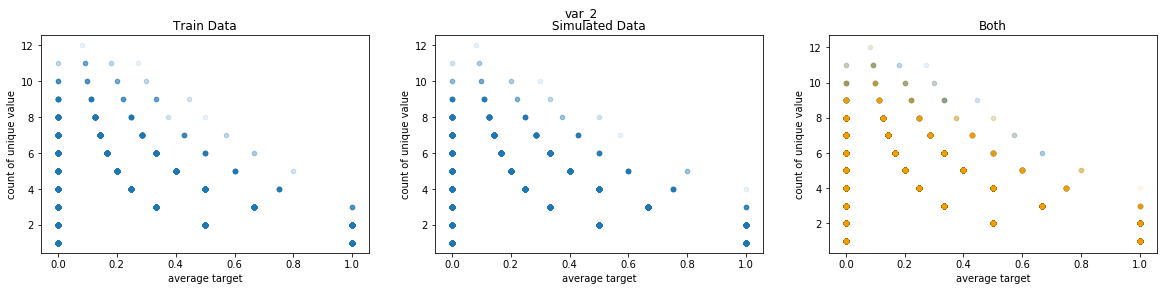

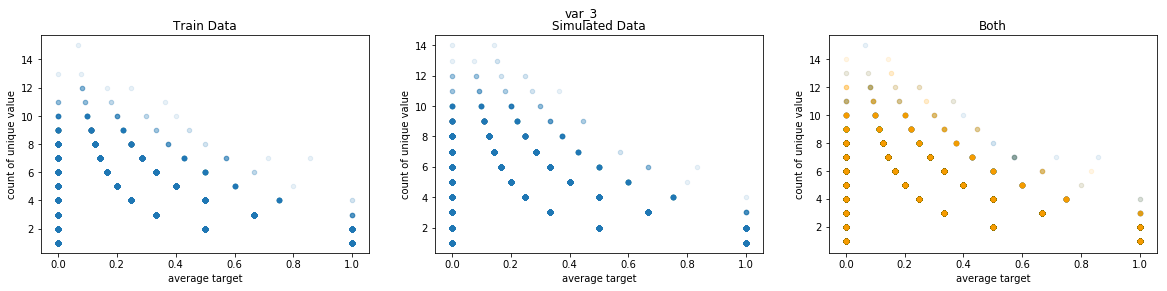

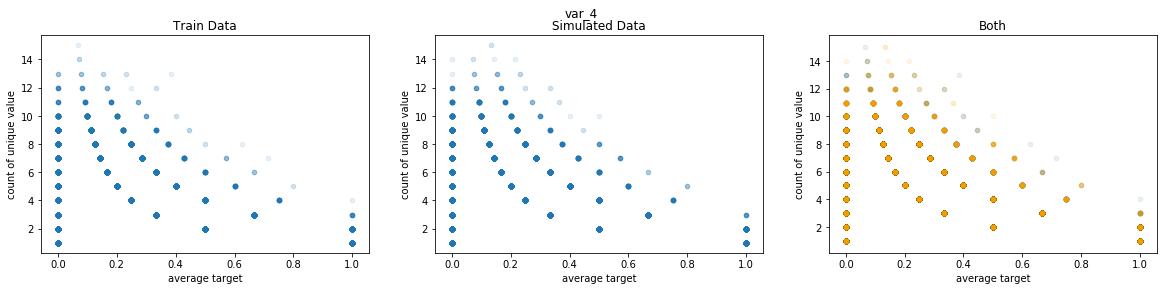

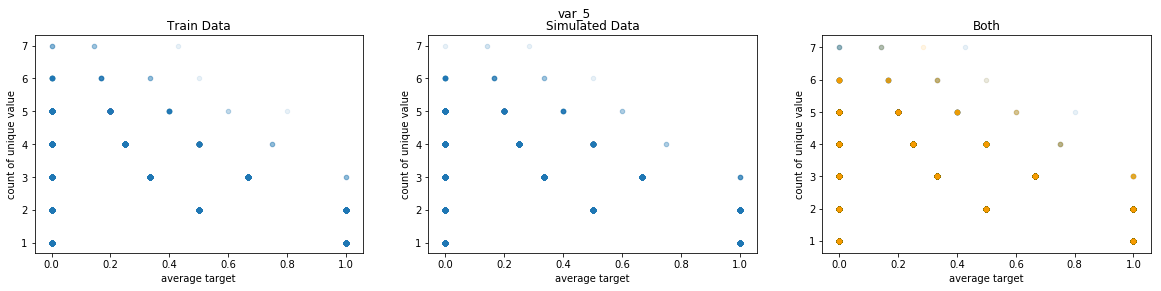

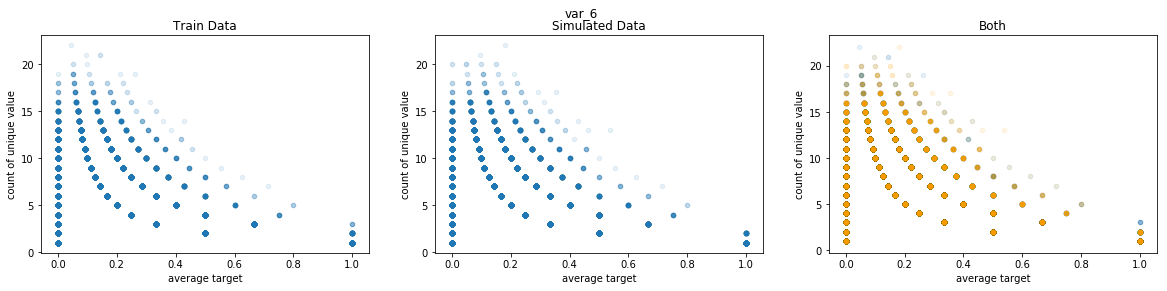

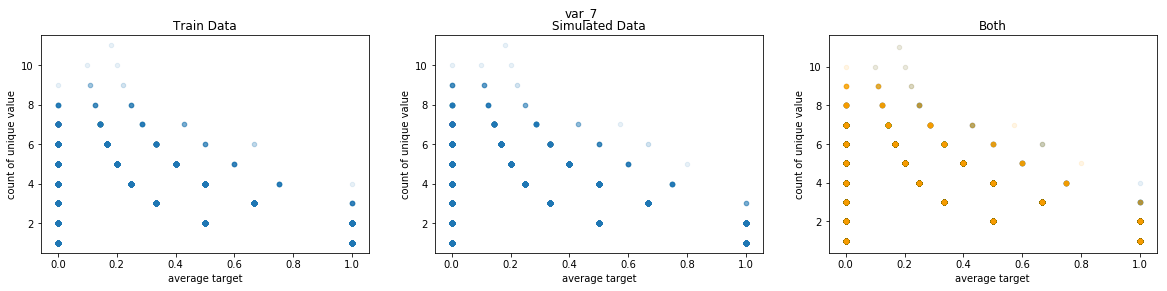

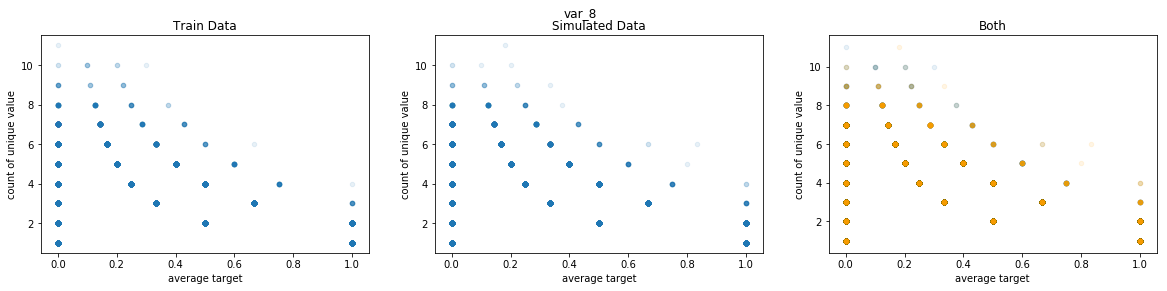

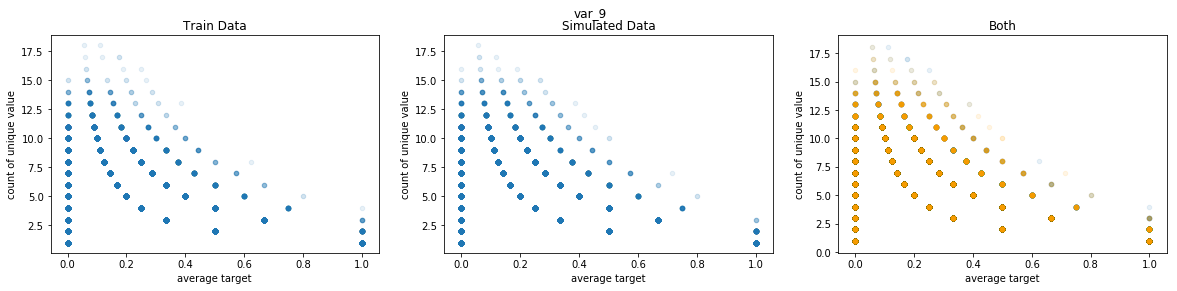

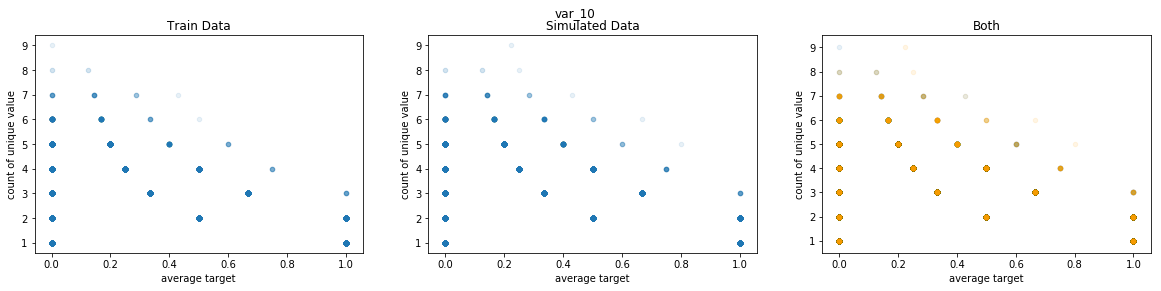

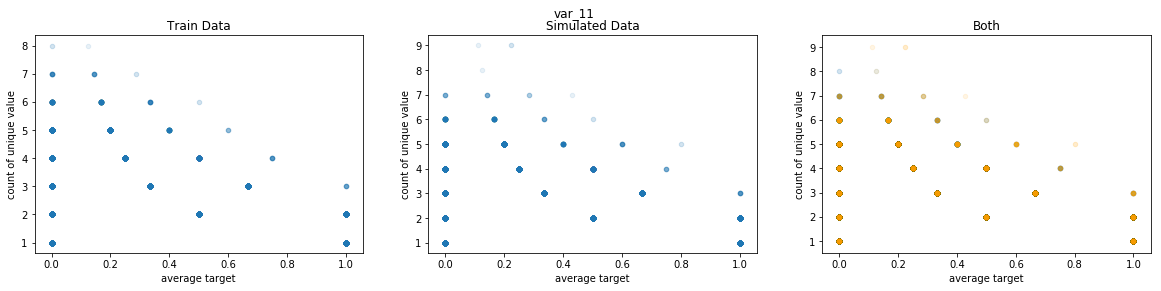

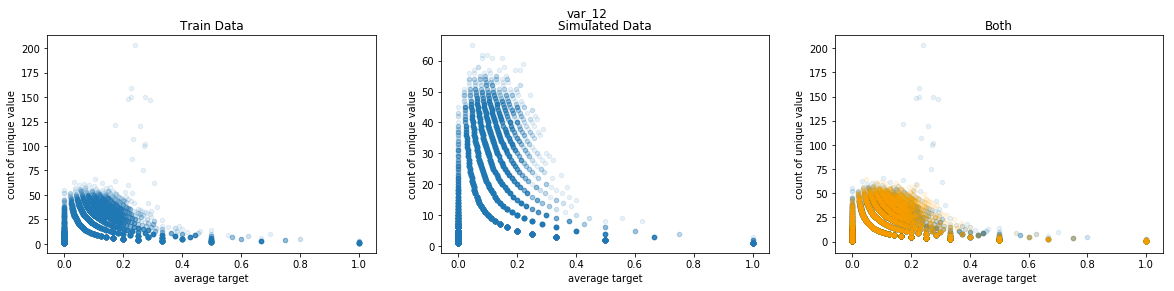

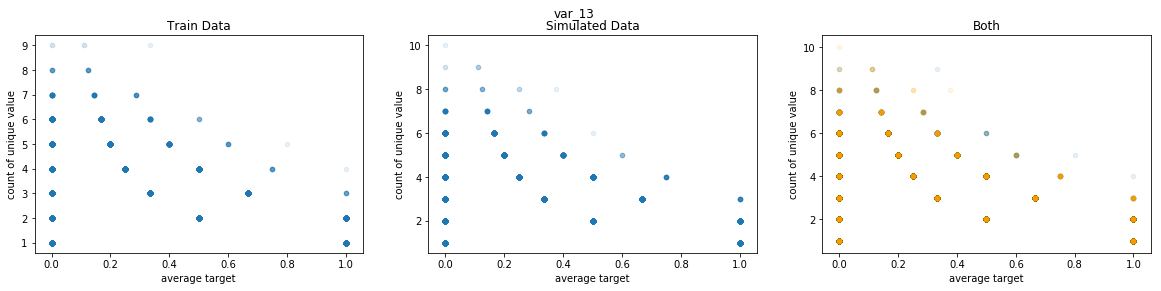

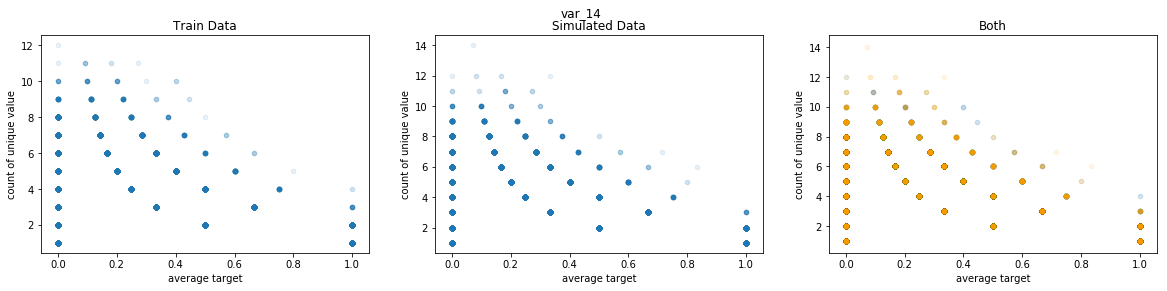

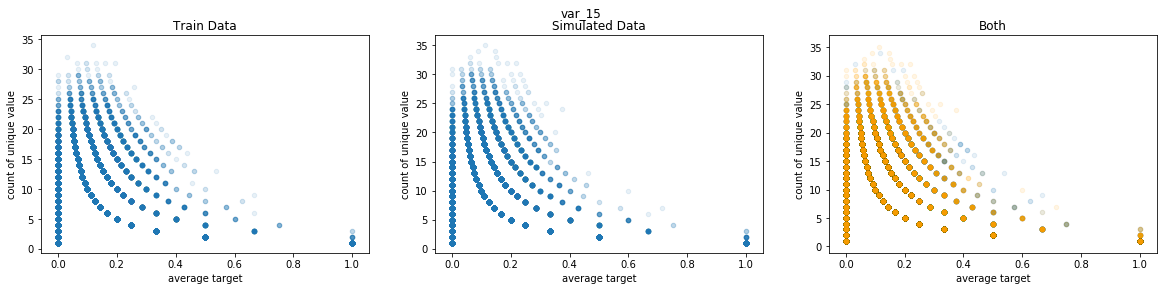

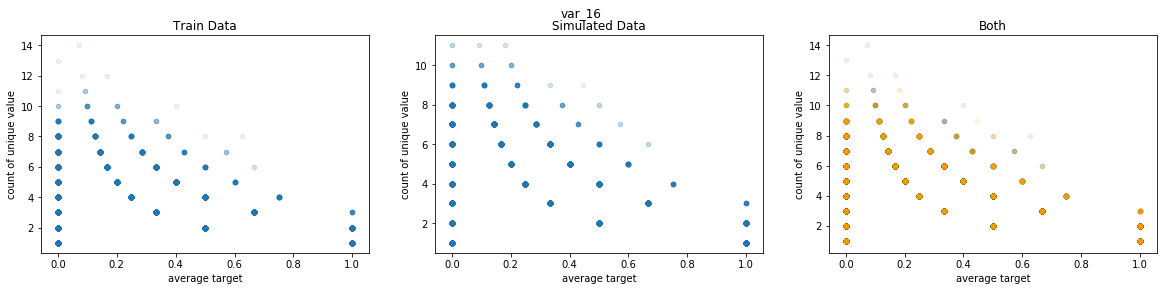

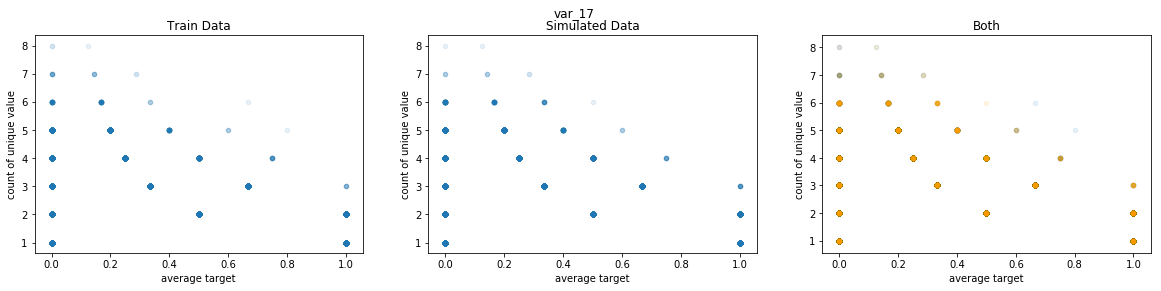

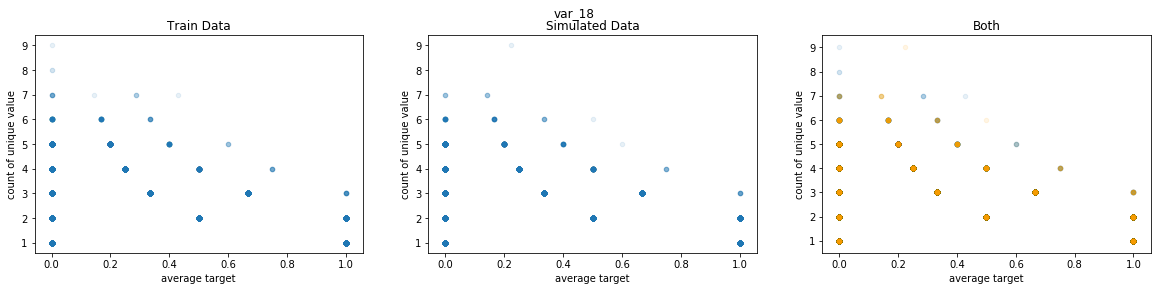

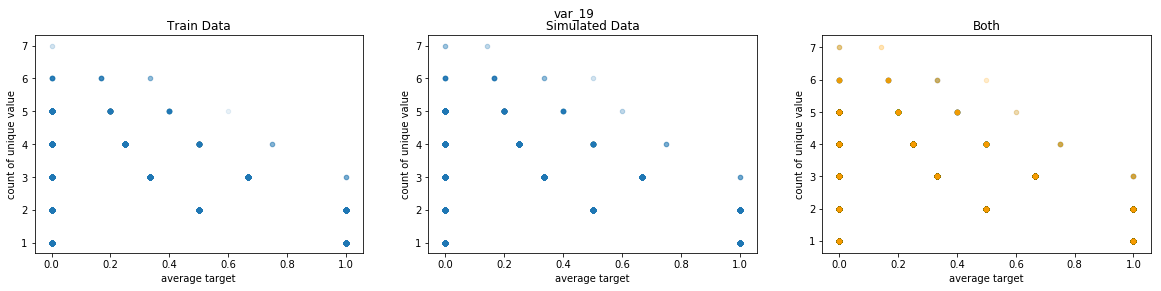

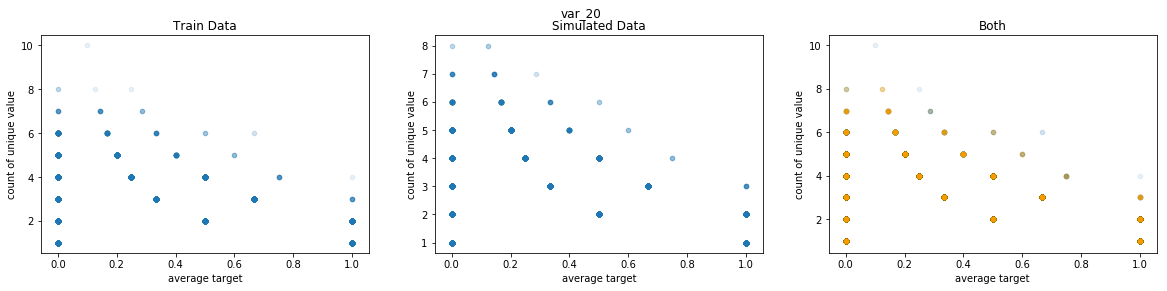

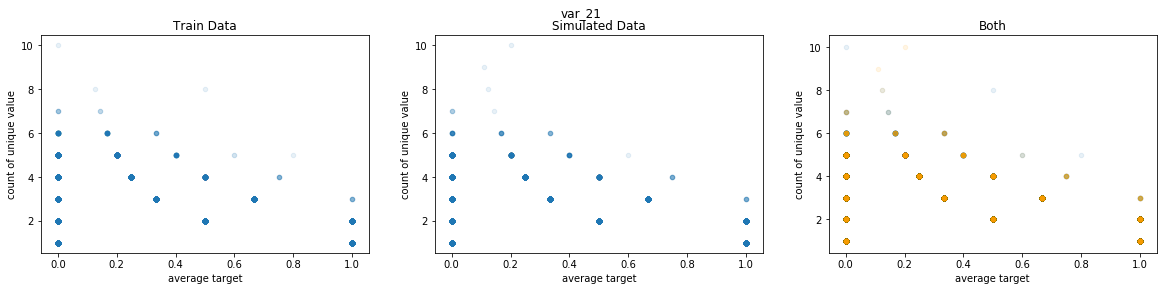

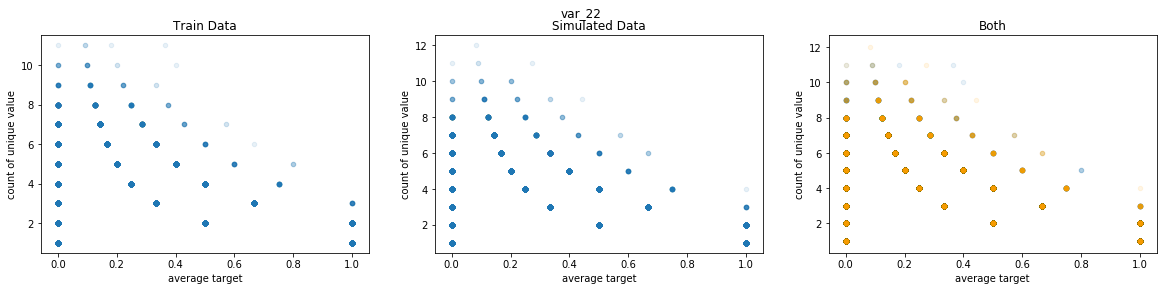

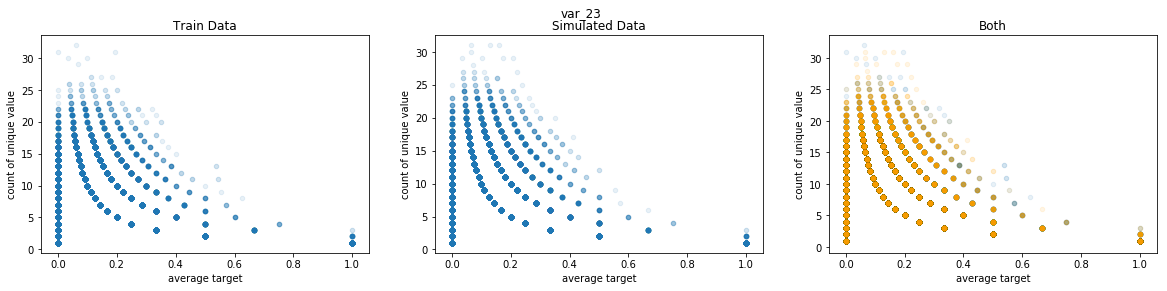

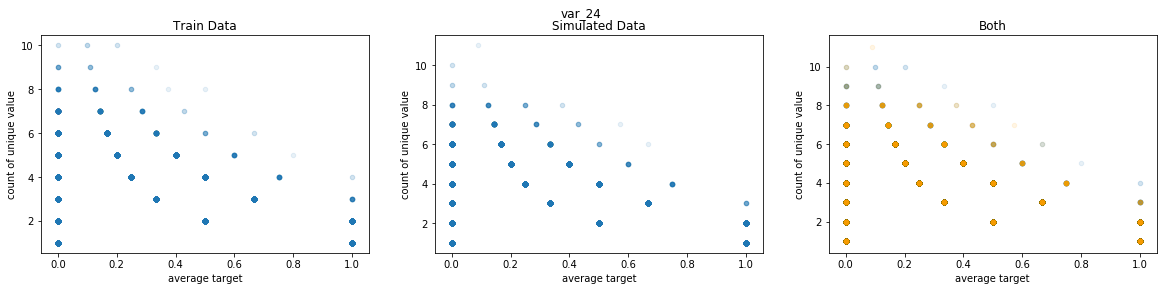

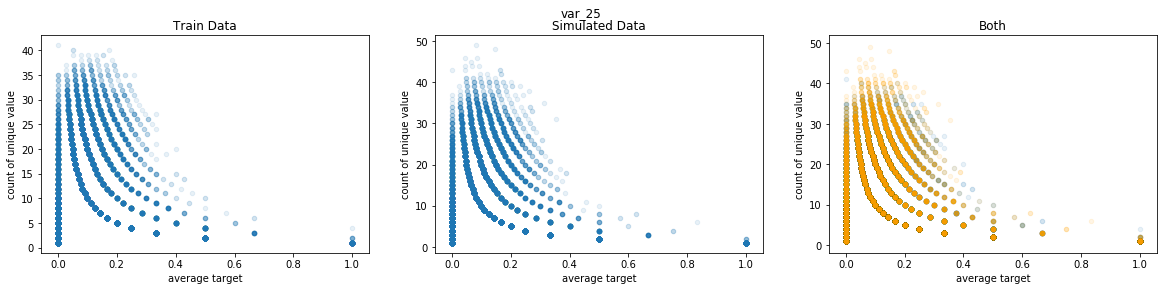

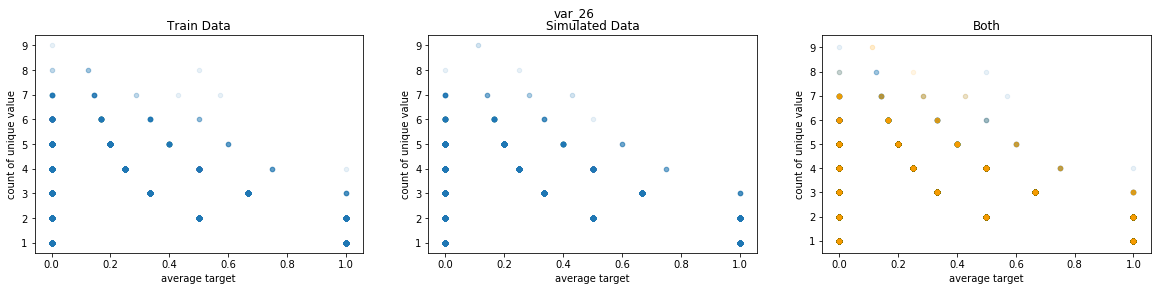

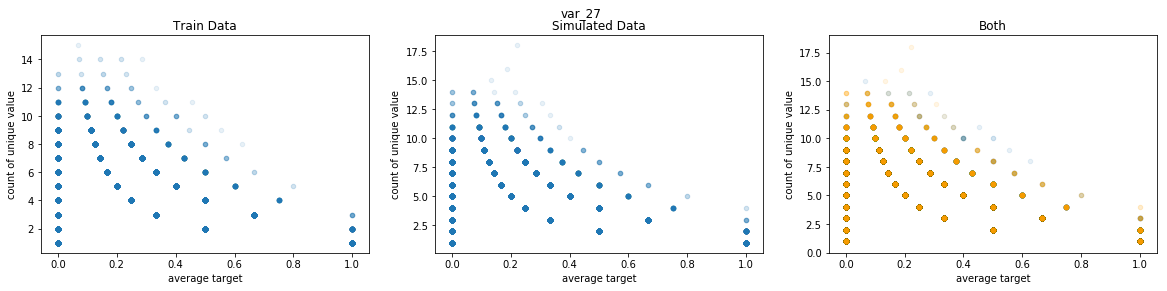

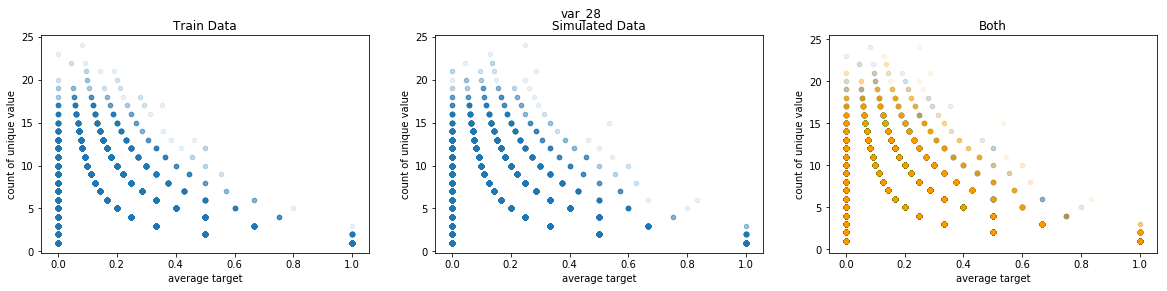

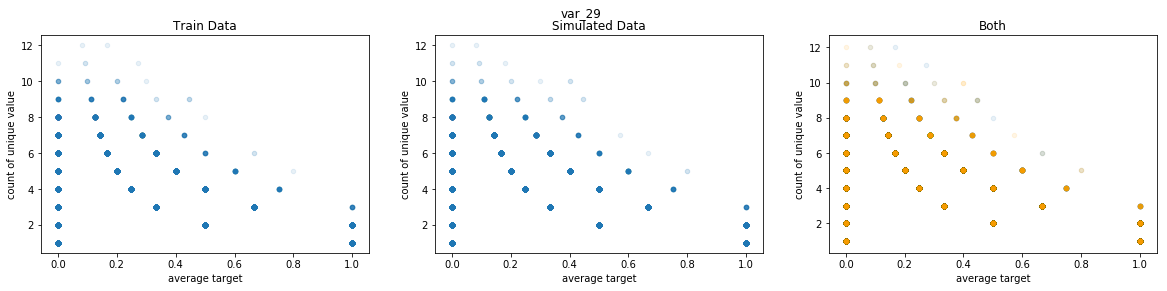

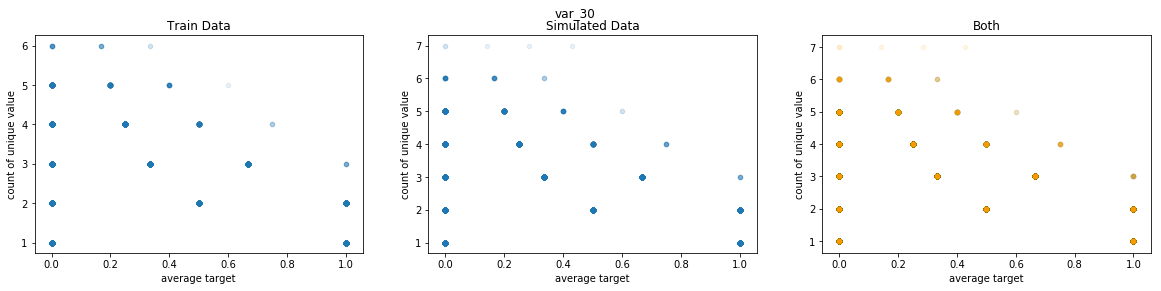

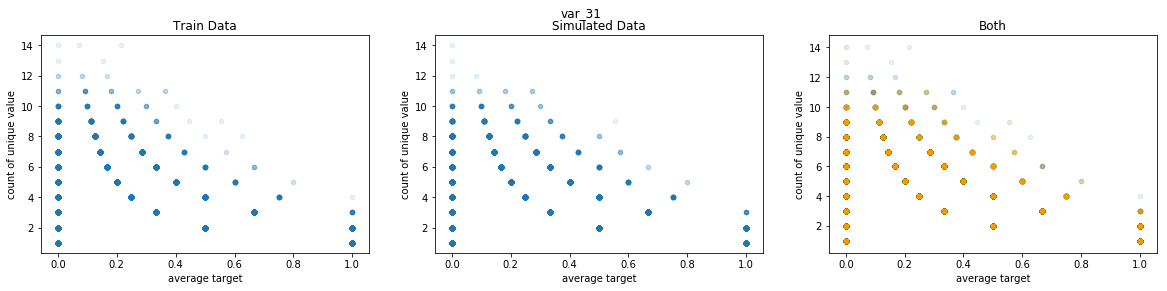

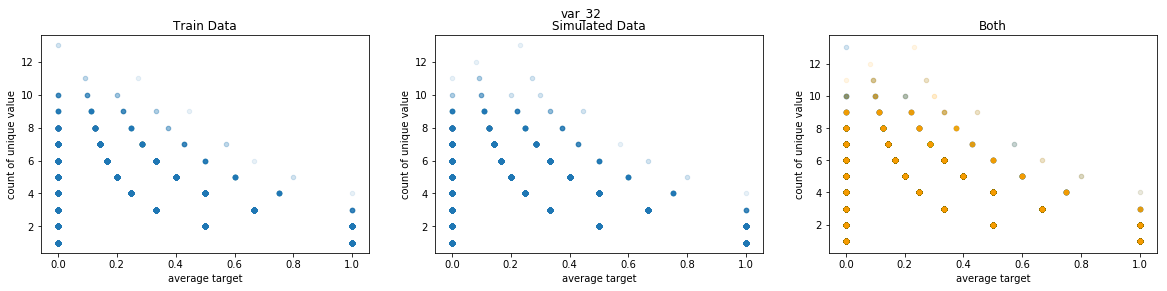

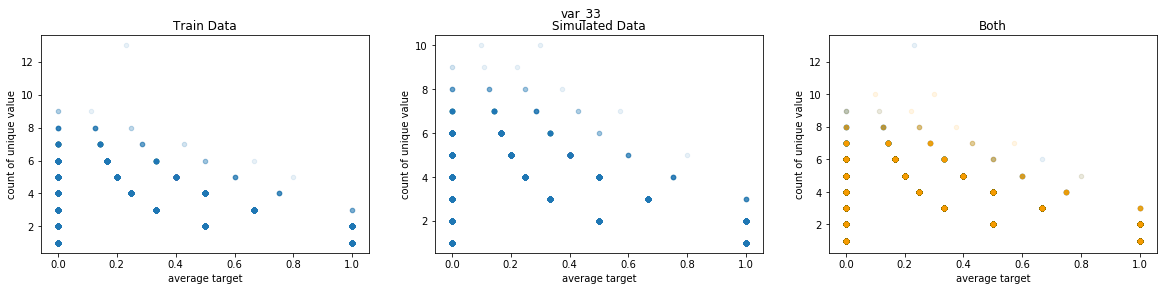

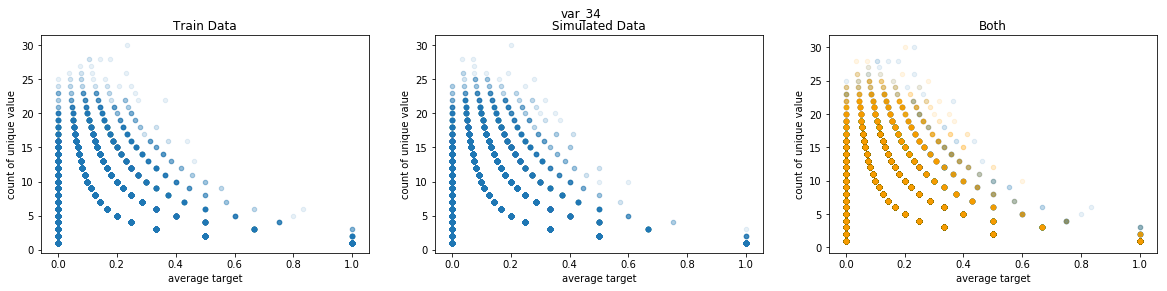

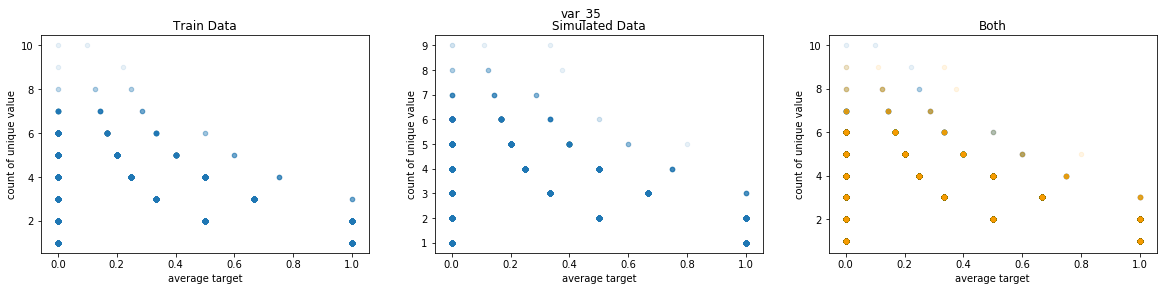

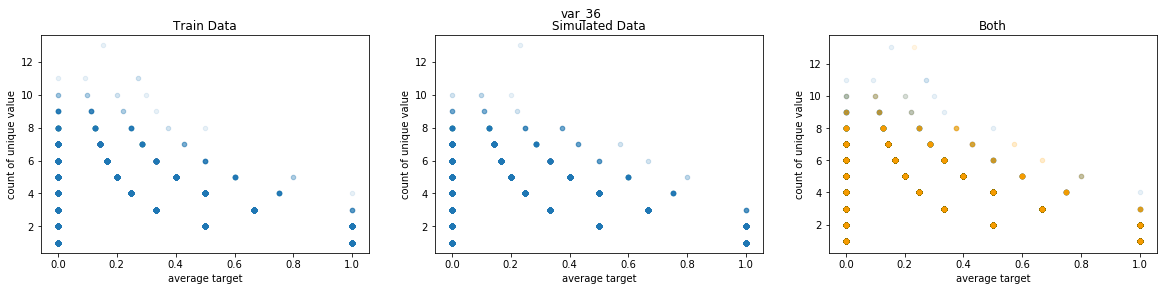

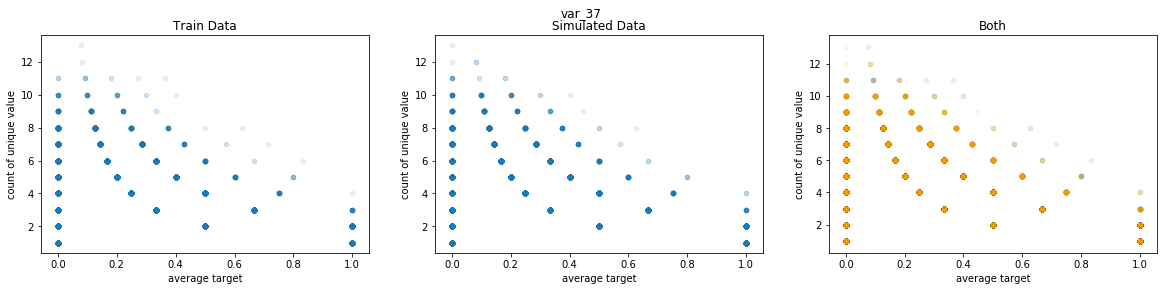

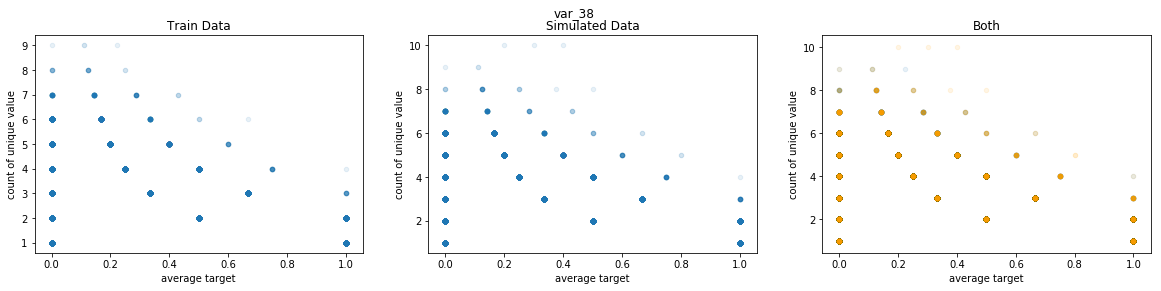

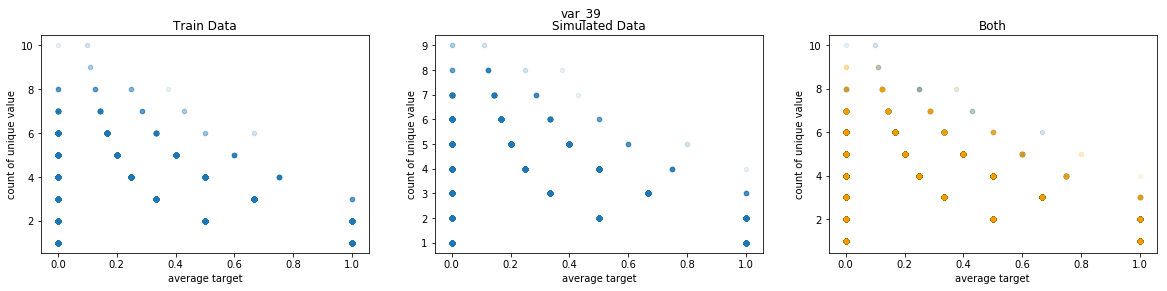

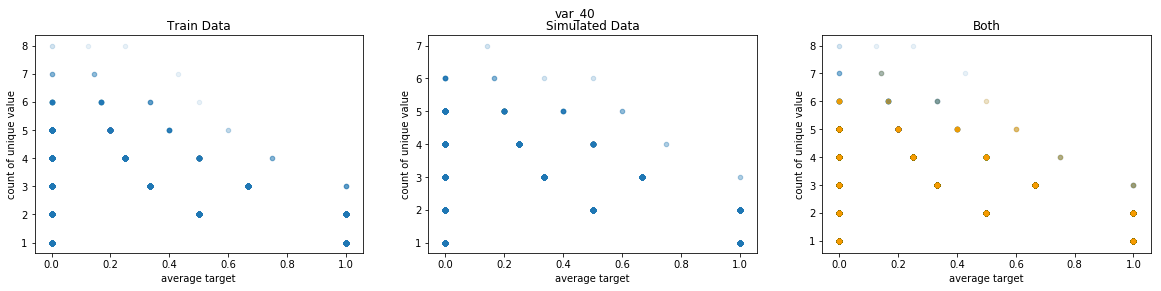

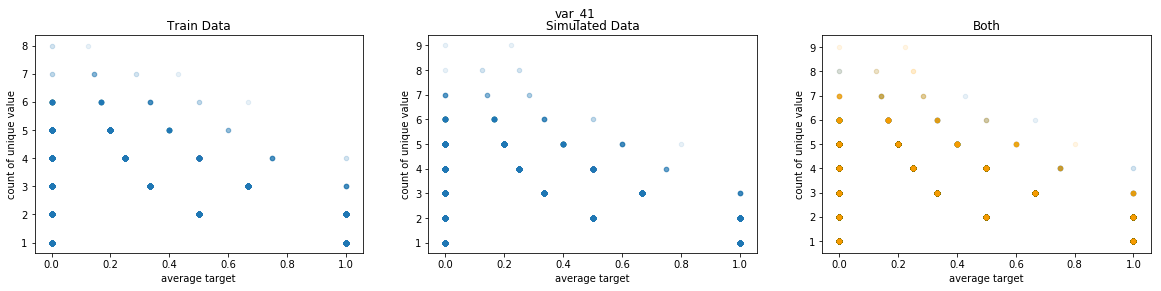

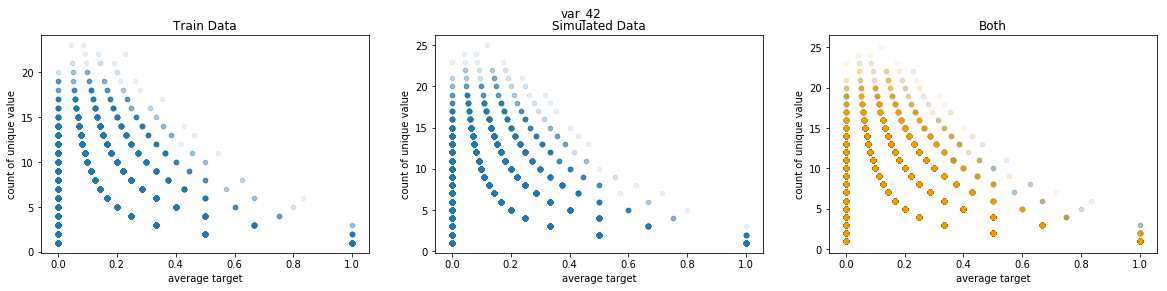

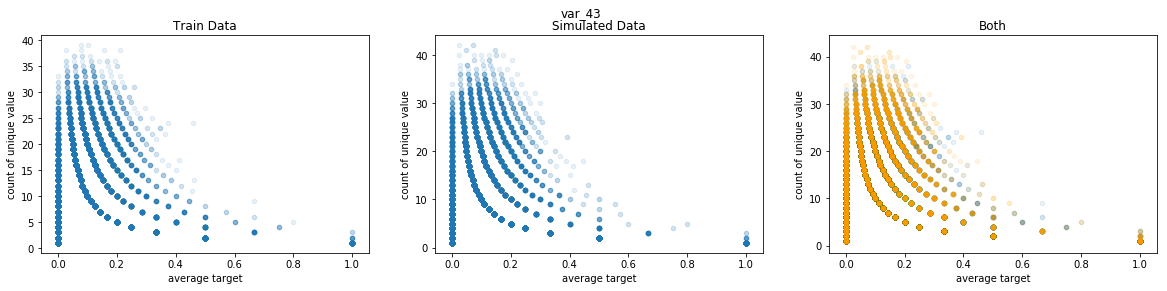

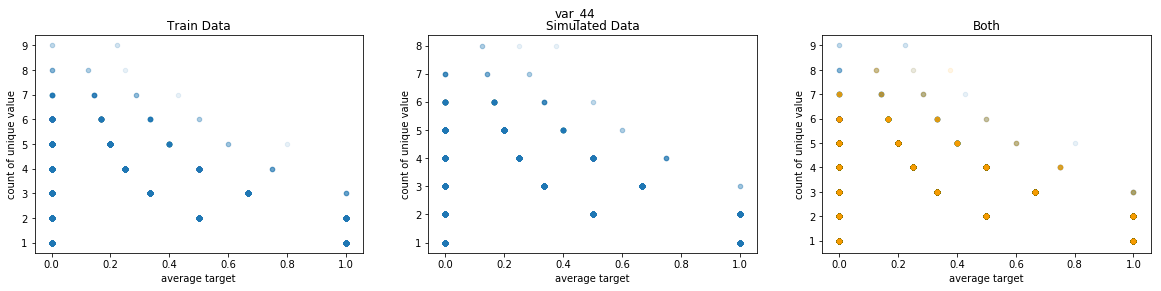

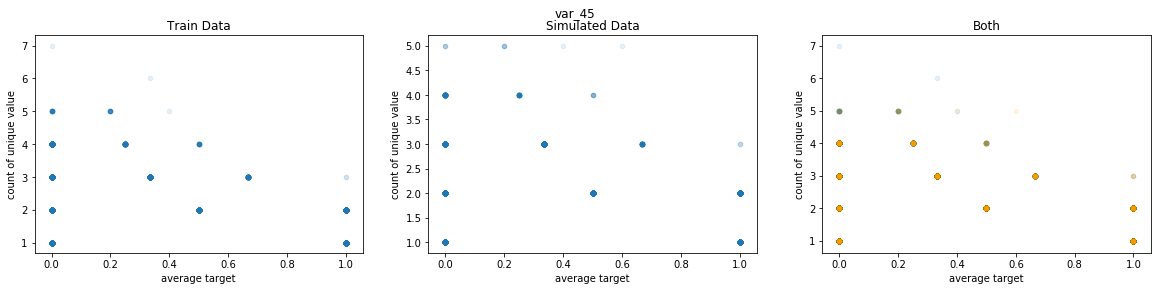

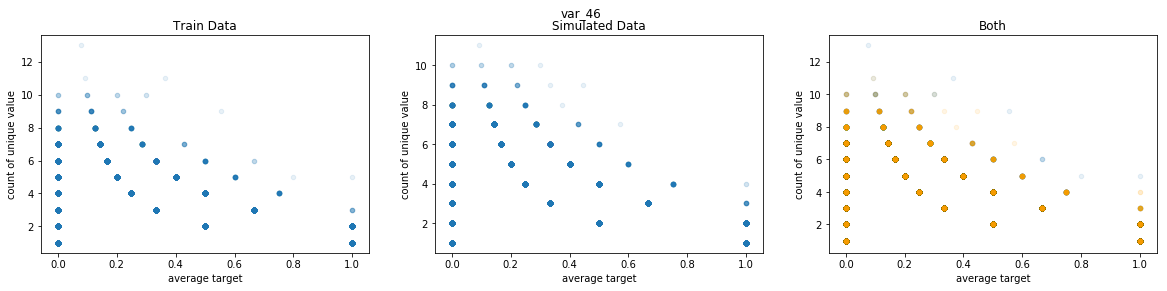

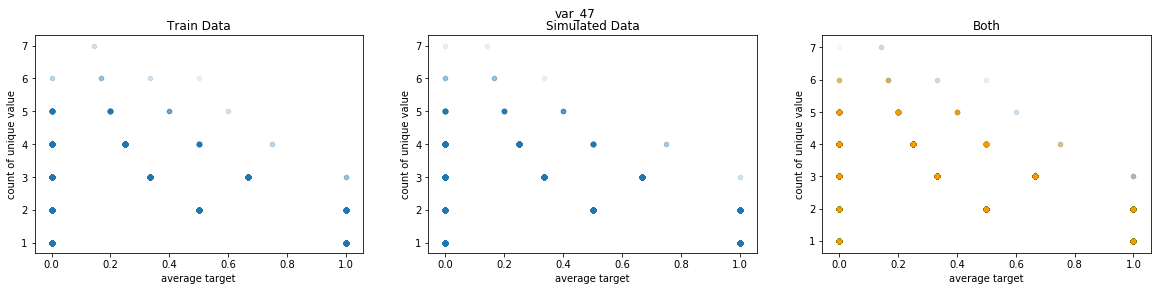

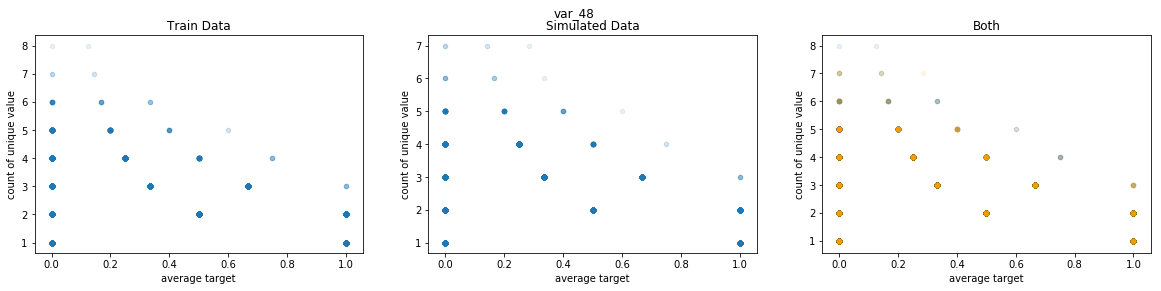

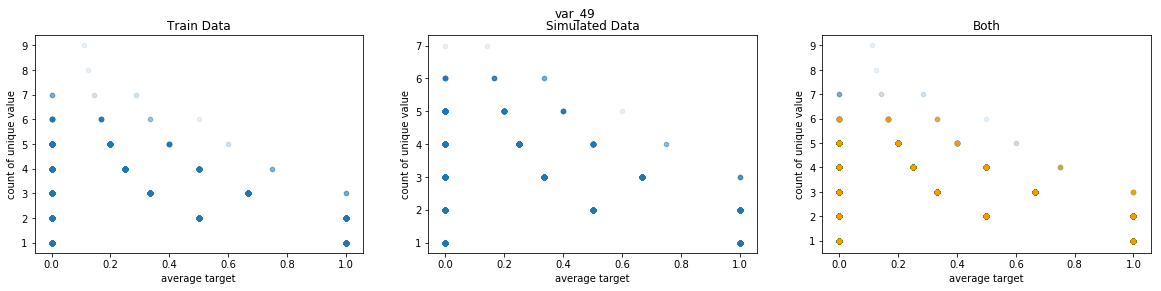

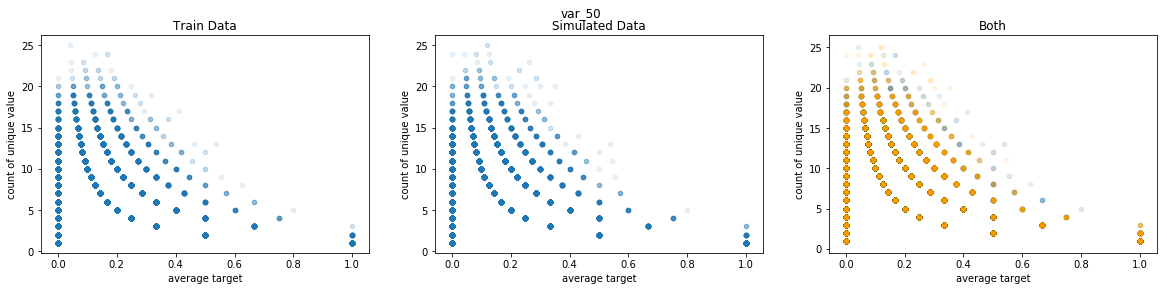

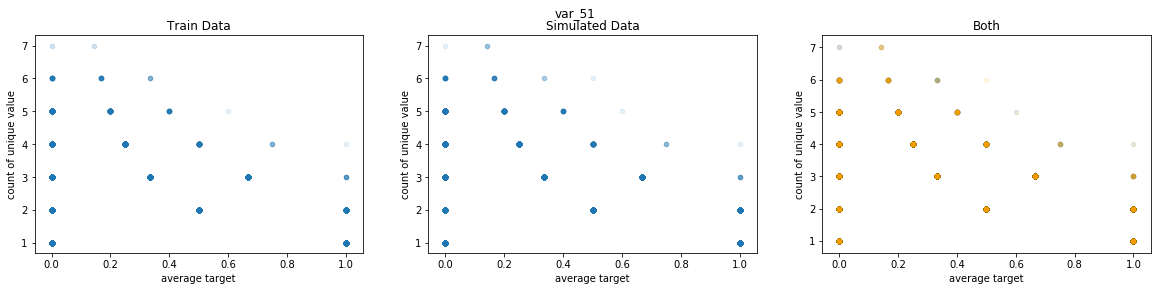

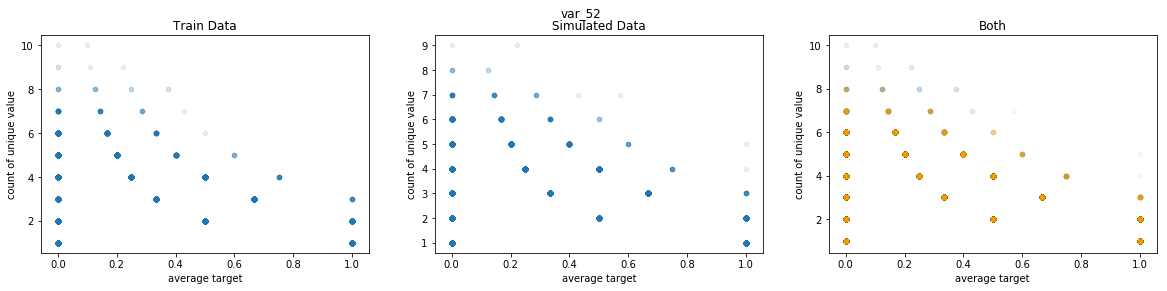

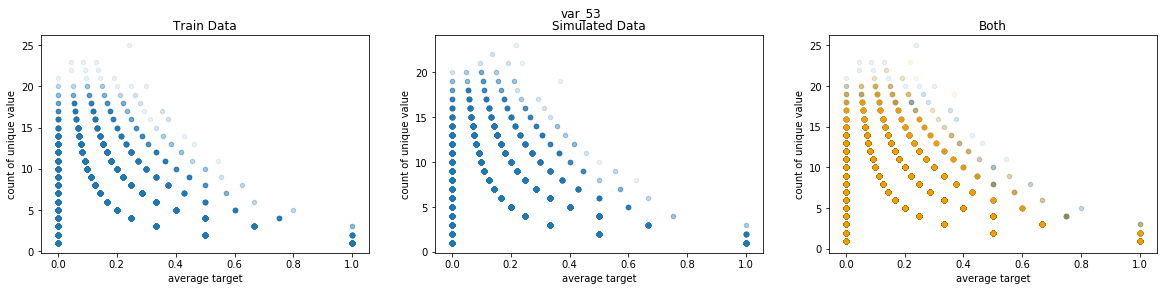

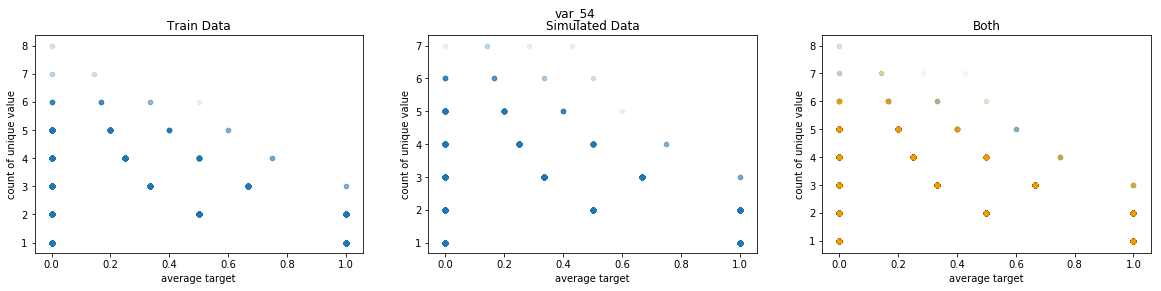

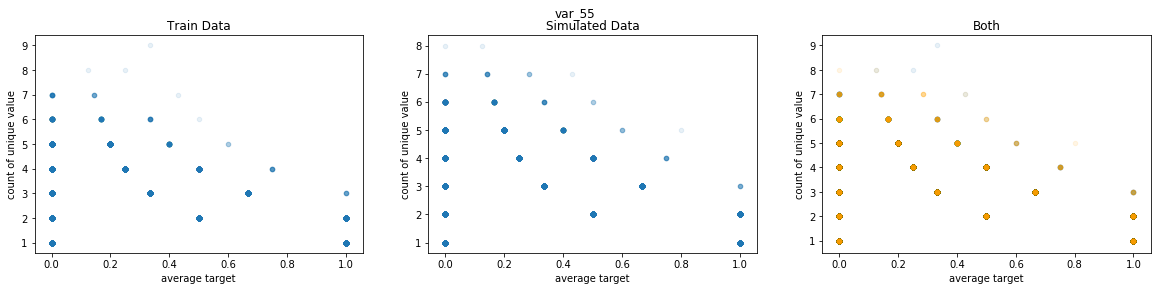

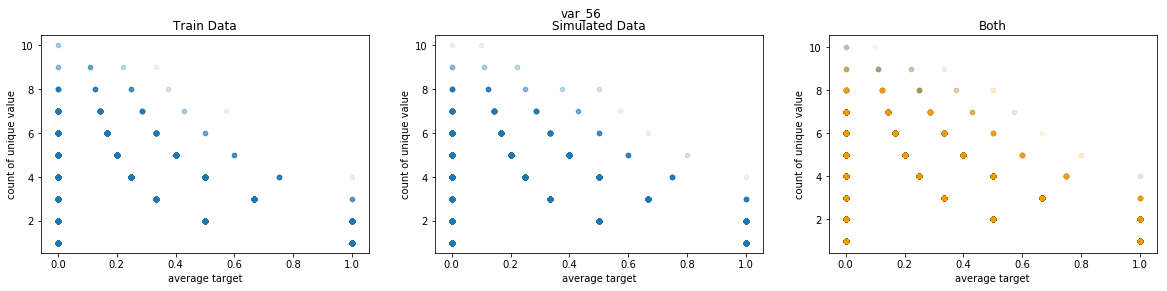

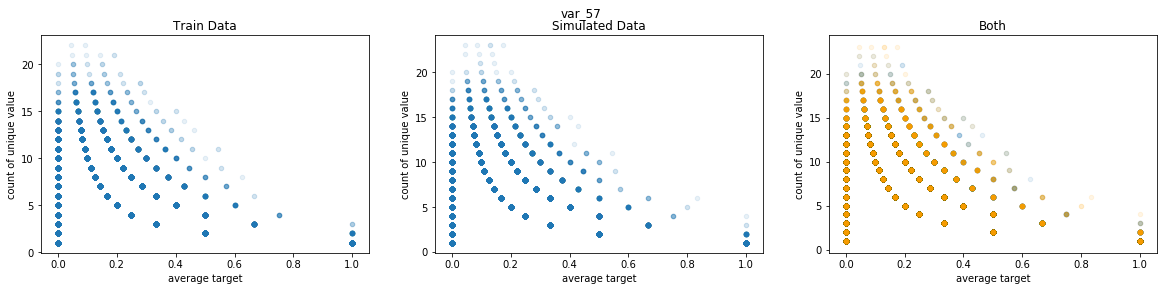

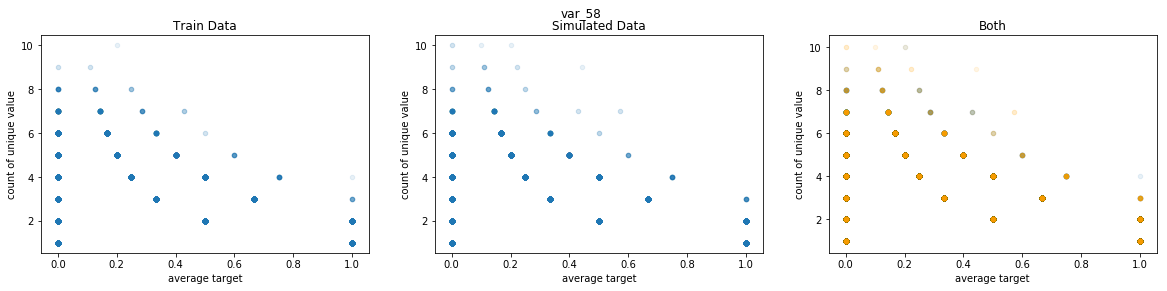

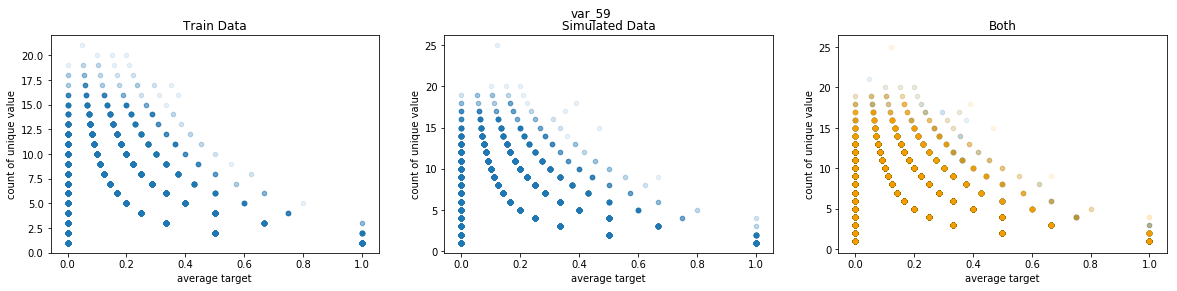

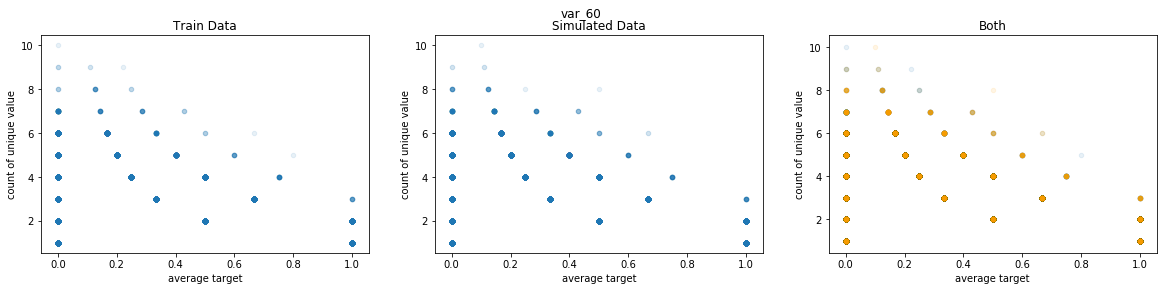

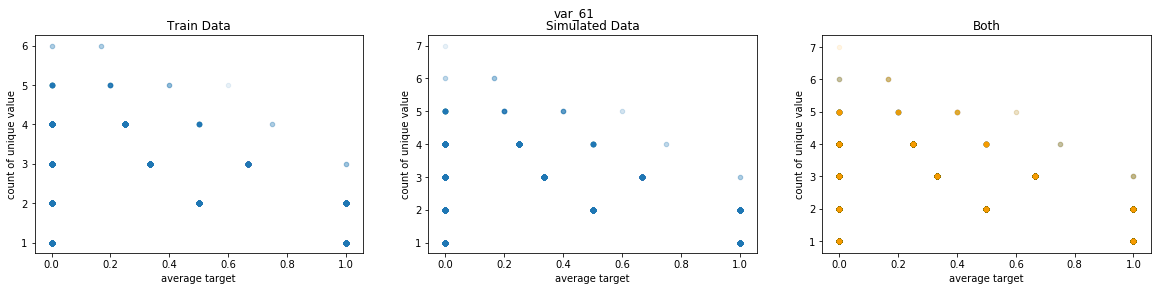

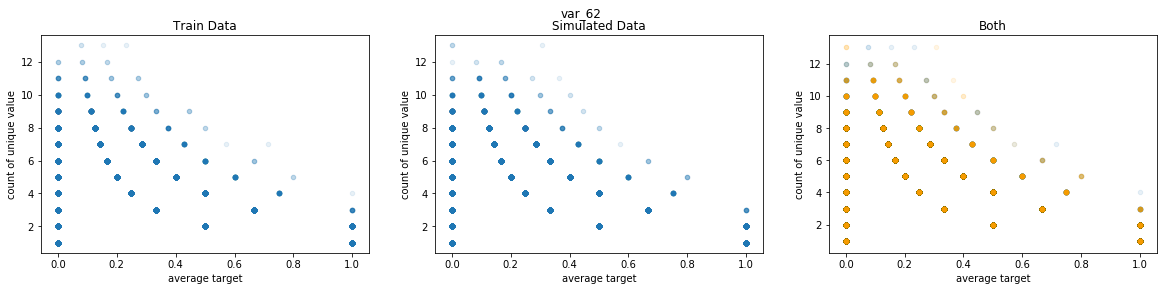

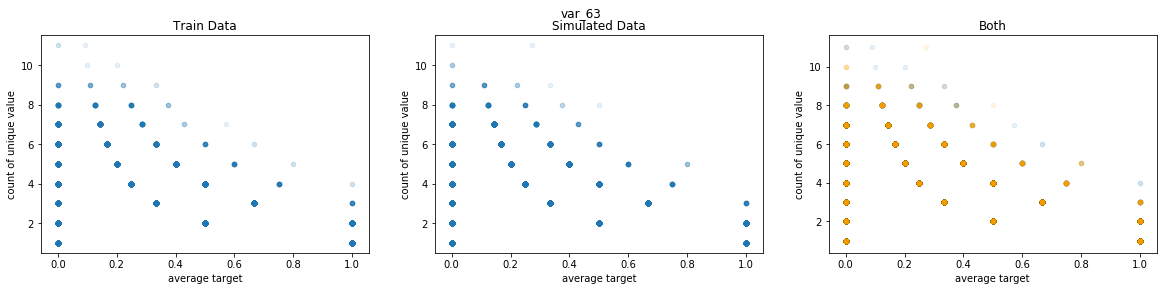

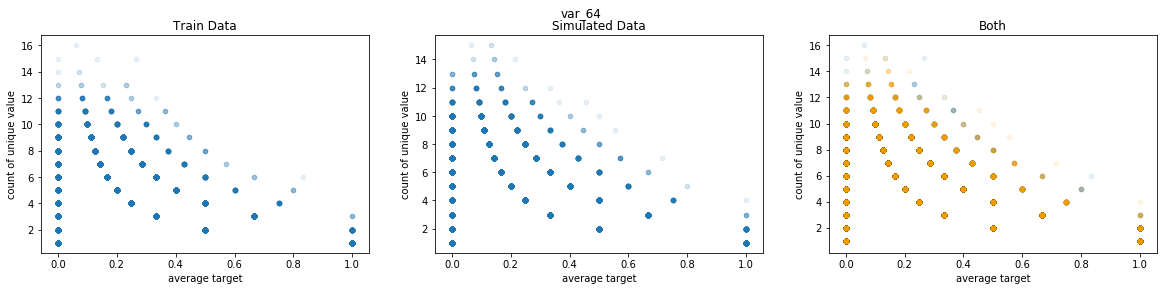

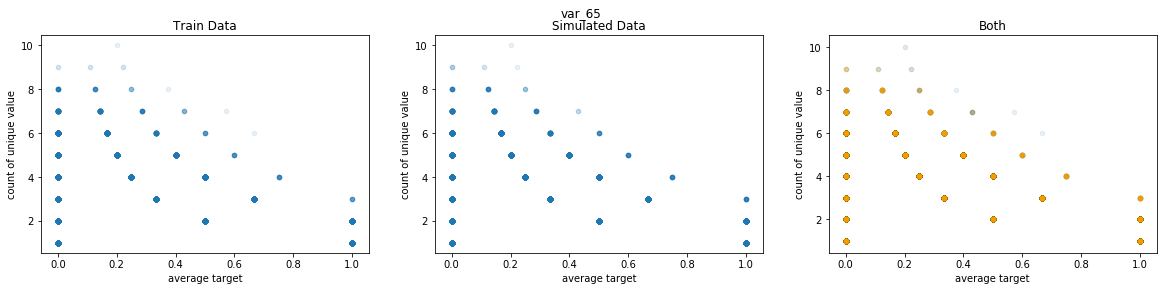

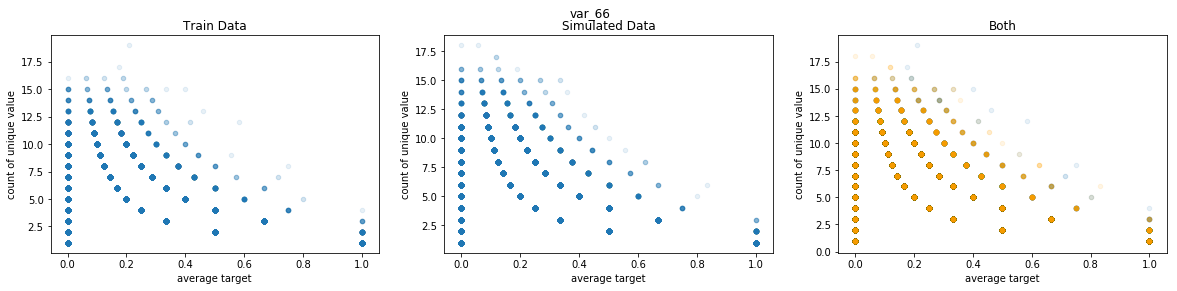

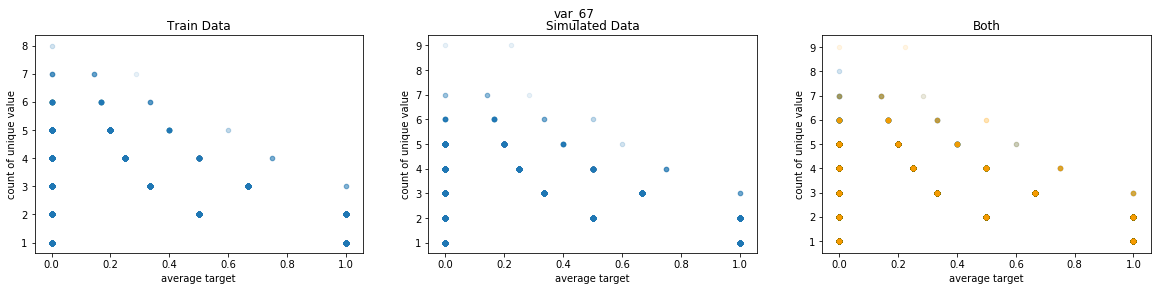

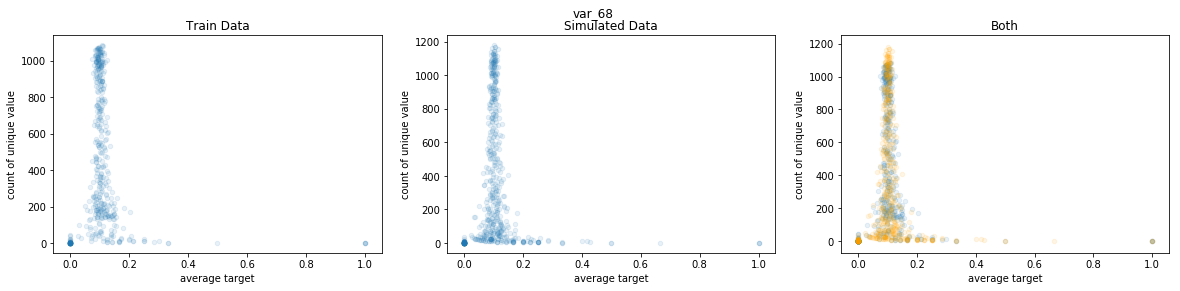

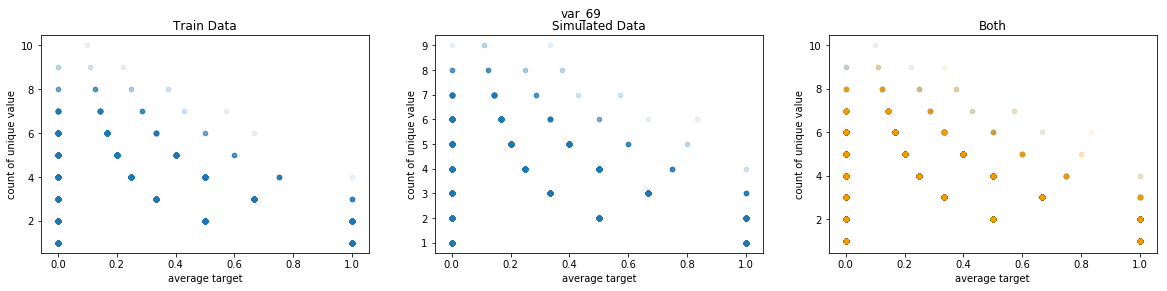

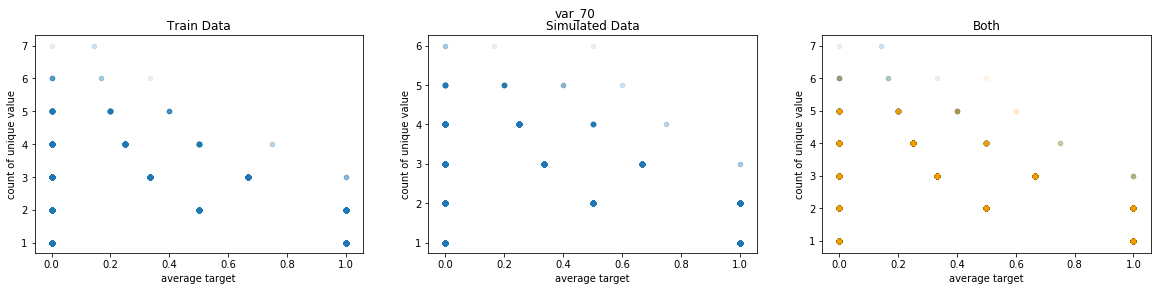

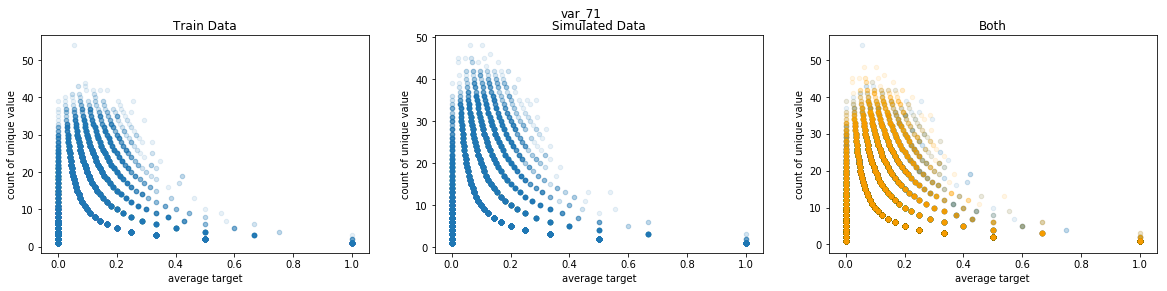

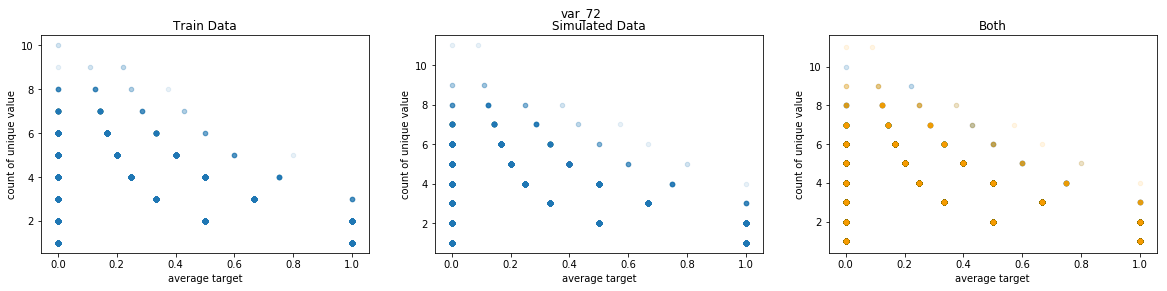

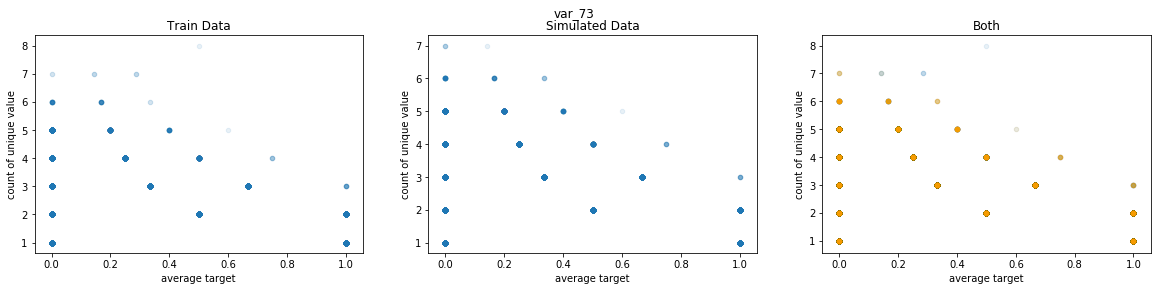

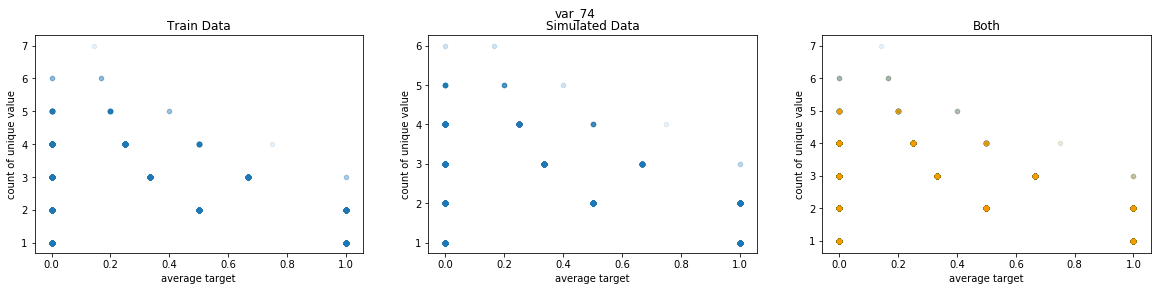

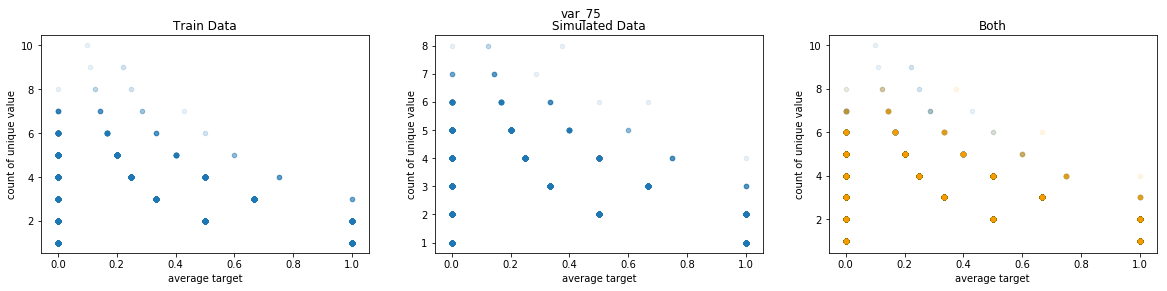

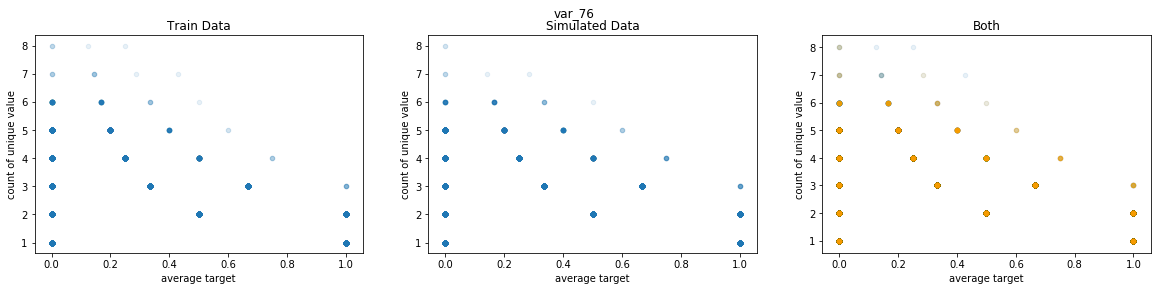

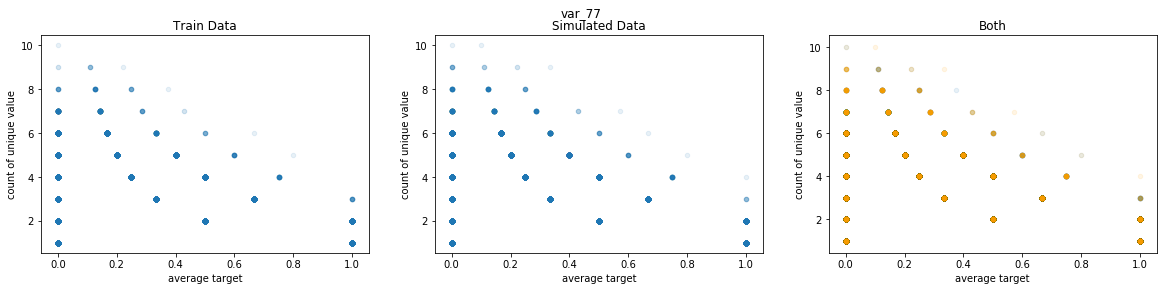

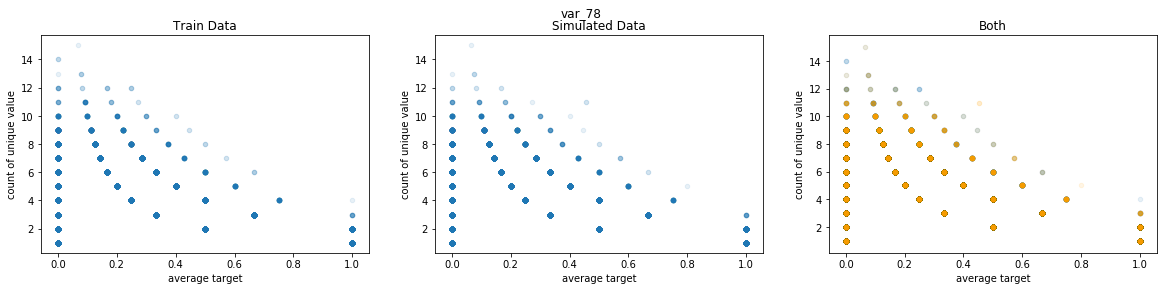

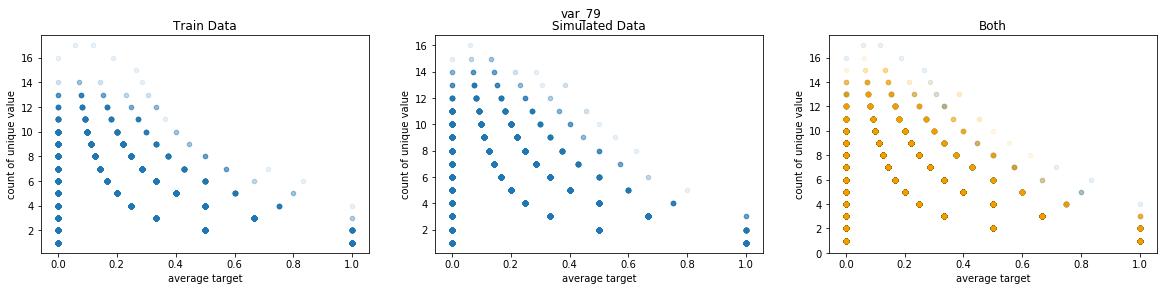

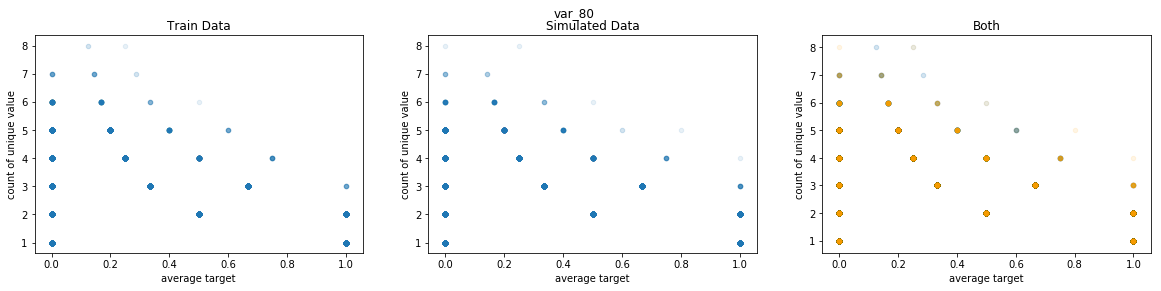

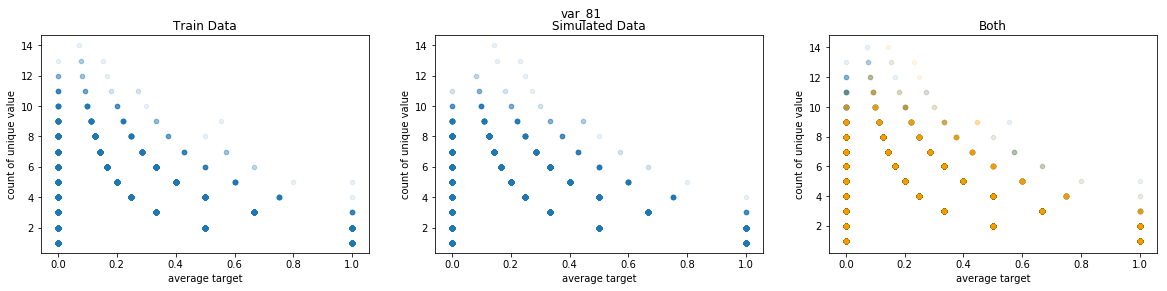

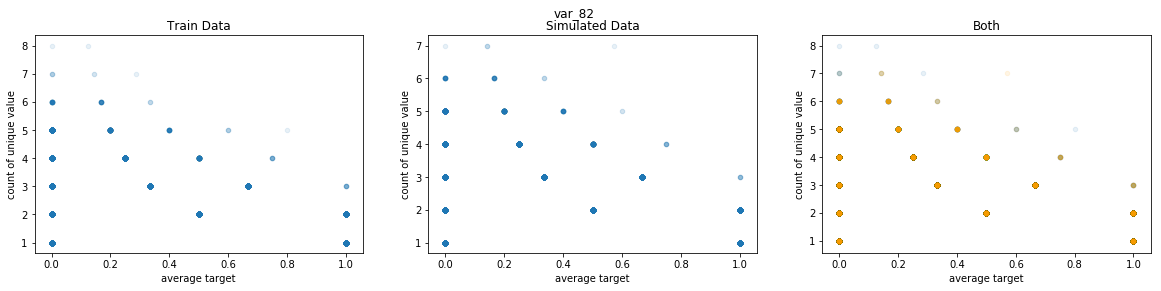

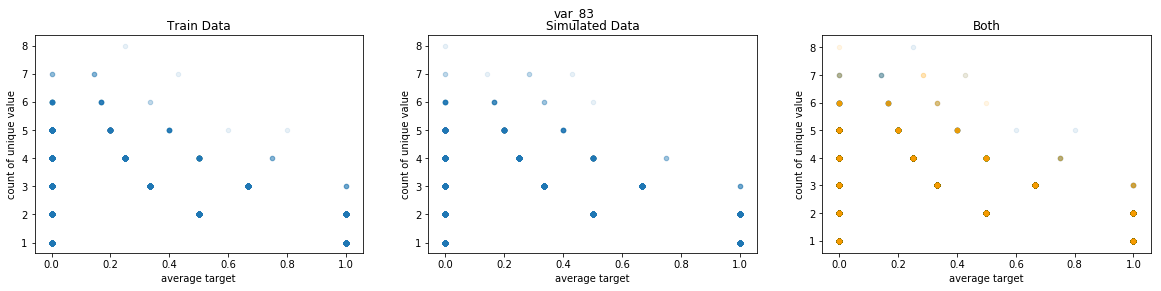

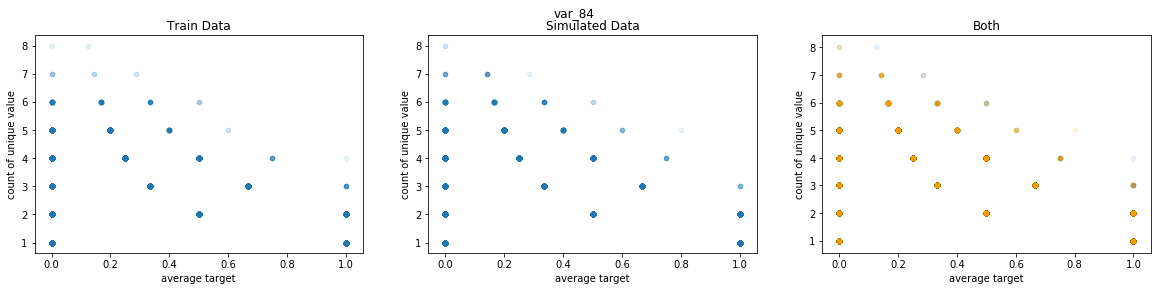

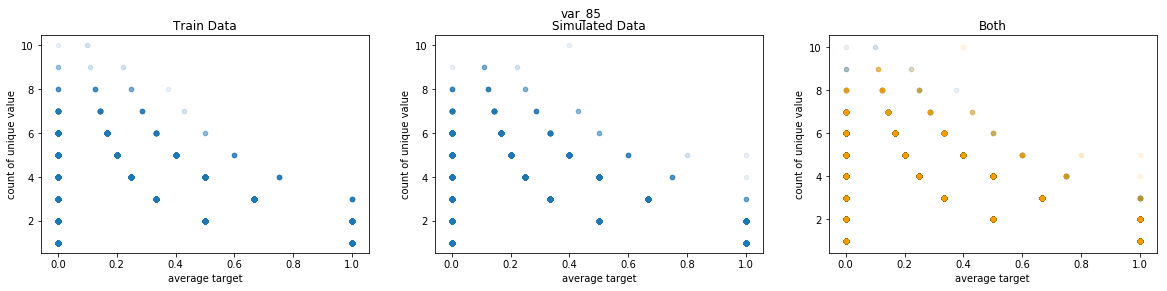

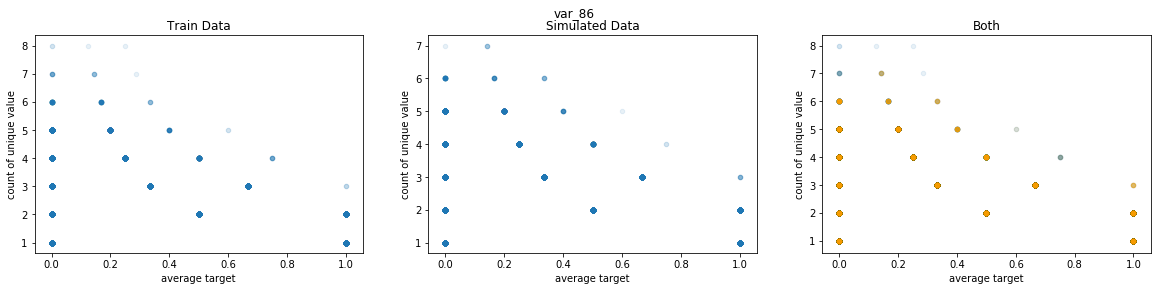

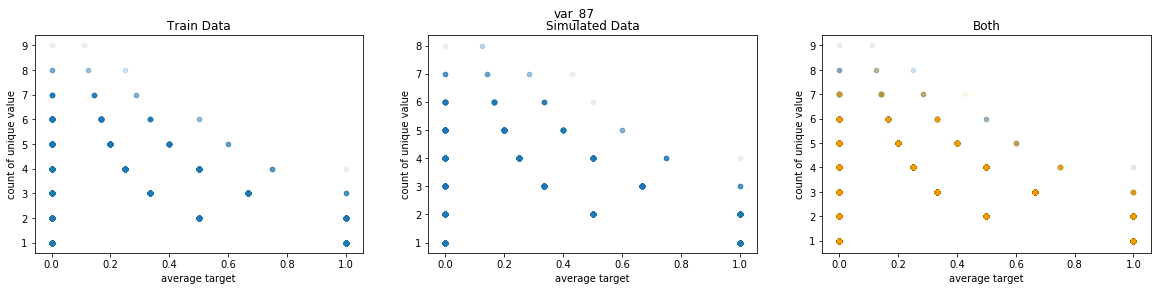

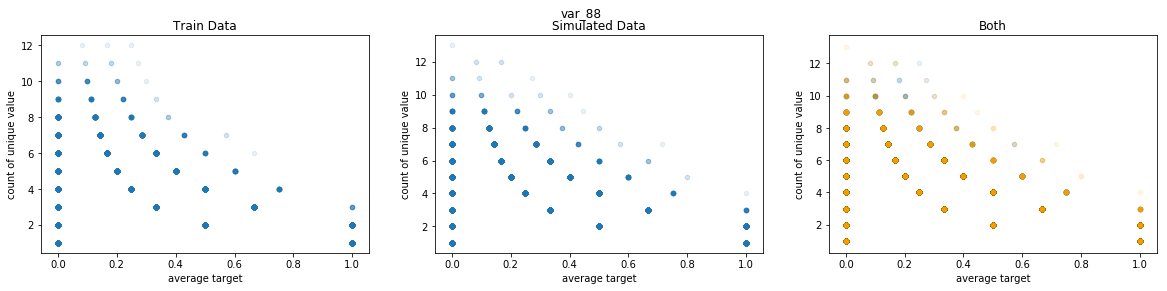

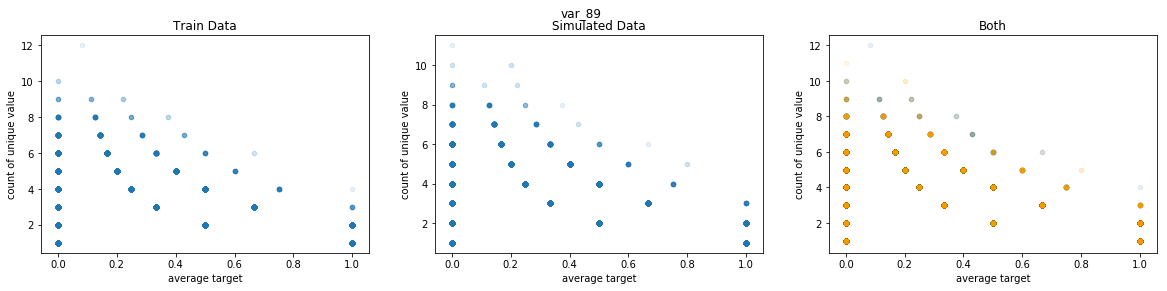

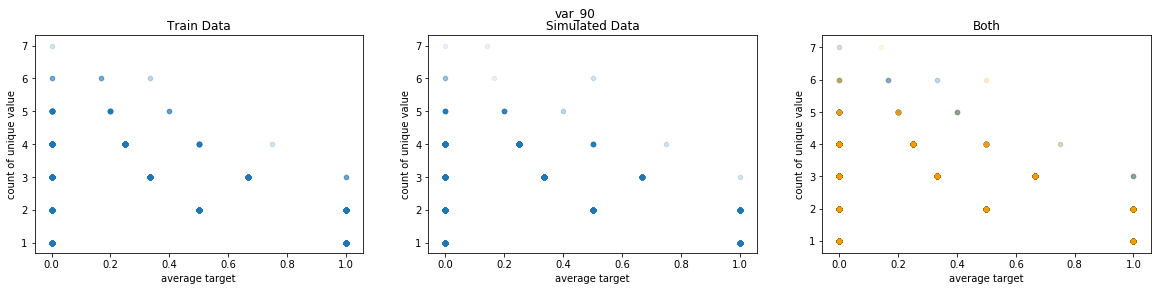

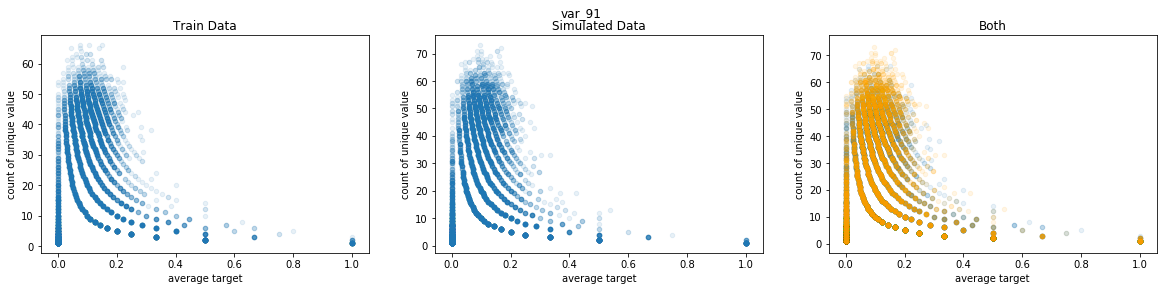

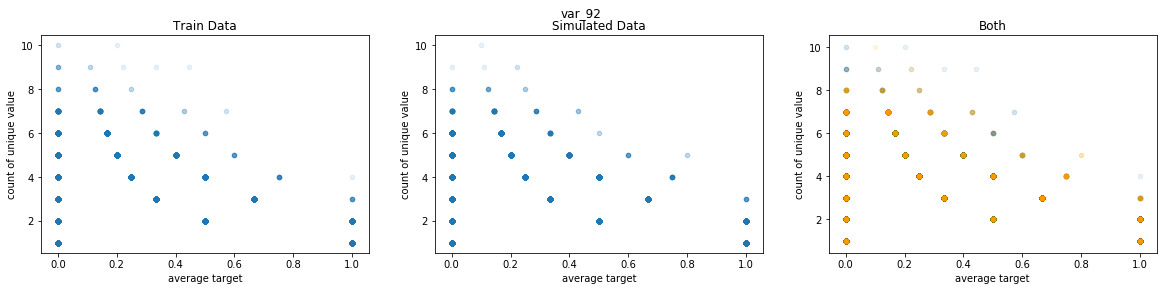

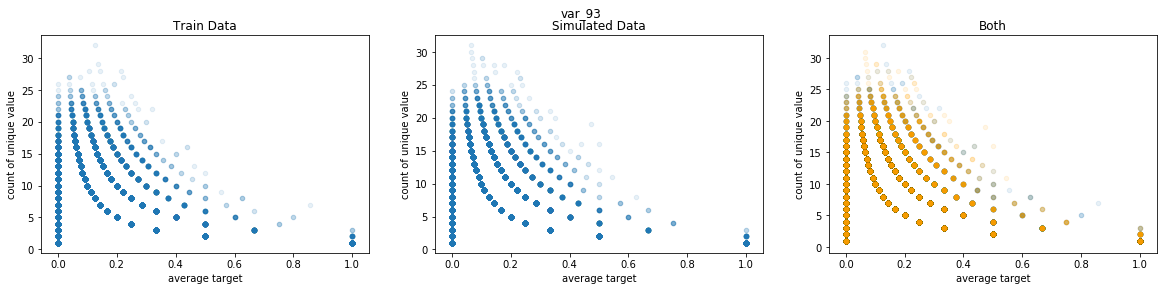

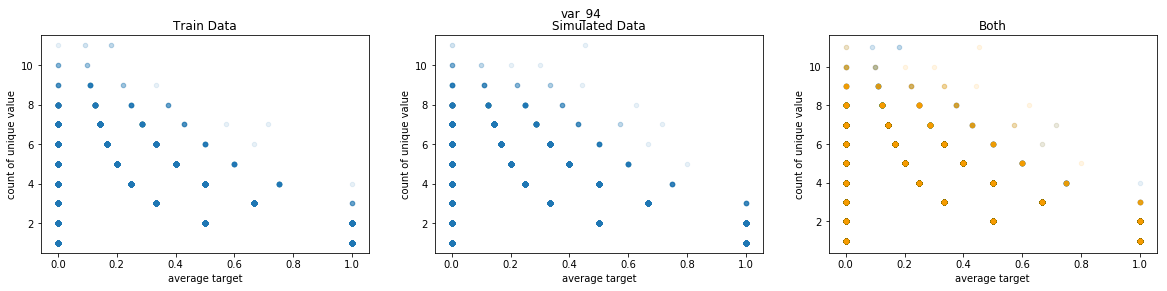

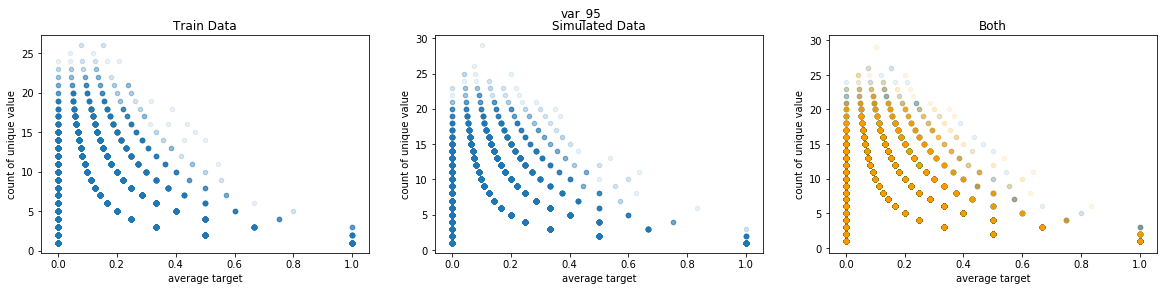

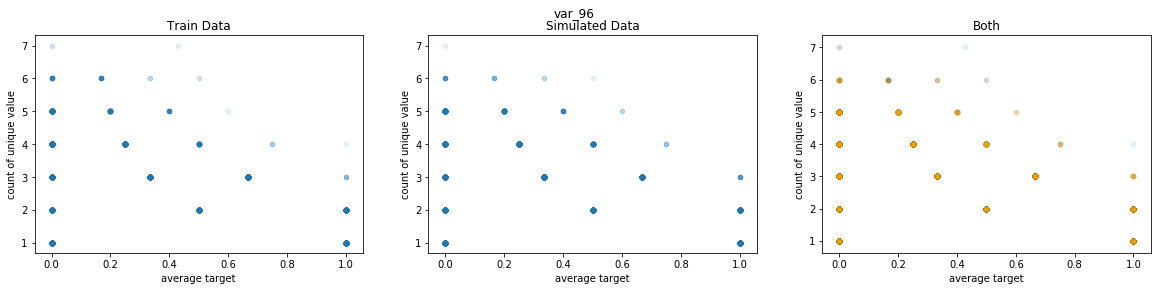

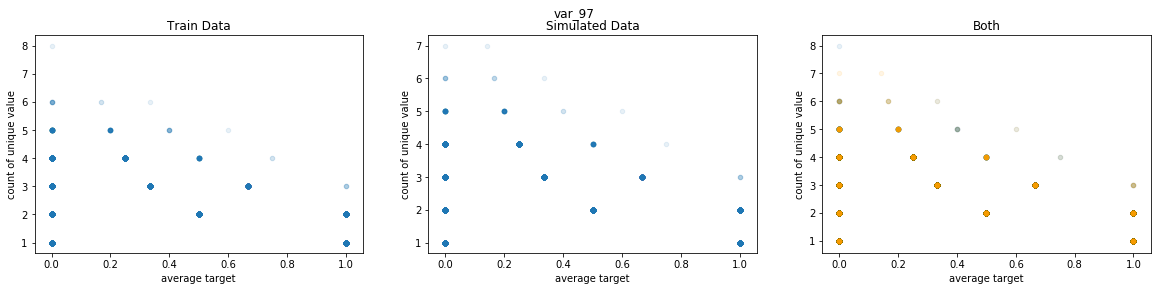

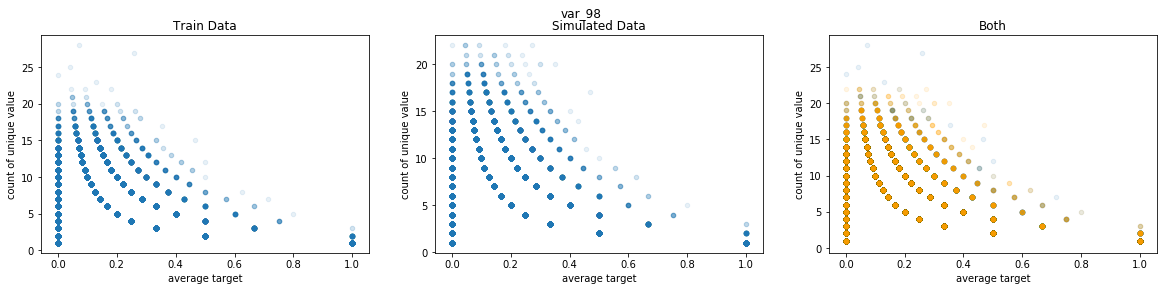

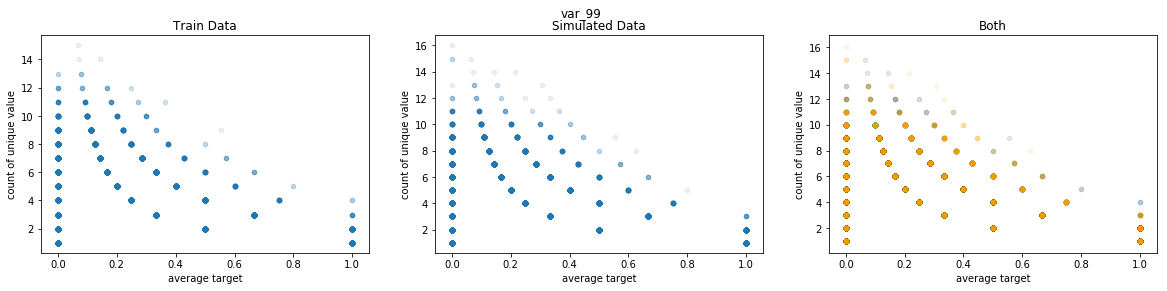

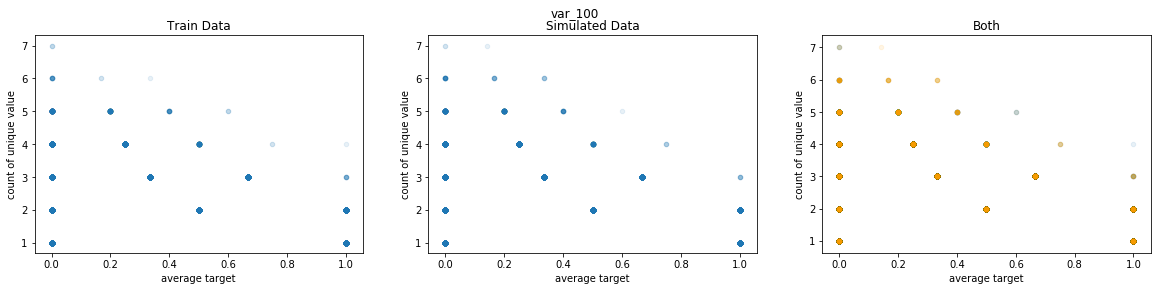

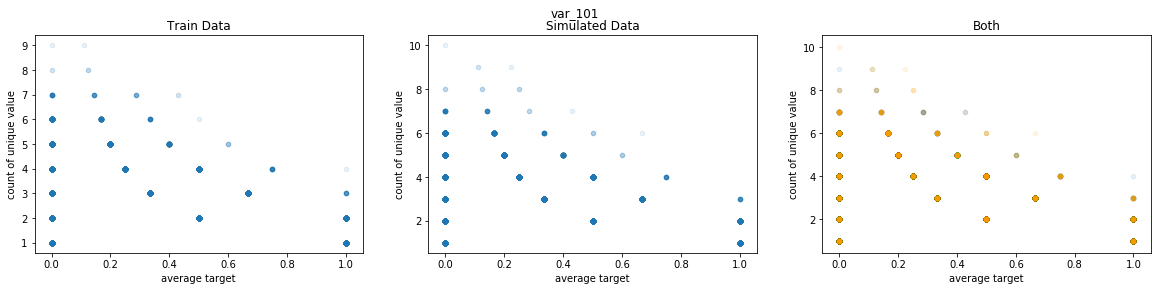

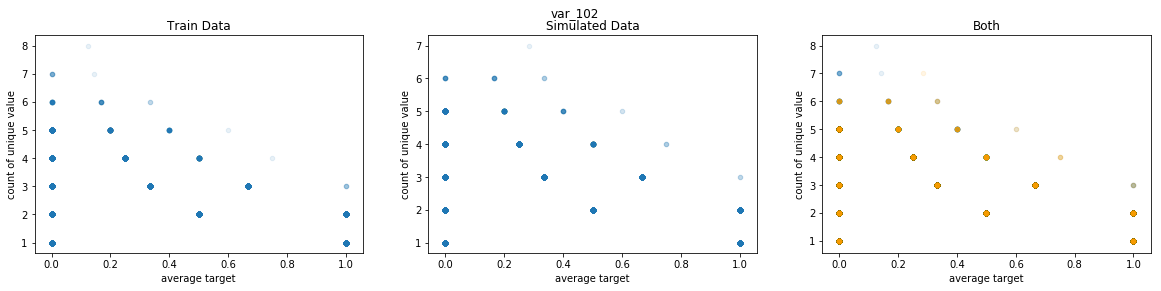

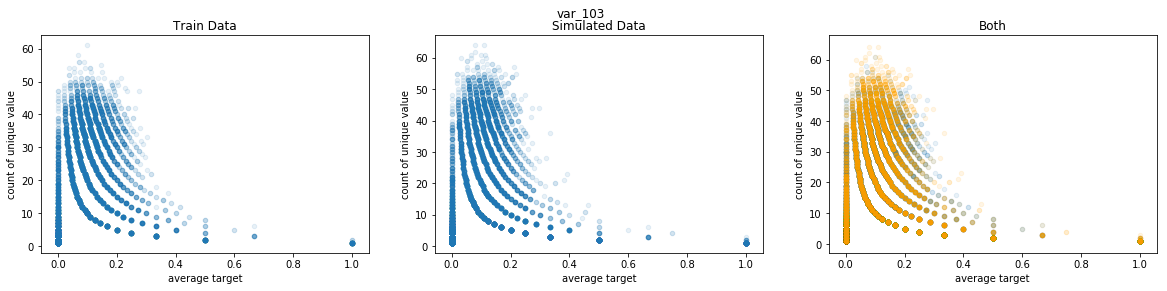

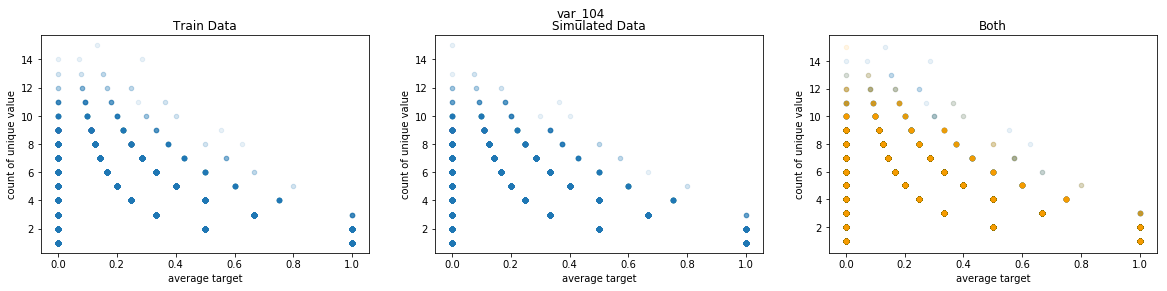

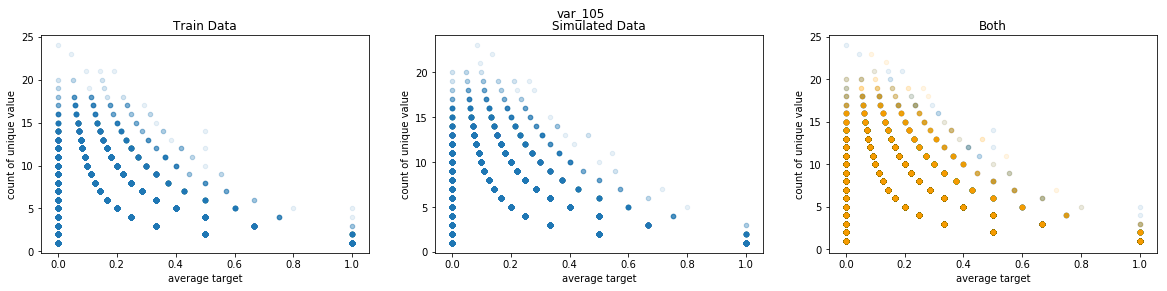

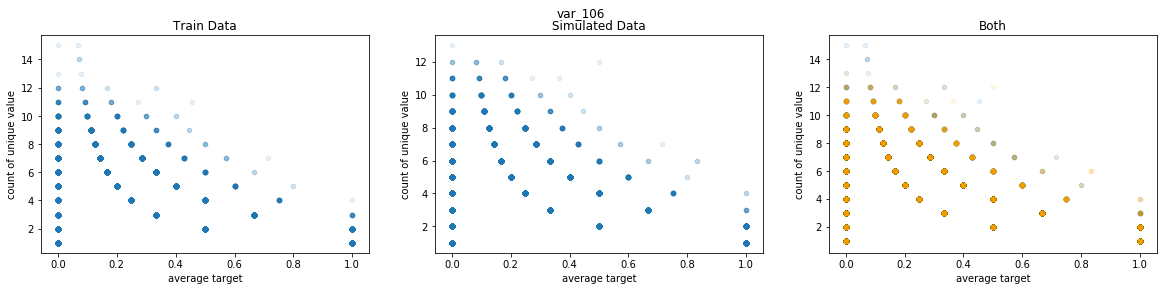

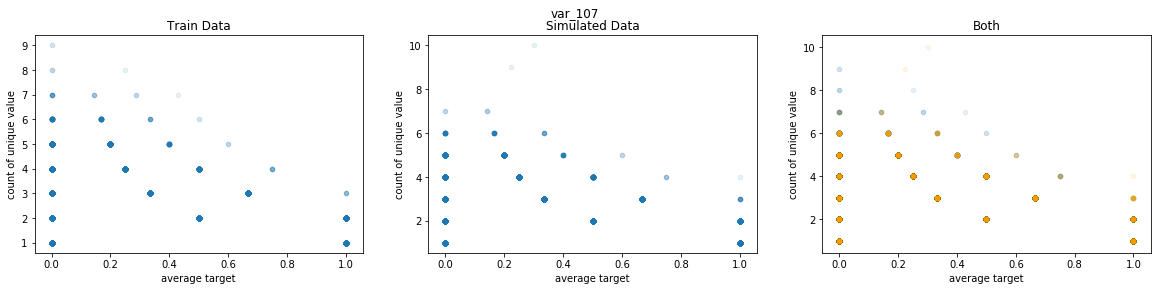

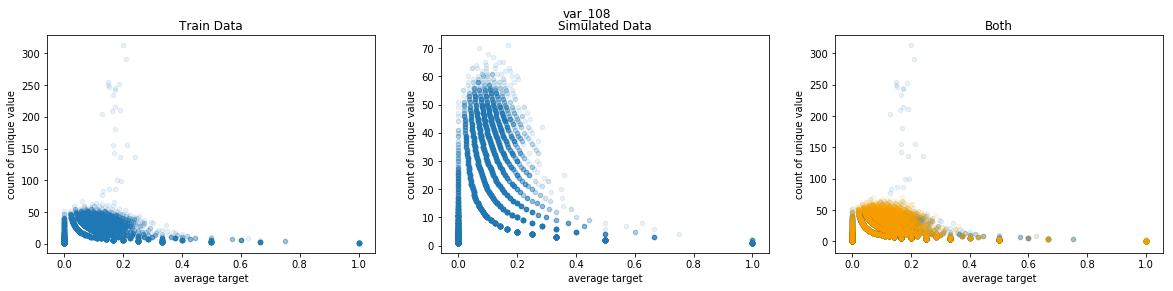

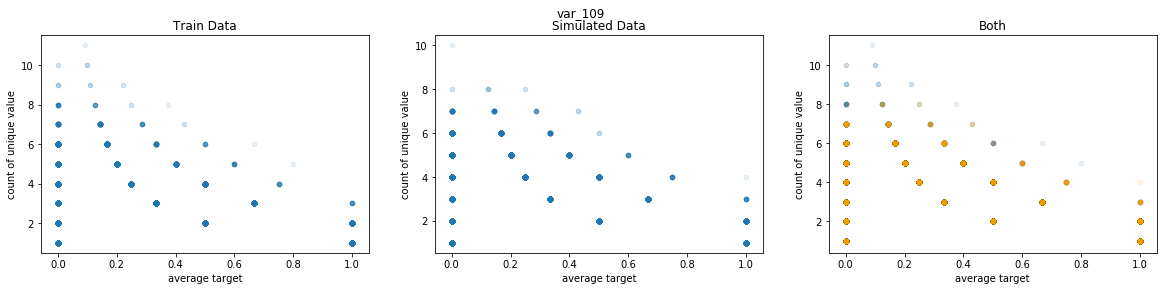

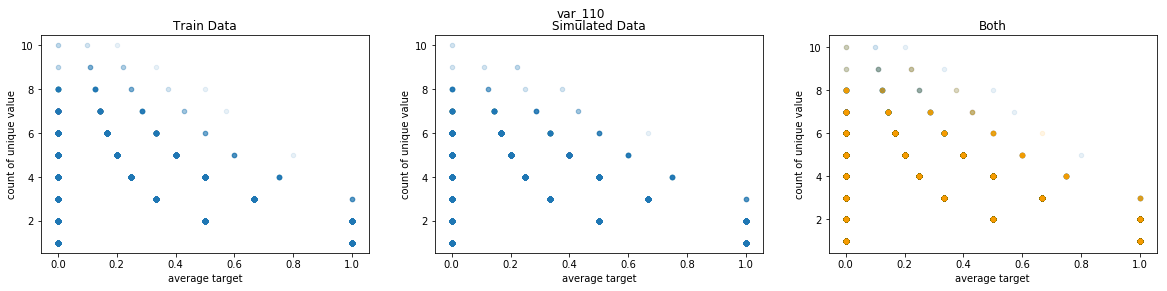

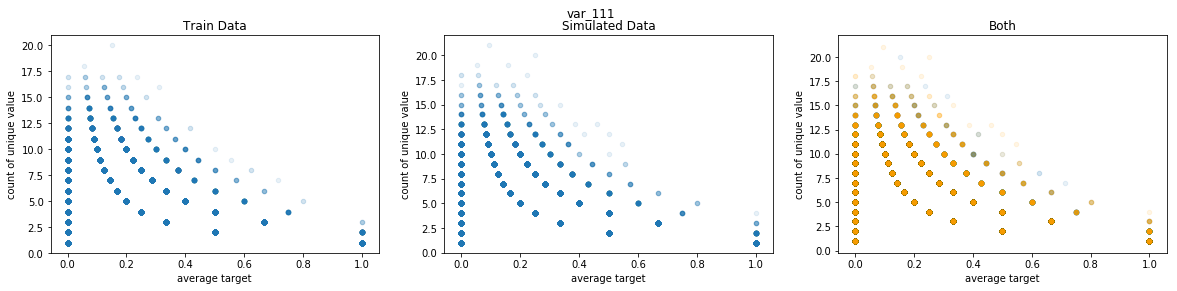

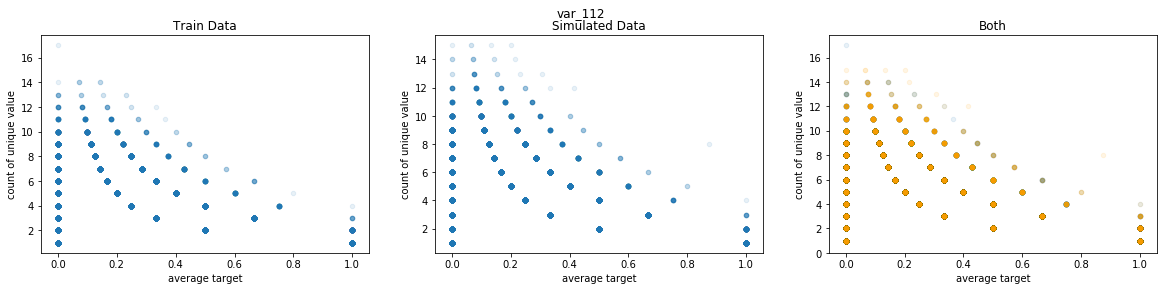

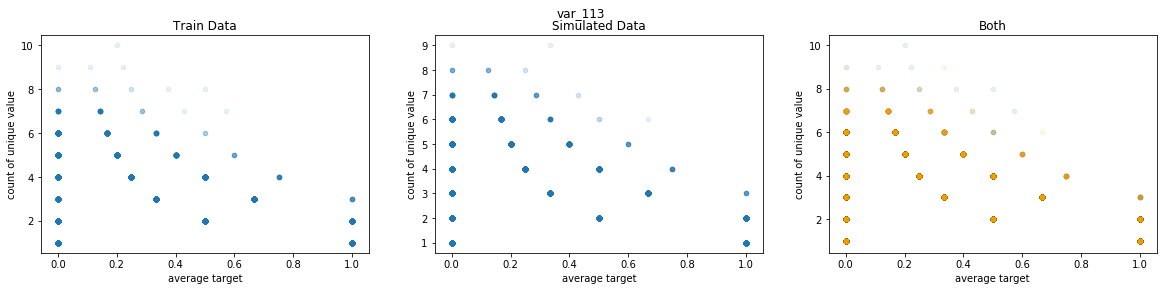

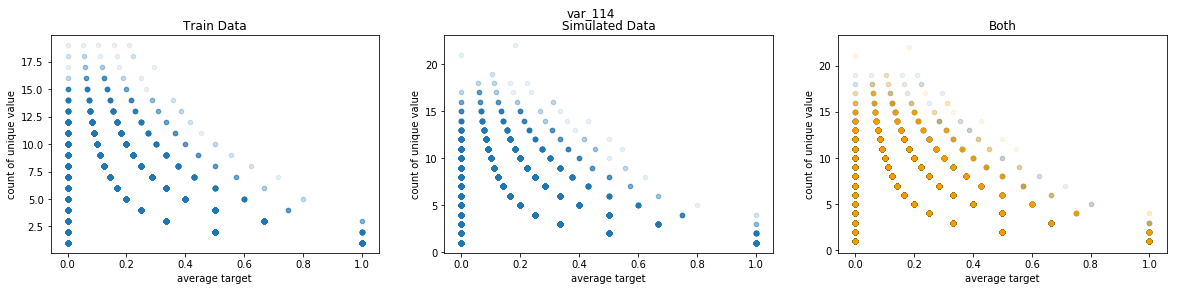

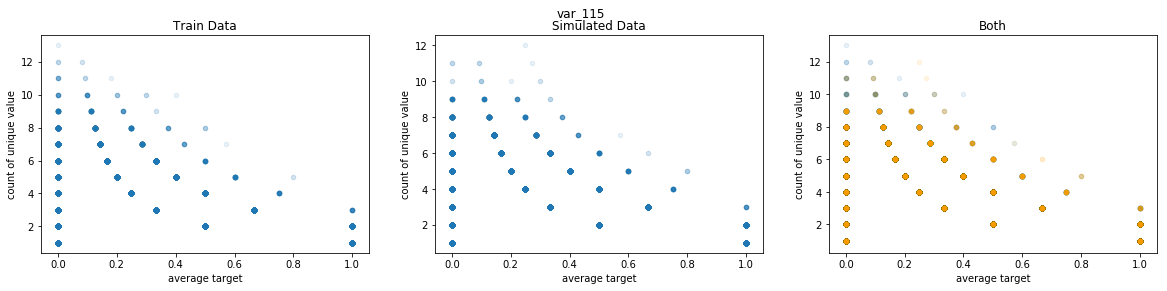

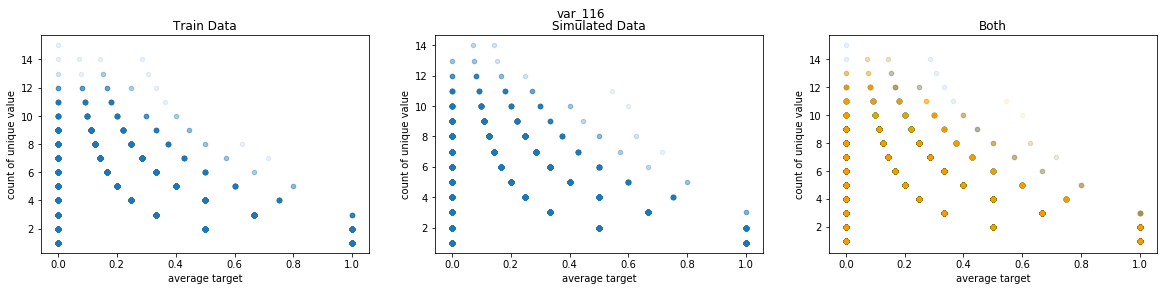

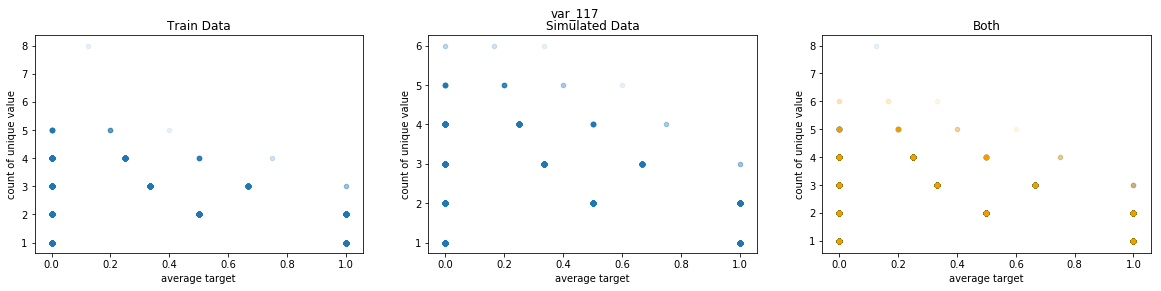

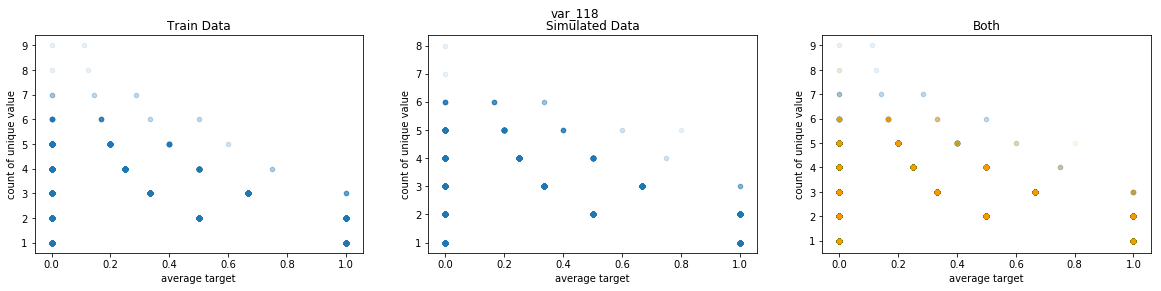

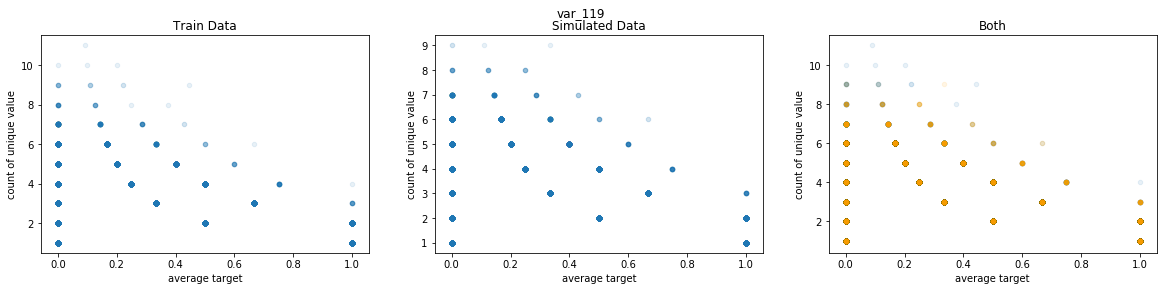

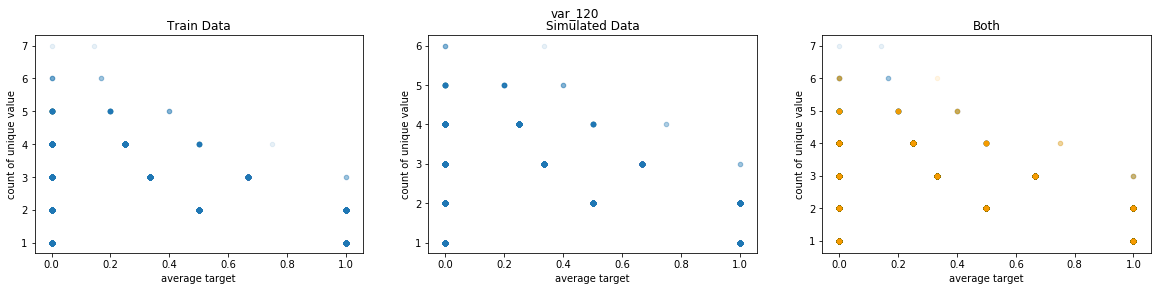

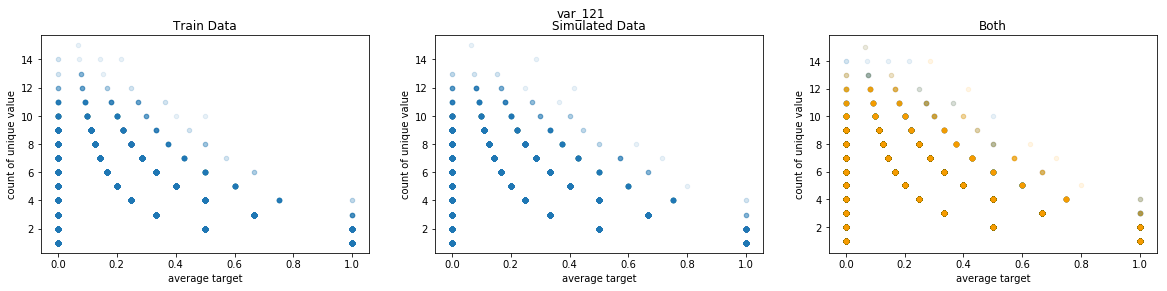

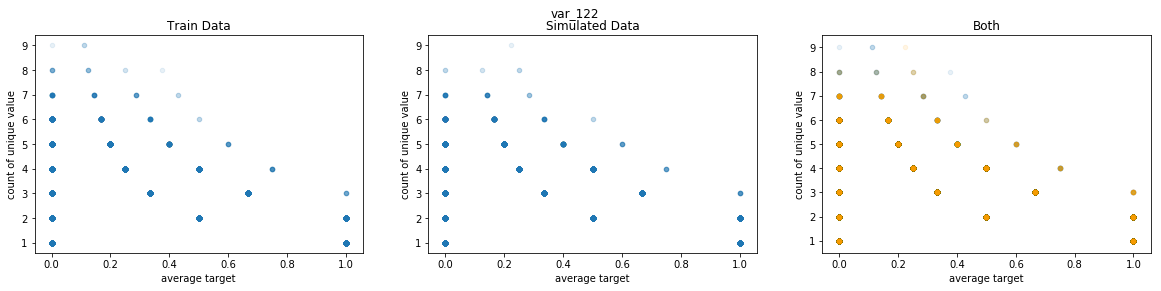

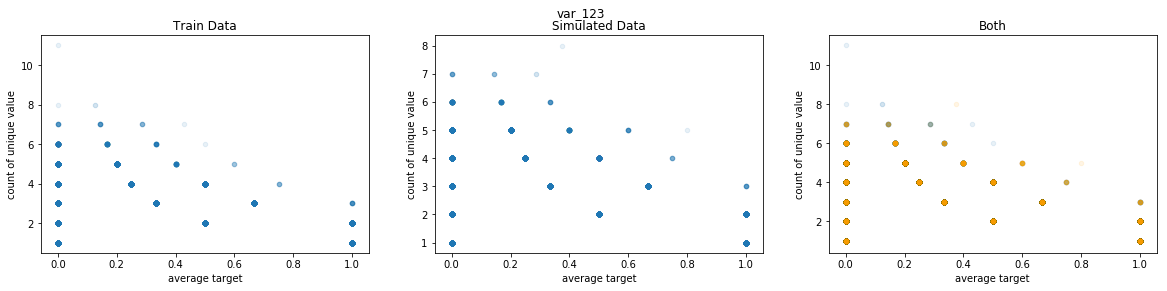

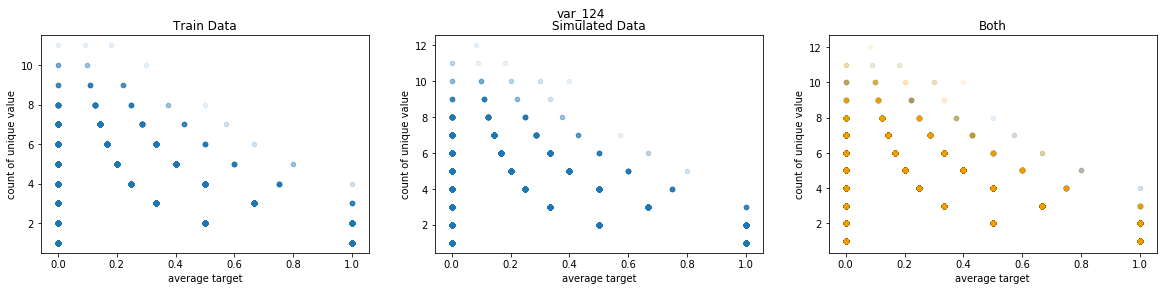

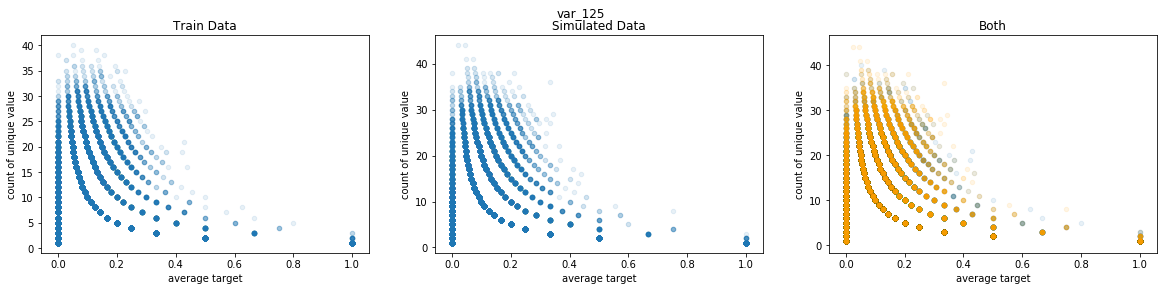

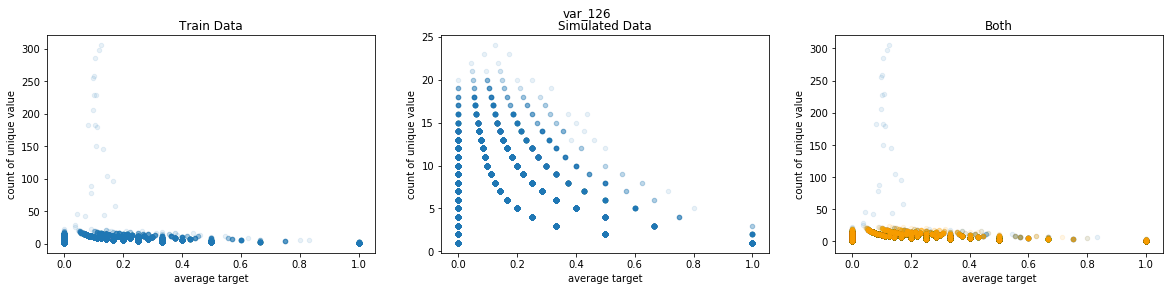

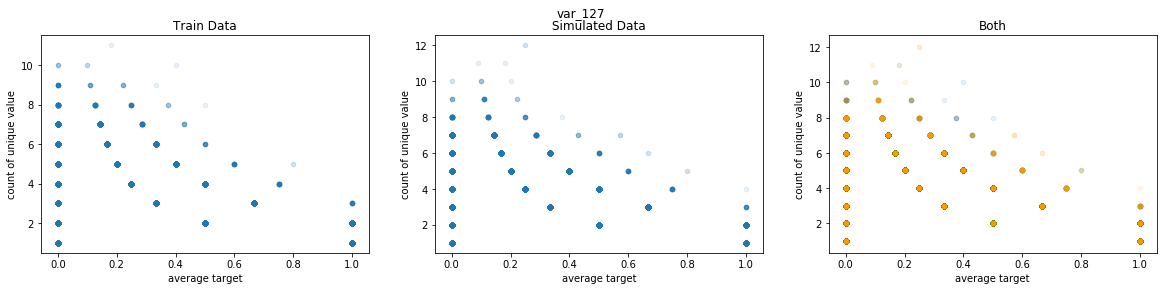

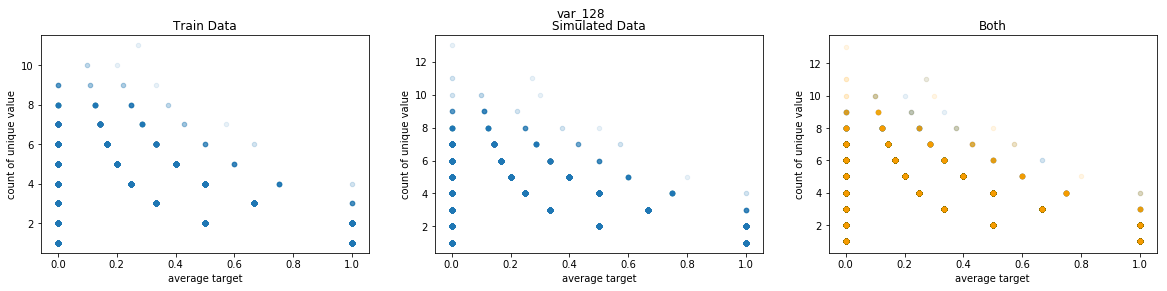

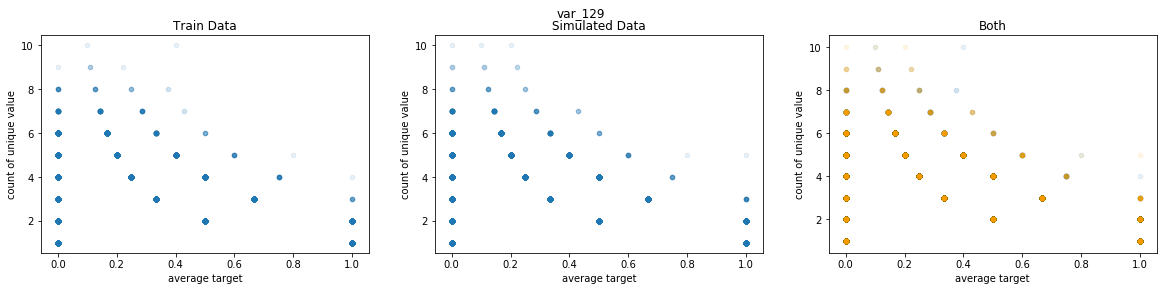

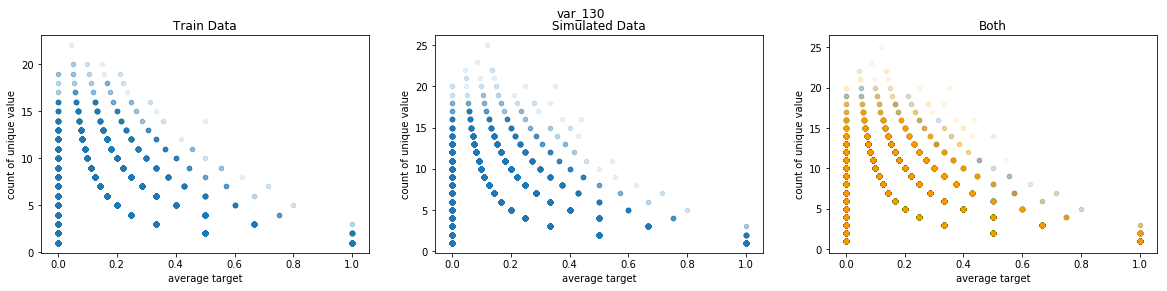

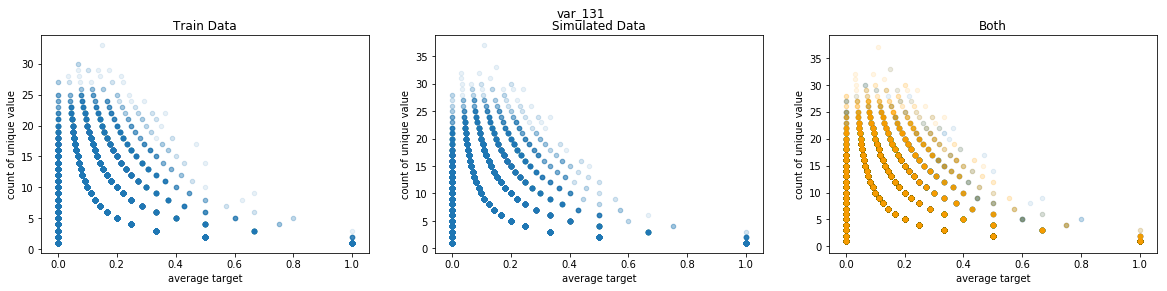

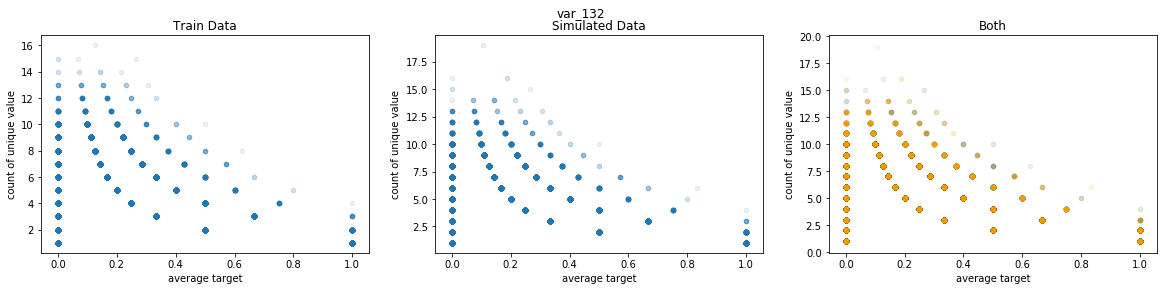

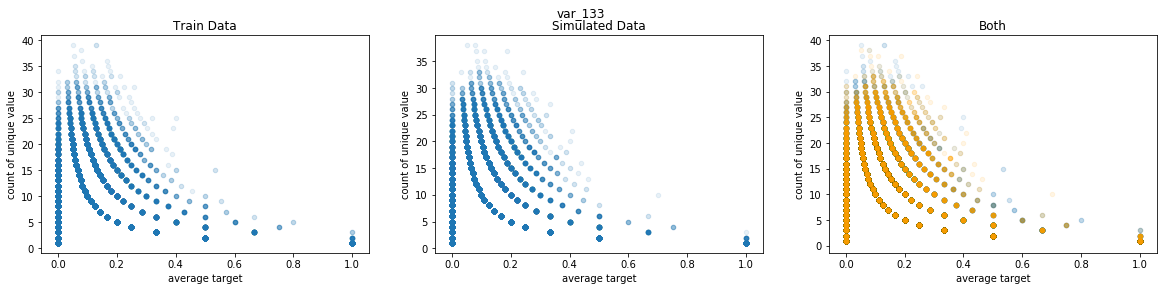

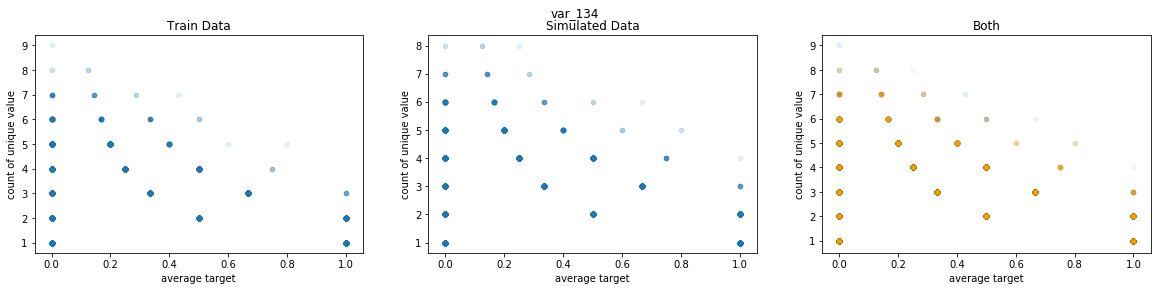

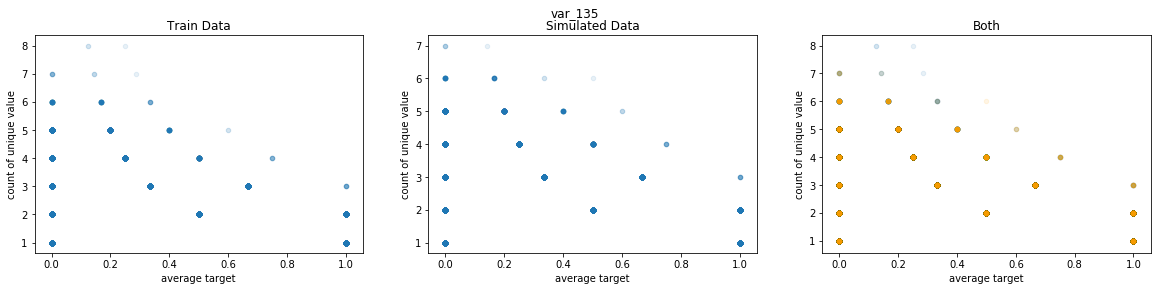

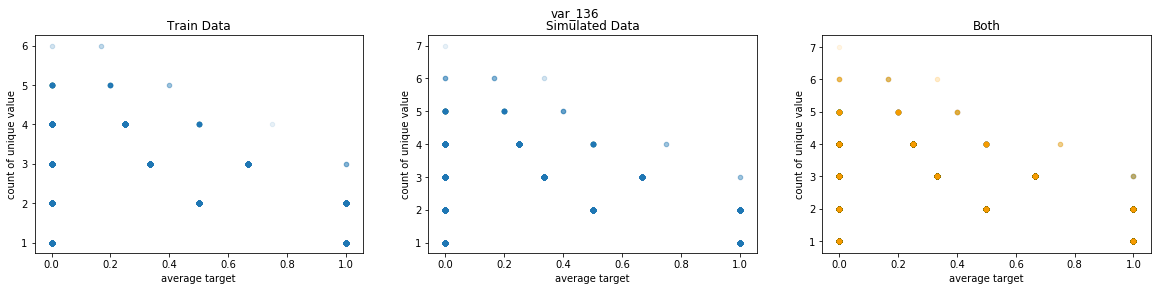

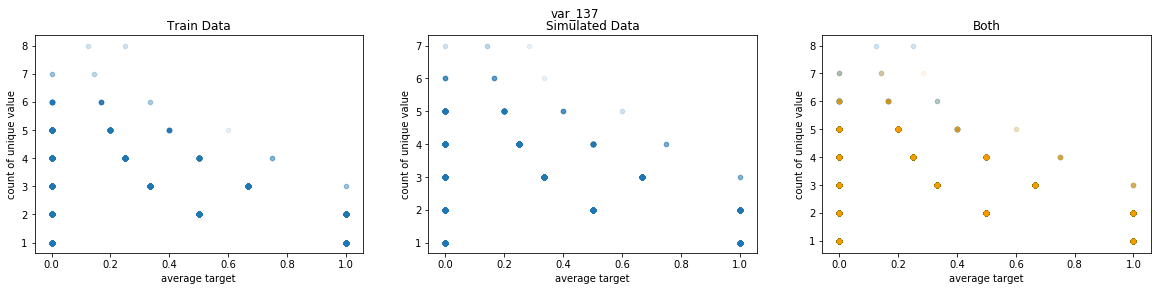

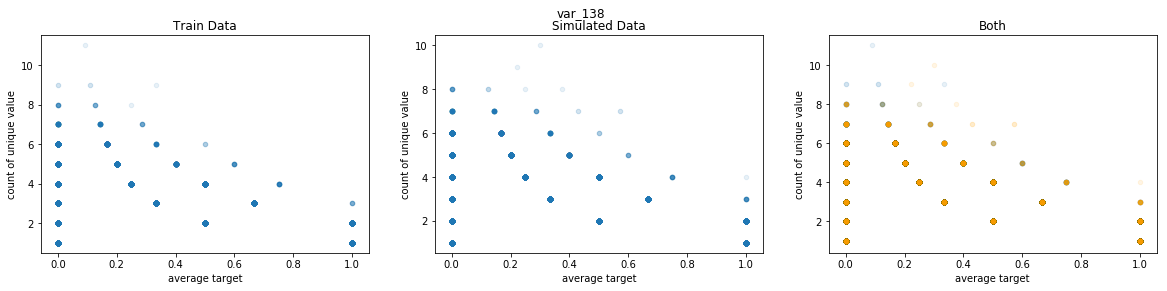

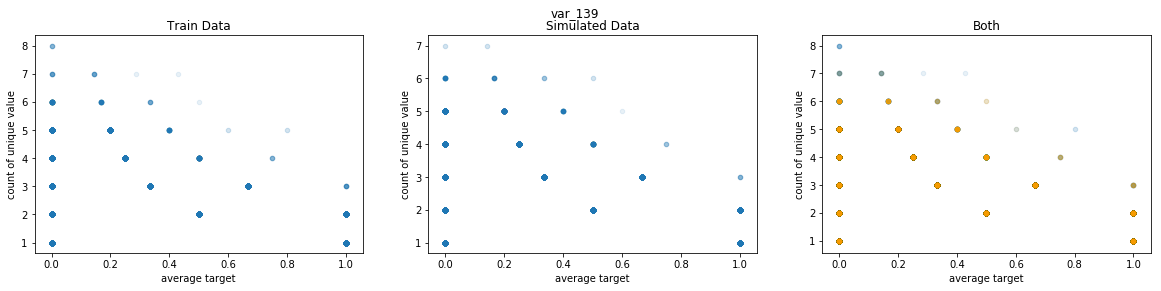

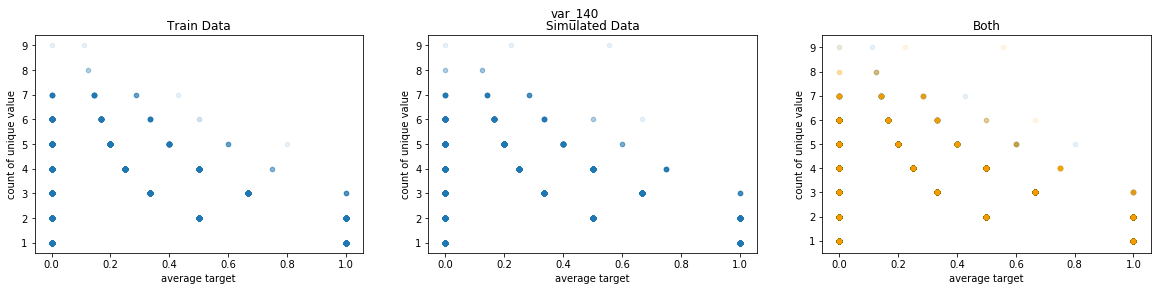

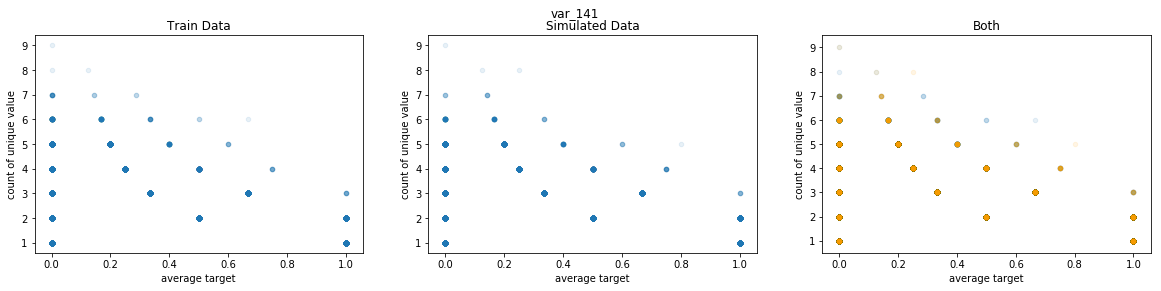

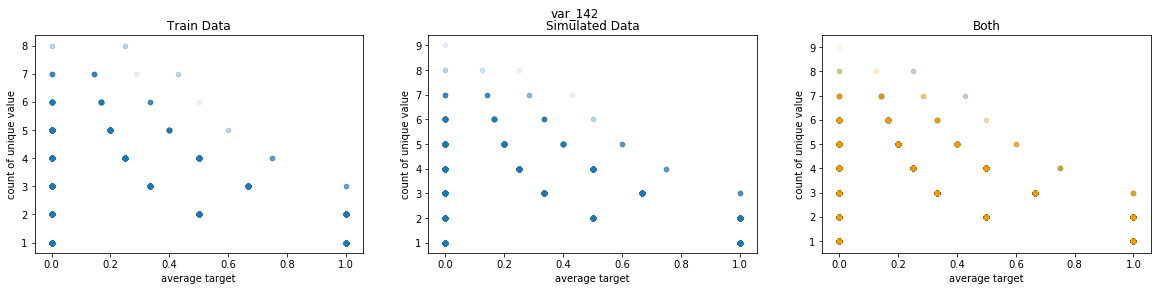

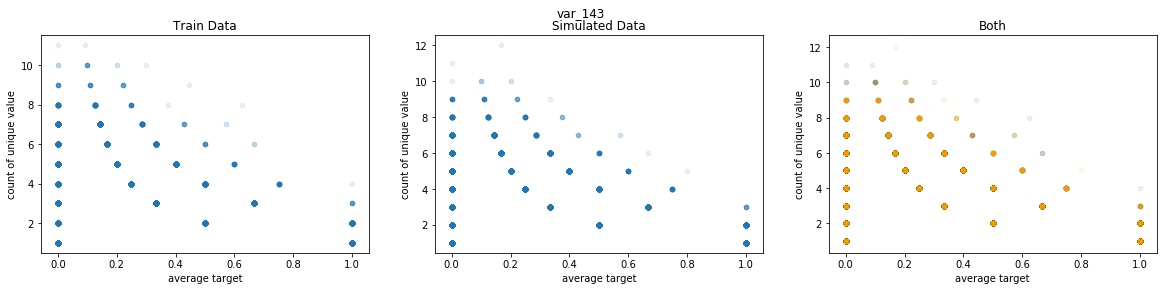

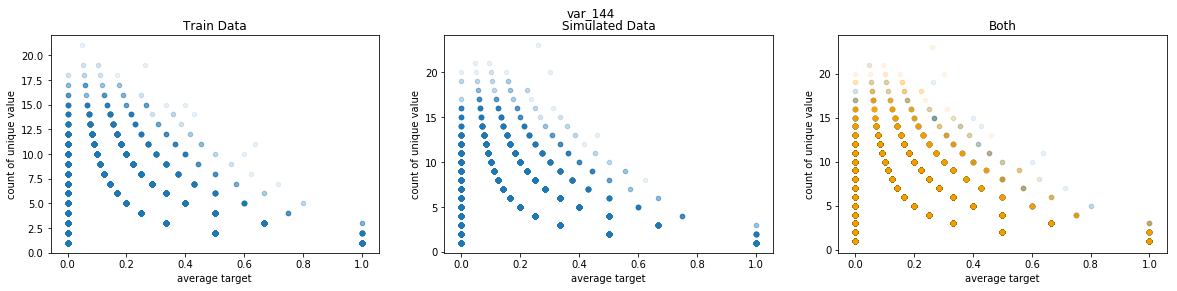

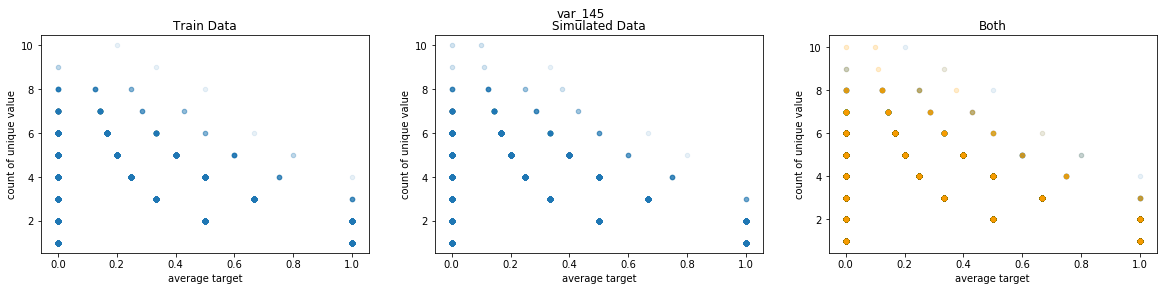

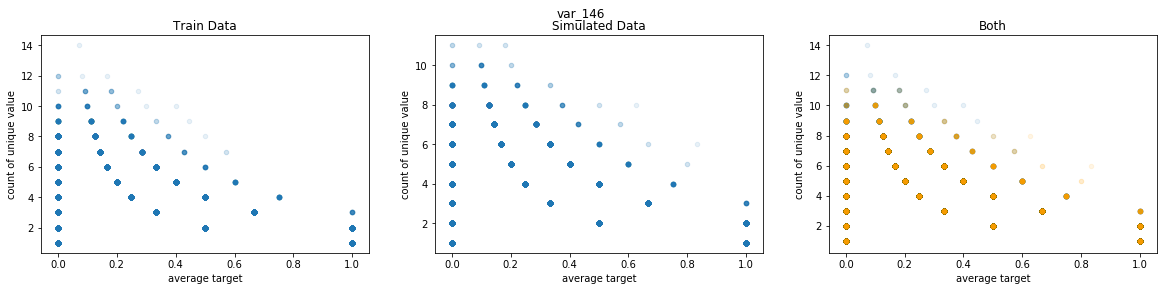

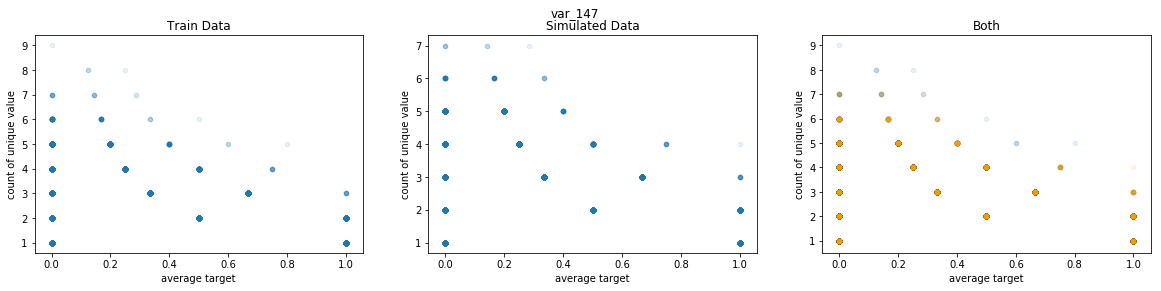

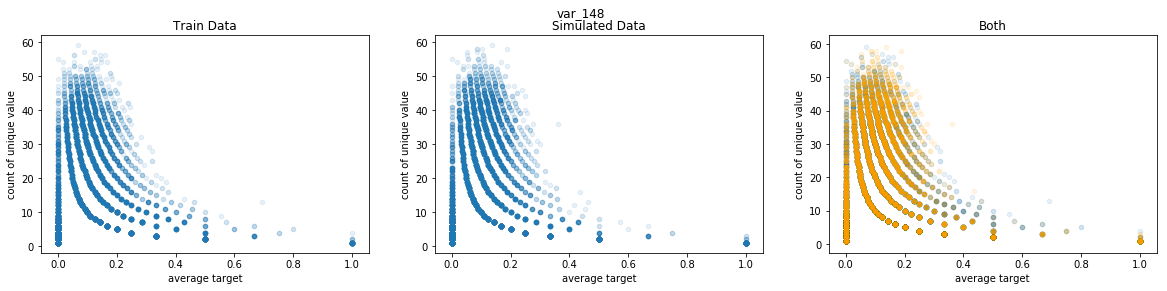

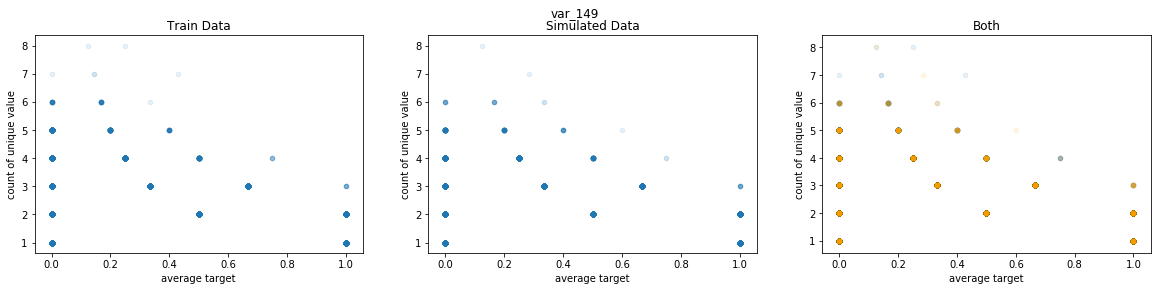

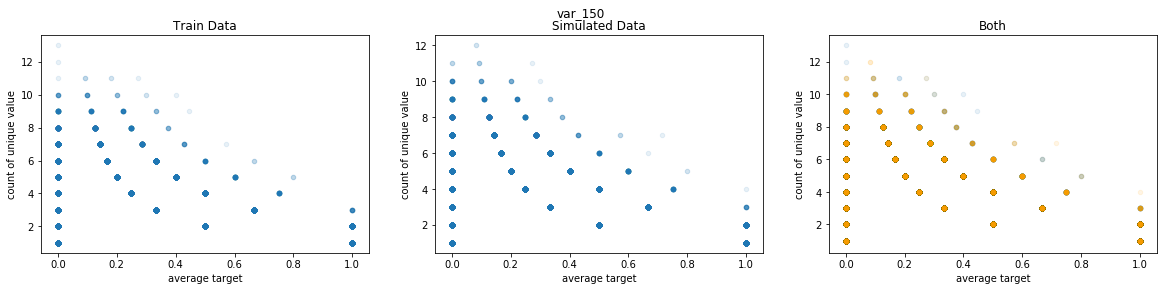

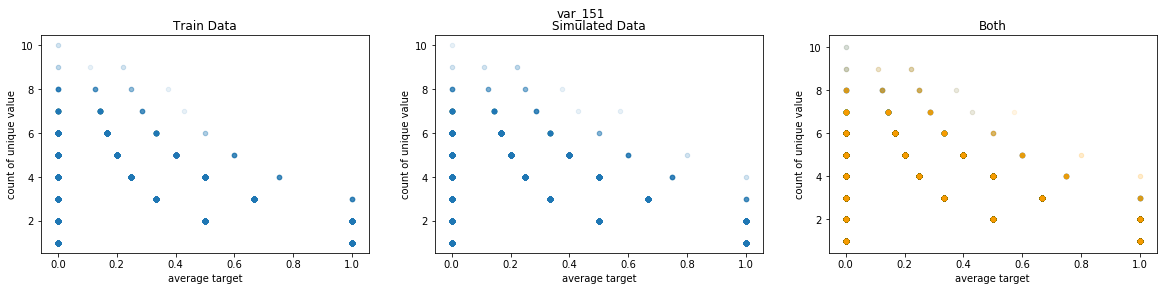

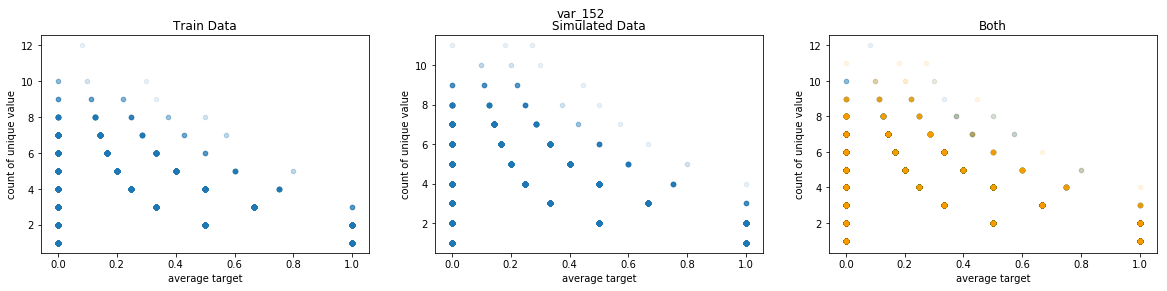

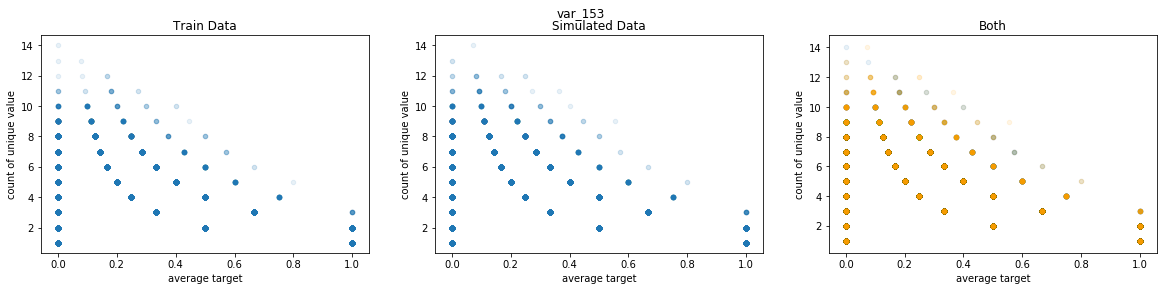

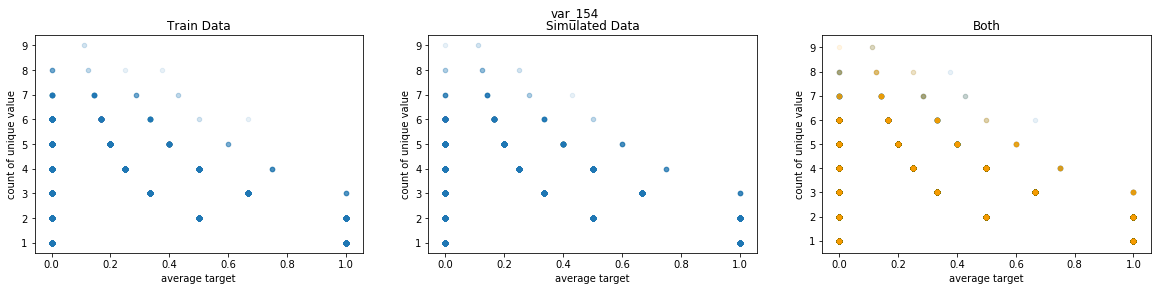

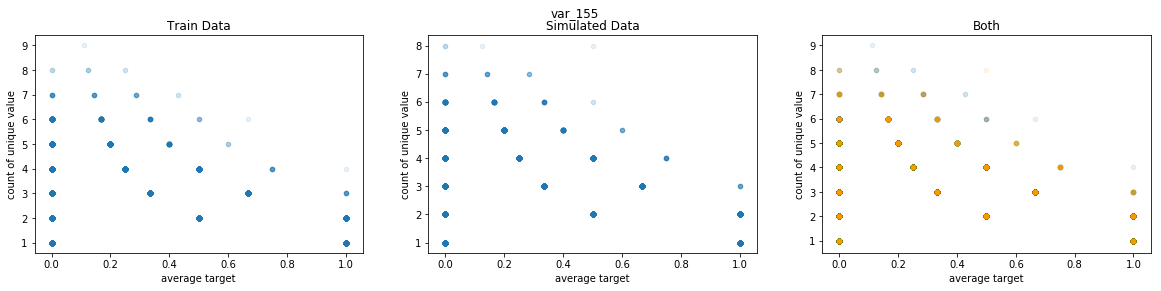

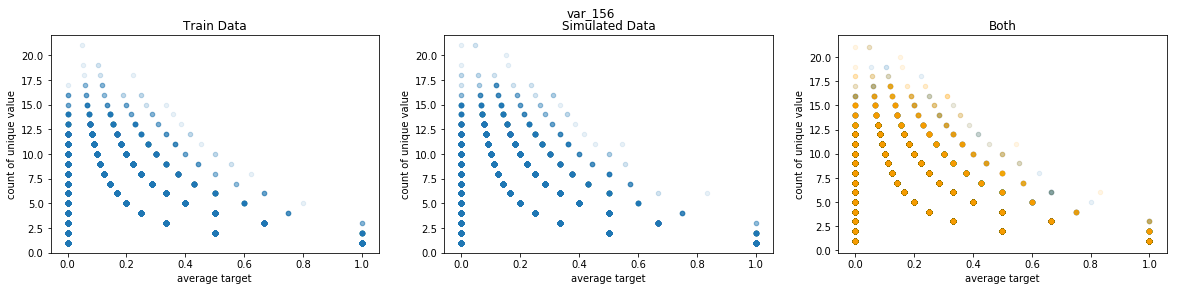

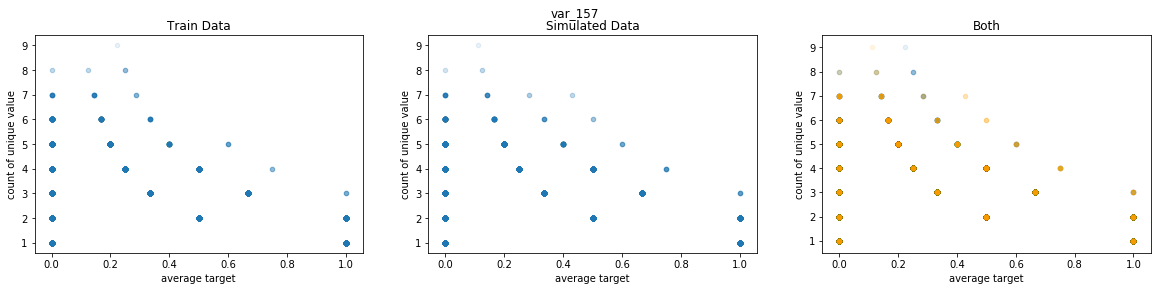

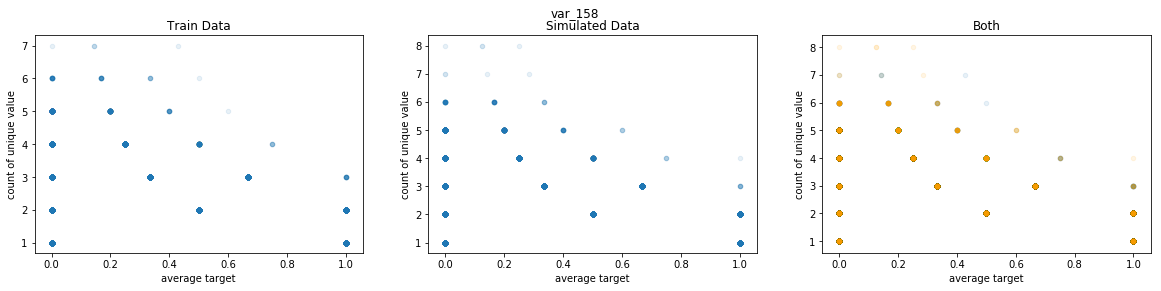

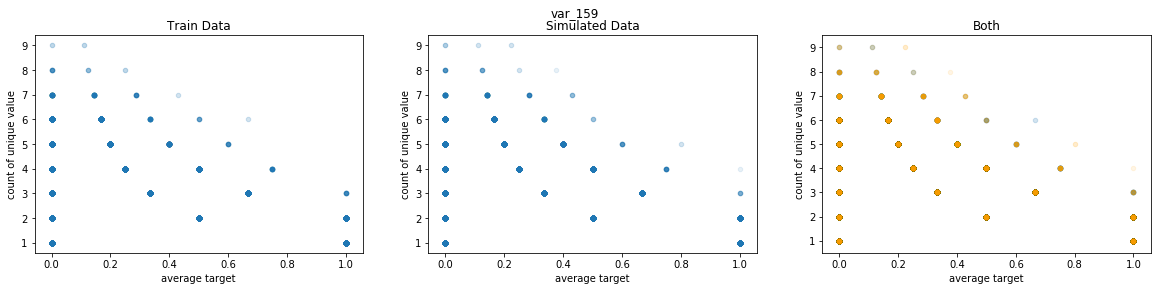

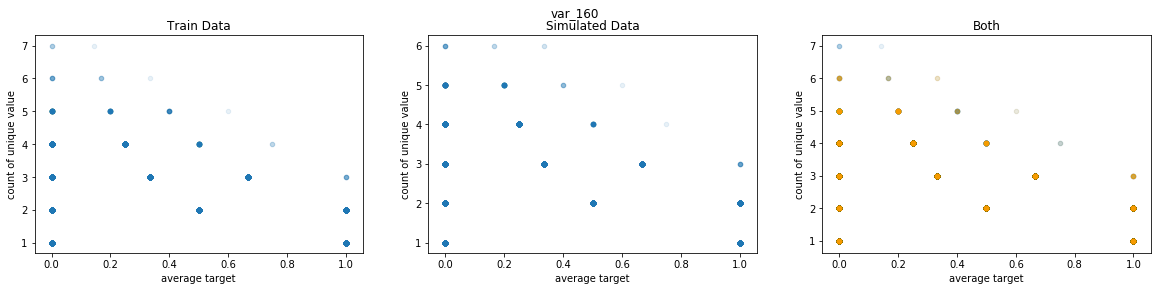

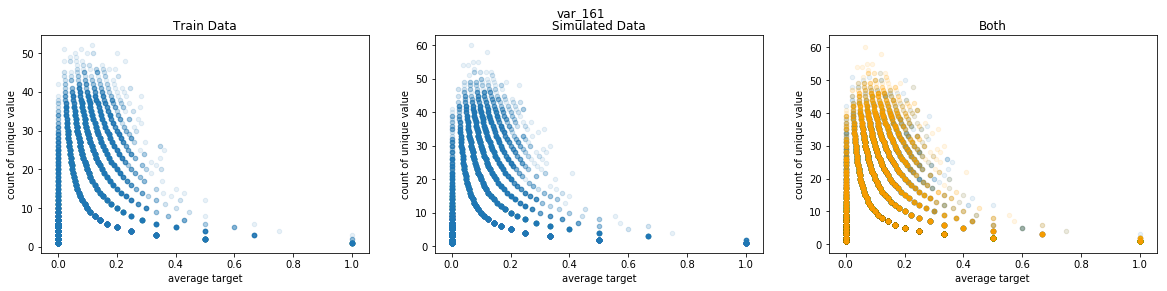

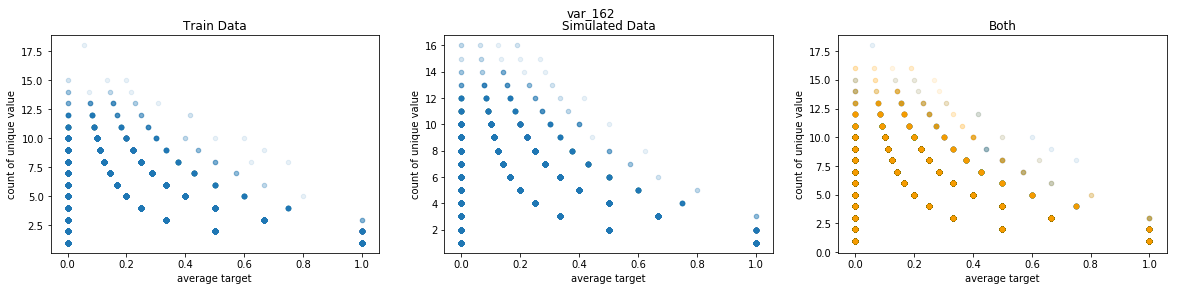

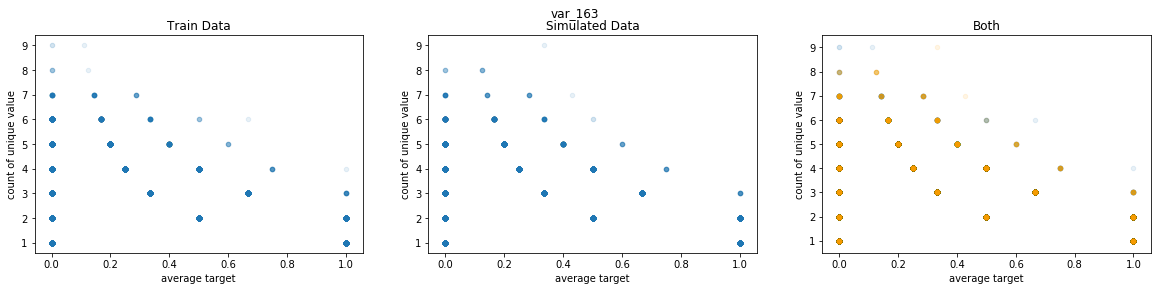

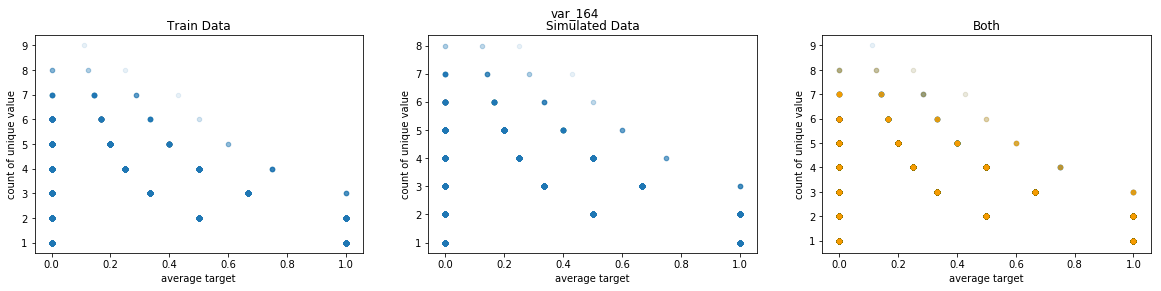

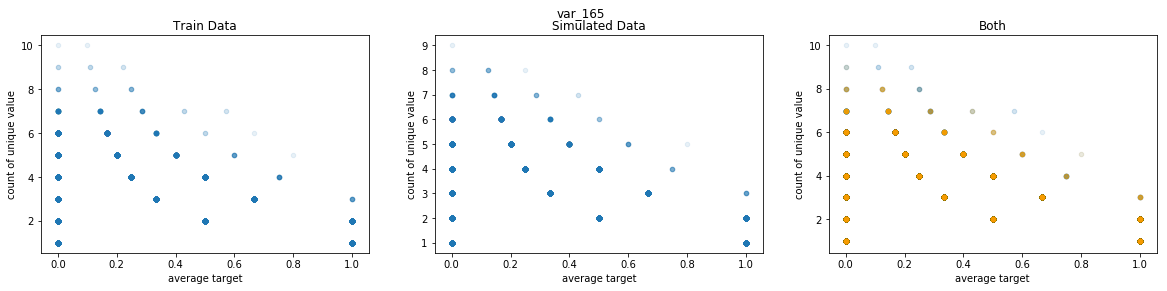

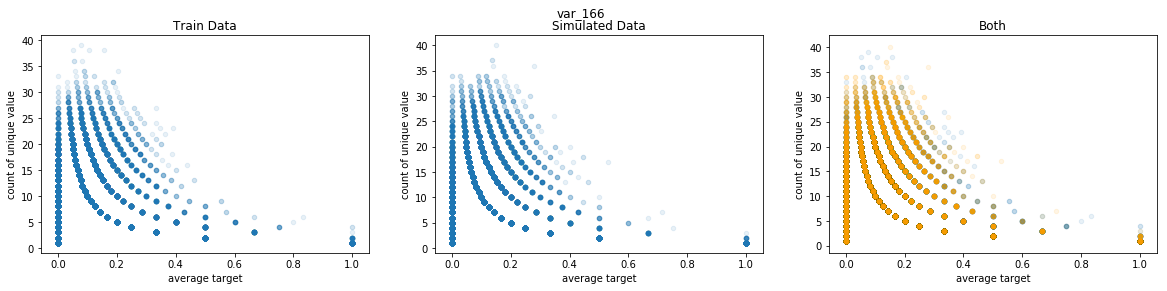

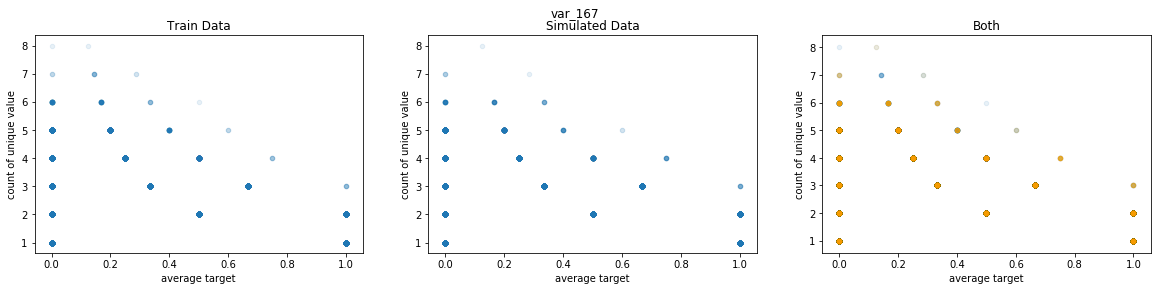

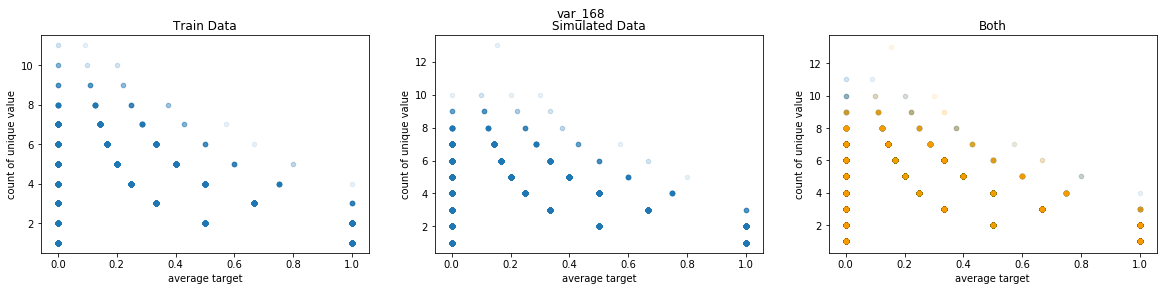

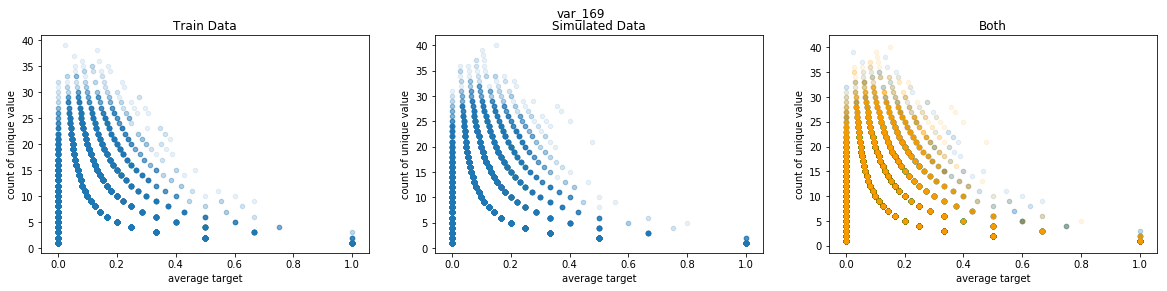

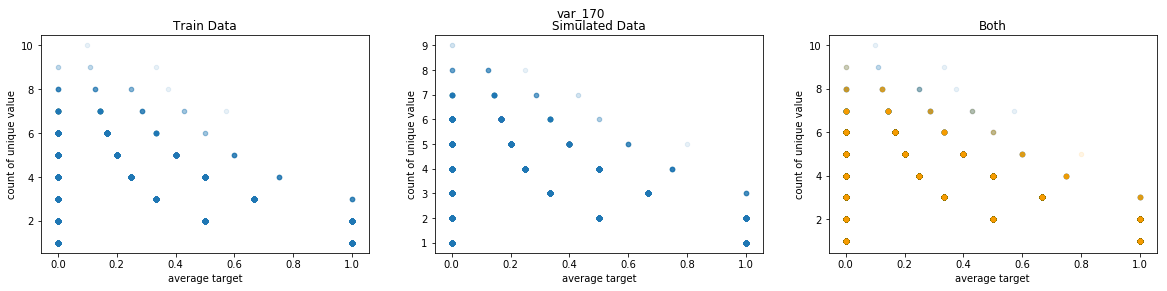

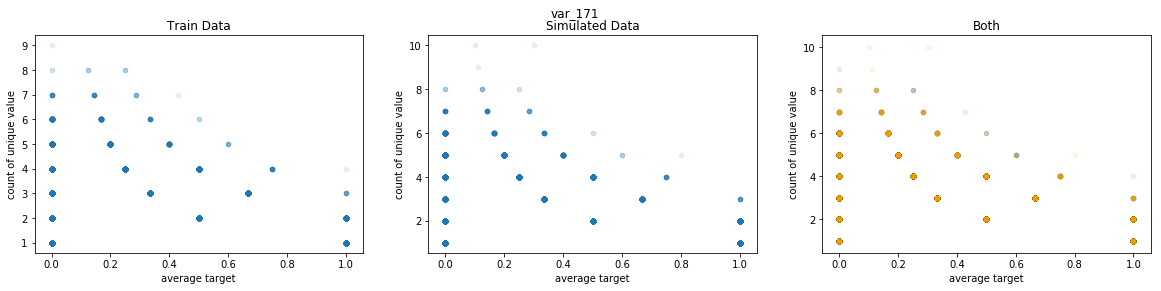

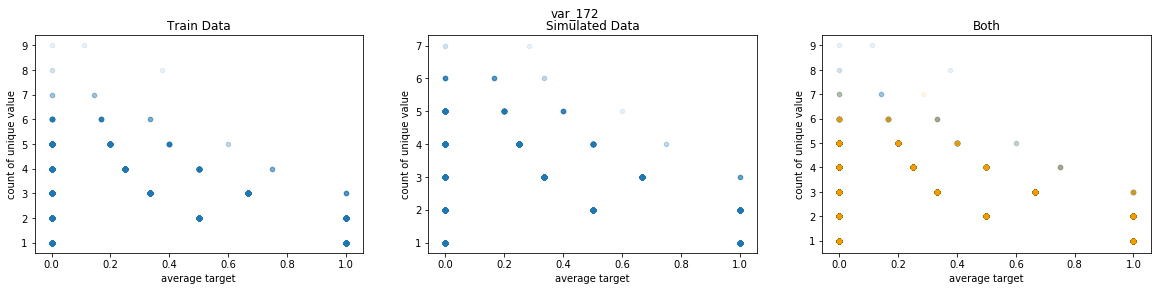

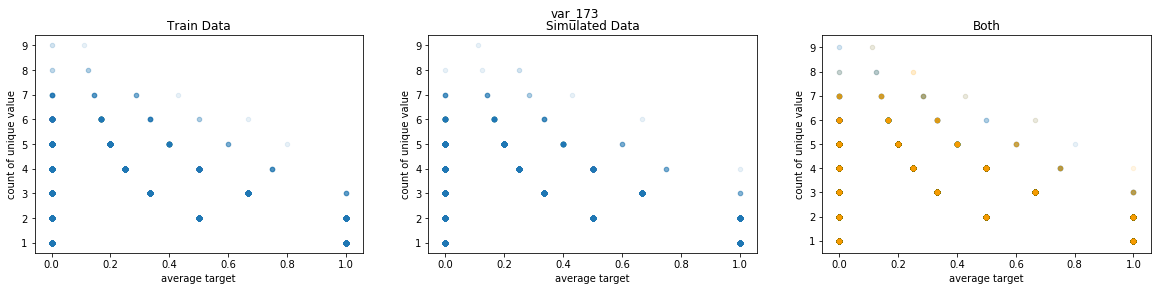

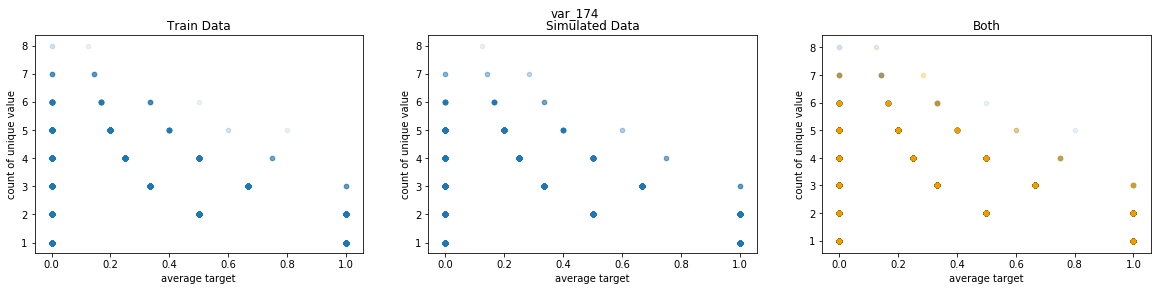

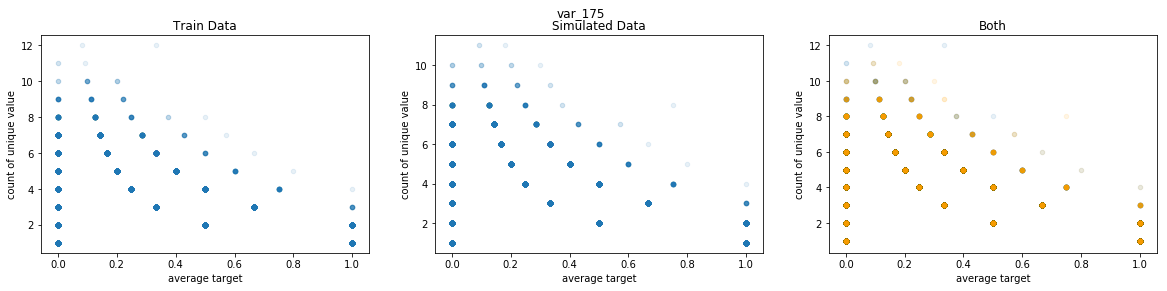

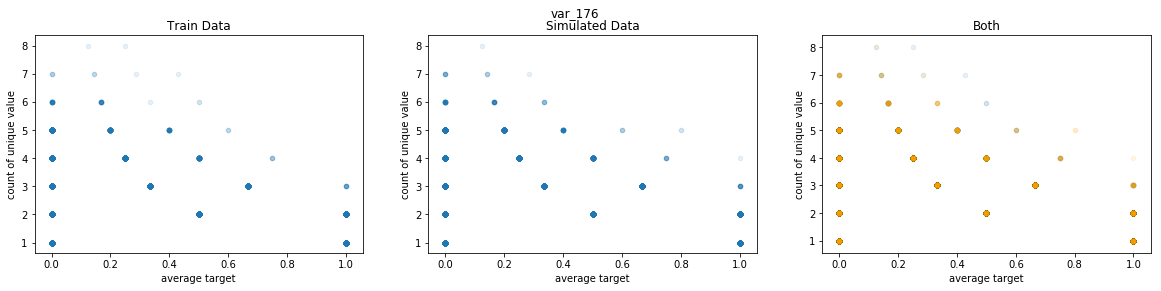

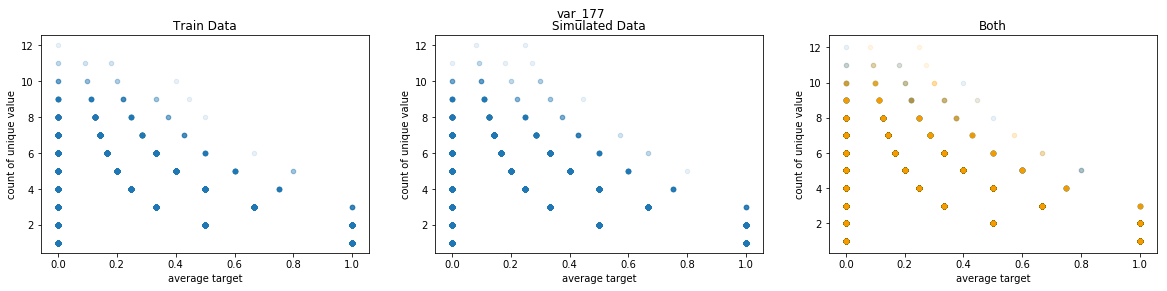

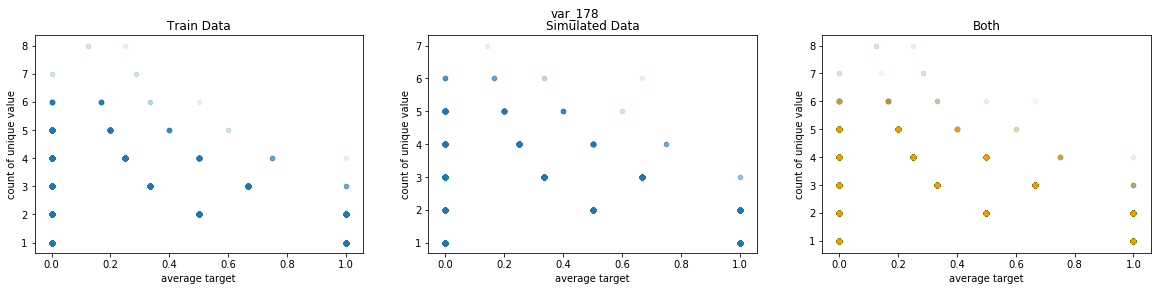

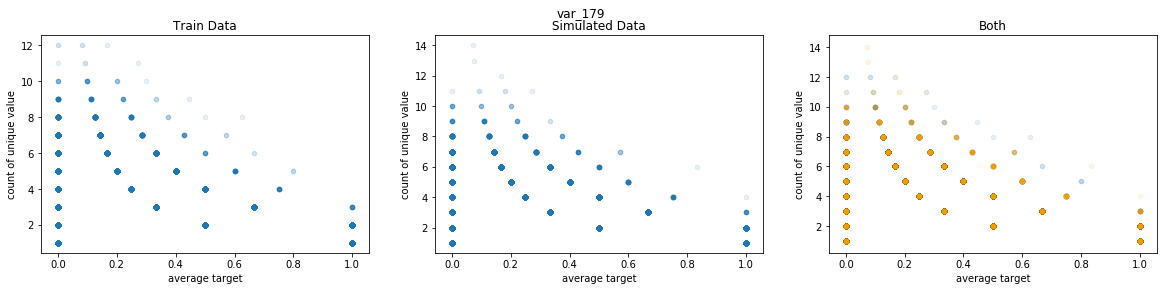

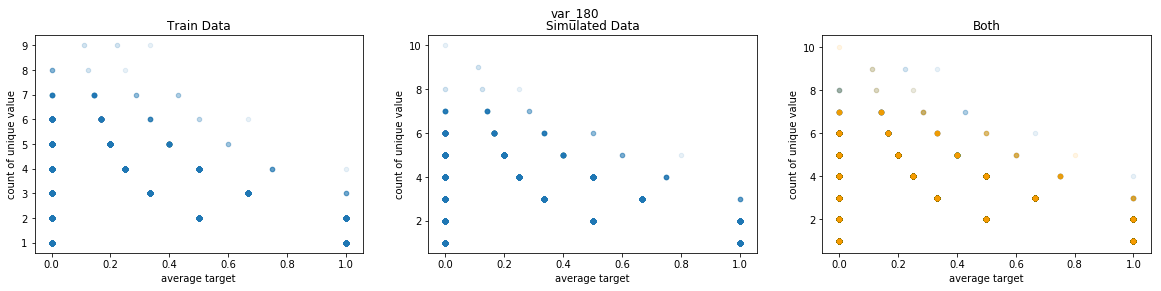

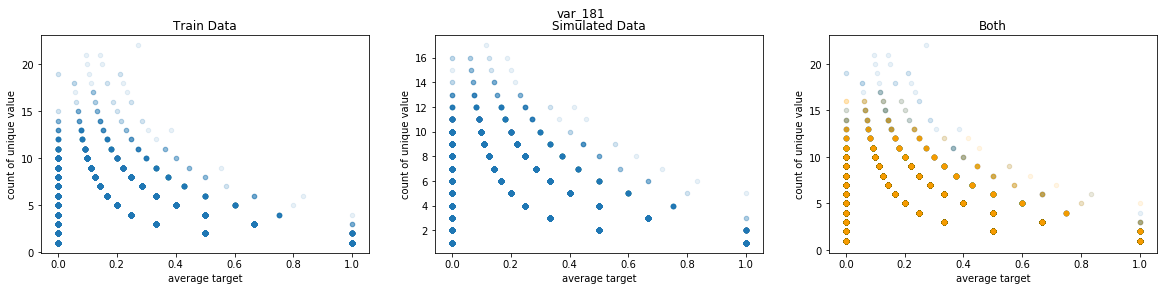

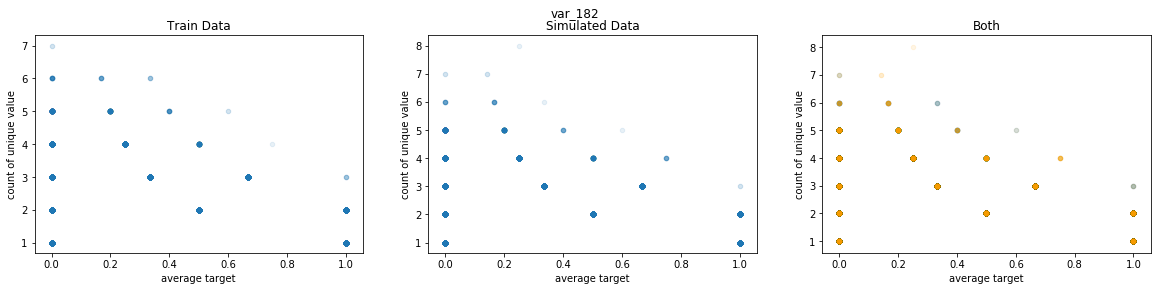

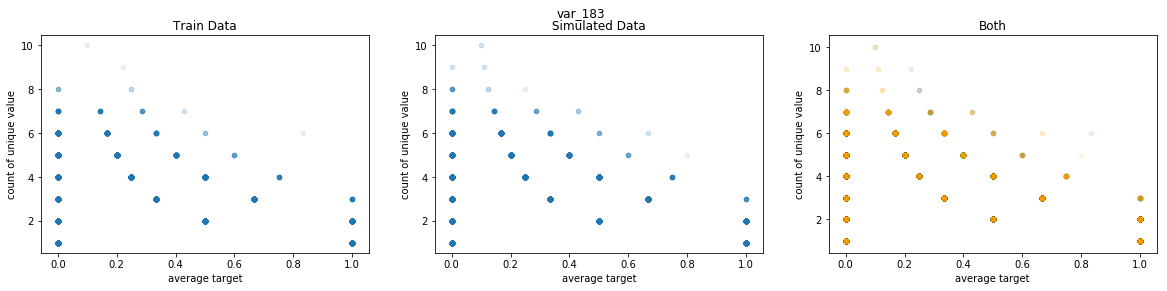

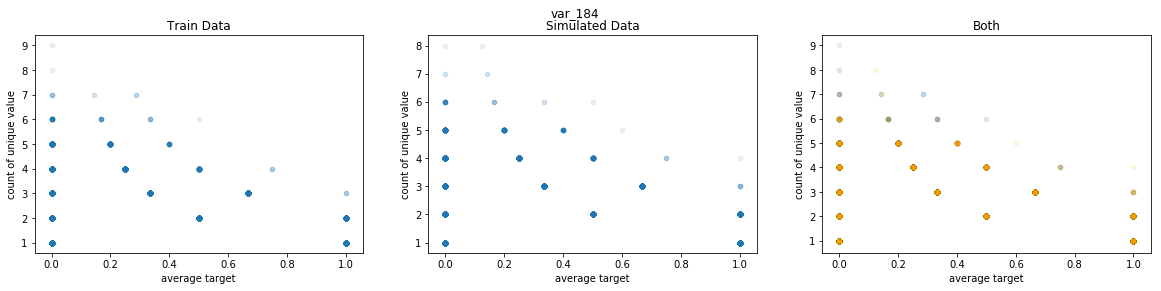

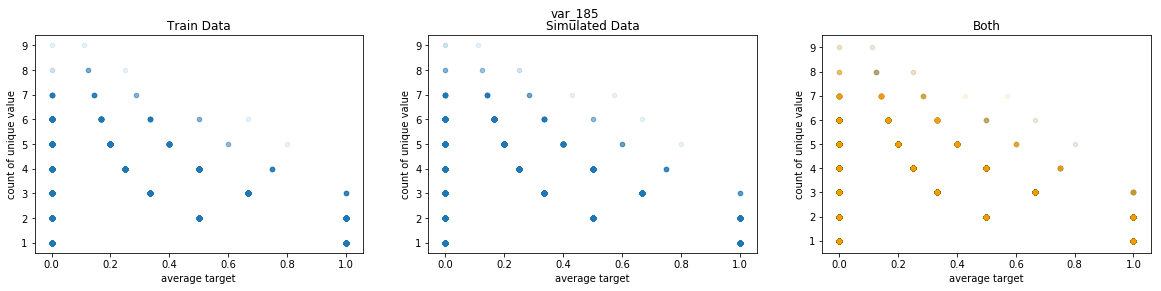

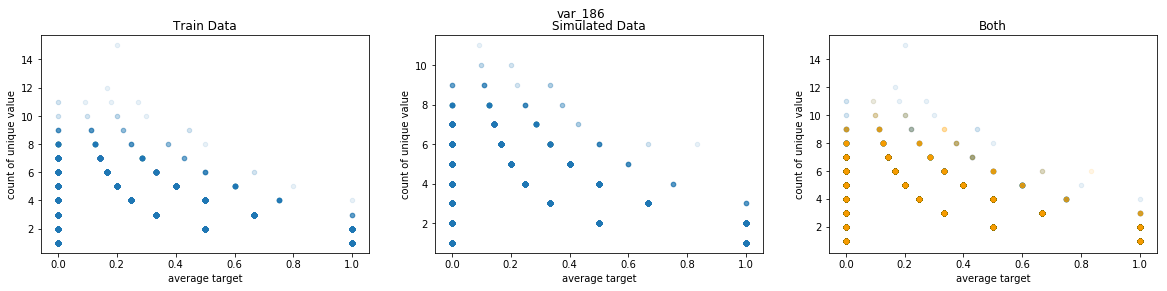

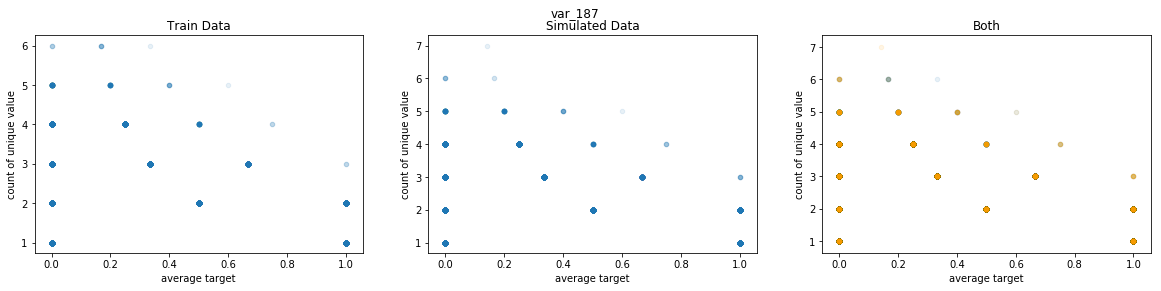

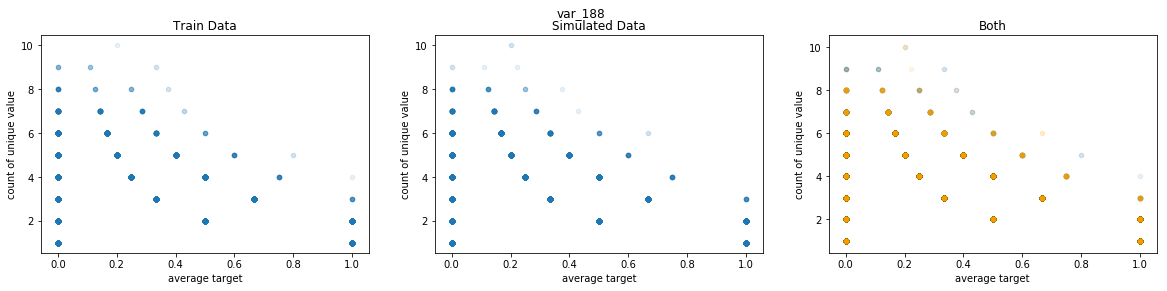

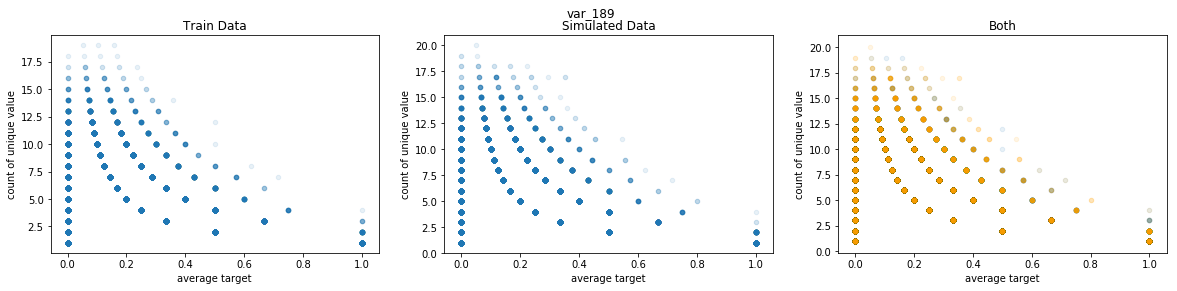

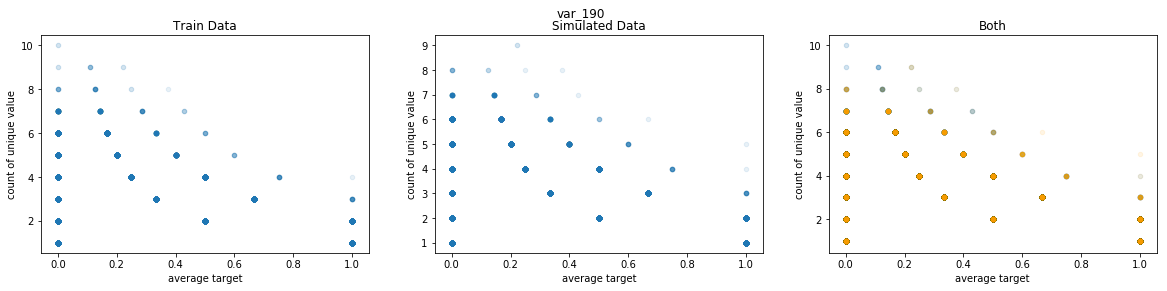

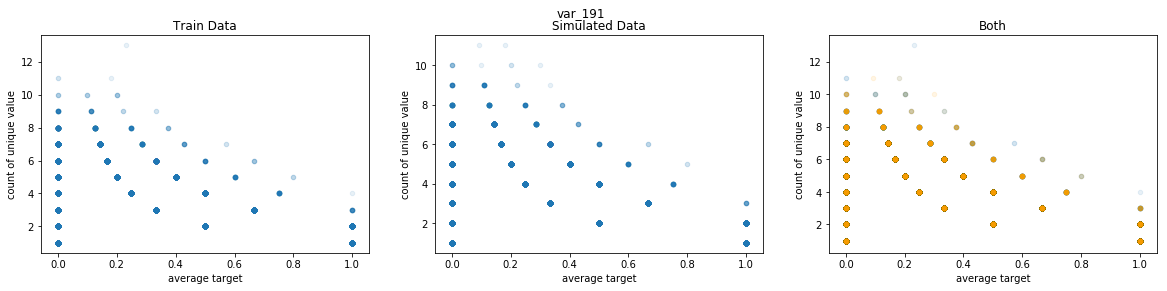

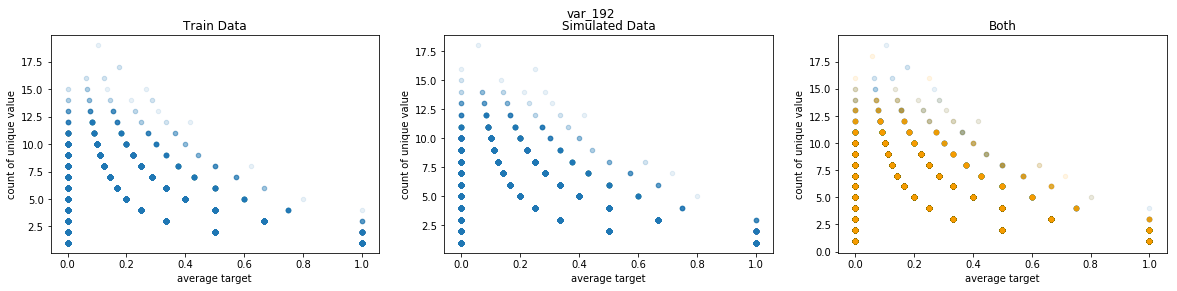

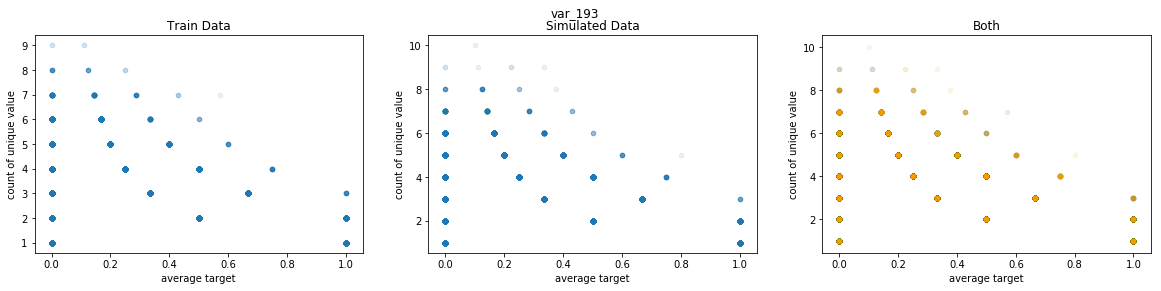

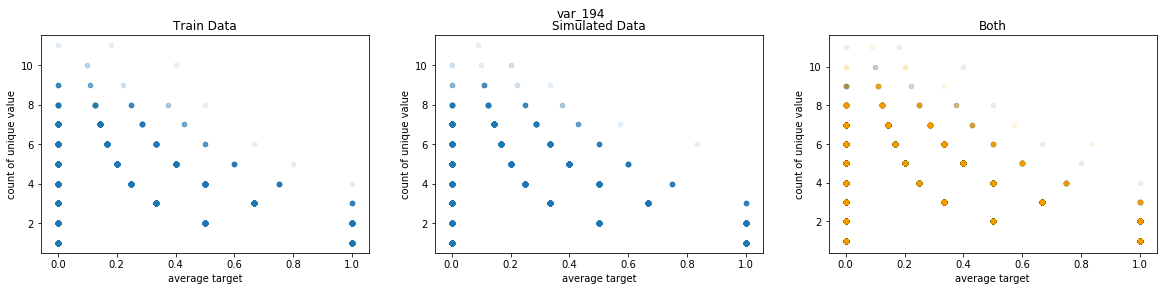

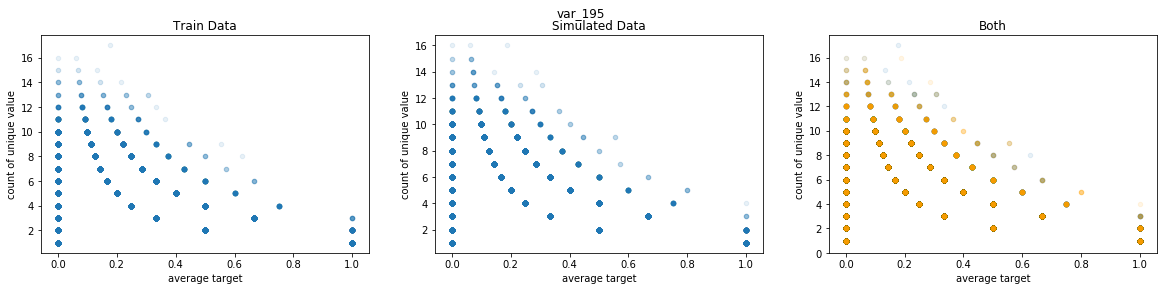

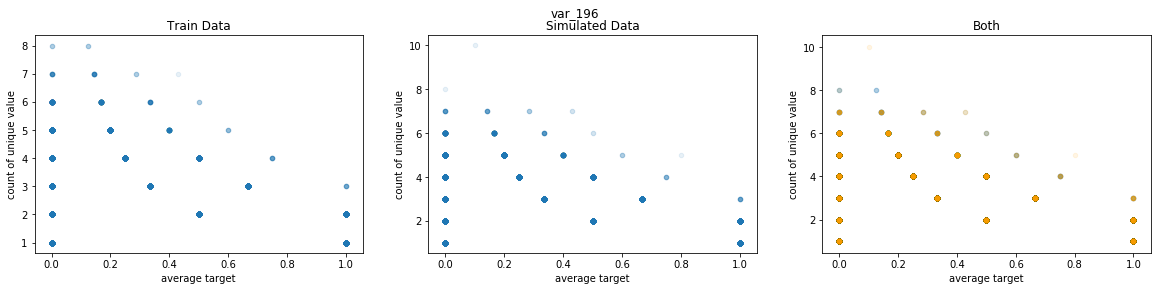

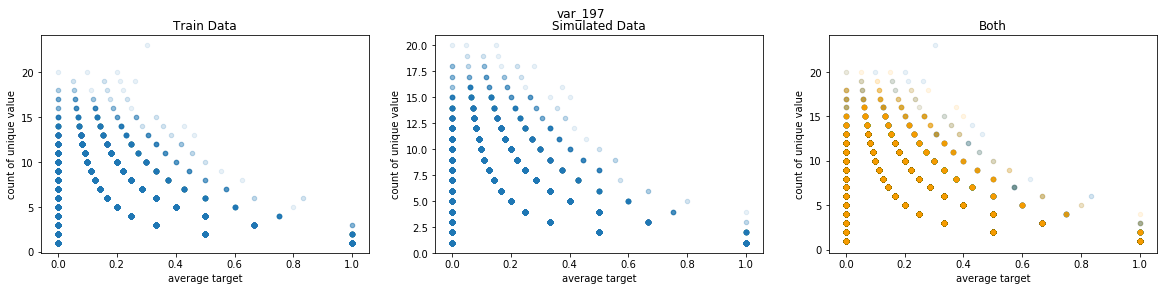

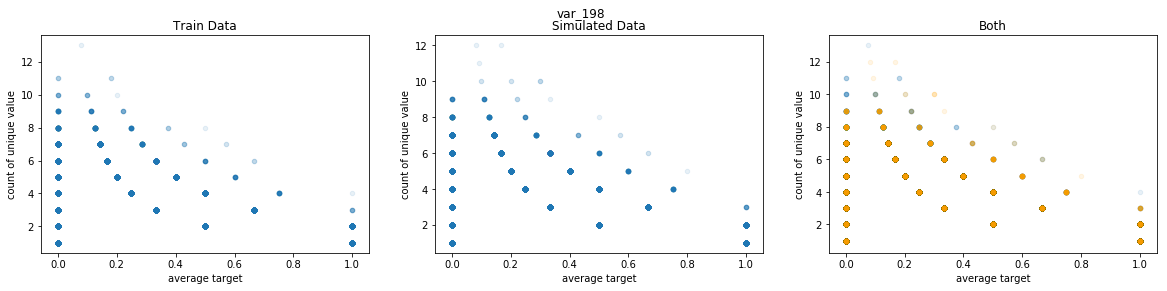

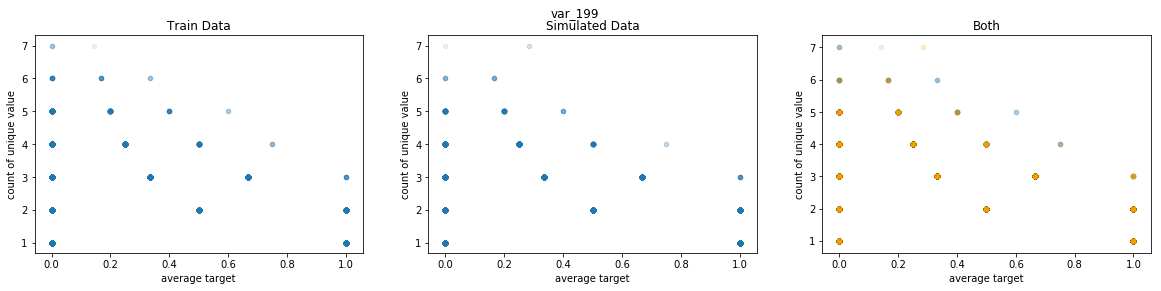

In [2]:
for var in ['var_{}'.format(x) for x in range(0, 200)]:
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 4))
    train_df.groupby(var)['target'].agg(['count','mean']).sort_values('count') \
        .plot(kind='scatter', x='mean', y='count', ax=ax1, alpha=0.1, title='Train Data')
    train_df['random_{}'.format(var)] = np.random.normal(train_df[var].mean(), train_df[var].std(), 200000).round(4)
    train_df.groupby('random_{}'.format(var))['target'].agg(['count','mean']).sort_values('count') \
        .plot(kind='scatter', x='mean', y='count', ax=ax2, alpha=0.1, title='Simulated Data')
    # Both together
    train_df.groupby(var)['target'].agg(['count','mean']).sort_values('count') \
        .plot(kind='scatter', x='mean', y='count', ax=ax3, alpha=0.1)
    train_df.groupby('random_{}'.format(var))['target'].agg(['count','mean']).sort_values('count') \
        .plot(kind='scatter', x='mean', y='count', ax=ax3, alpha=0.1, color='orange', title='Both')
    ax1.set_xlabel('average target')
    ax2.set_xlabel('average target')
    ax3.set_xlabel('average target')
    ax1.set_ylabel('count of unique value')
    ax2.set_ylabel('count of unique value')
    ax3.set_ylabel('count of unique value')
    fig.suptitle(var)
    plt.show()

## Interactive Version of the Plot for var_12
Var 12 looks strange so I wanted to interact with the points that don't appear in the simulated data

In [3]:
import bokeh
from bokeh.io import show, output_notebook
from bokeh.plotting import figure, ColumnDataSource
from bokeh.models import HoverTool
from collections import OrderedDict

output_notebook()

var = 'var_126'
train_df['random_{}'.format(var)] = np.random.normal(train_df[var].mean(), train_df[var].std(), 200000).round(4)

TOOLS="crosshair,pan,wheel_zoom,box_zoom,reset,hover,previewsave"
p = figure(tools=TOOLS, title=var)
source = ColumnDataSource(data=dict(x=train_df.groupby(var)['target'].mean(),
                 y=train_df.groupby(var)['target'].count(),
                 size=(train_df.groupby(var)['target'].mean().index / 2),
                 label=train_df.groupby(var)['target'].mean().index * 10000))

source2 = ColumnDataSource(data=dict(x=train_df.groupby('random_{}'.format(var))['target'].mean(),
                 y=train_df.groupby('random_{}'.format(var))['target'].count(),
                 size=(train_df.groupby('random_{}'.format(var))['target'].mean().index / 2),
                 label=train_df.groupby('random_{}'.format(var))['target'].mean().index))

p.circle(x='x', y='y', size='size', source=source)
p.circle(x='x', y='y', size='size', source=source2, color='orange')

hover =p.select(dict(type=HoverTool))
hover.tooltips = OrderedDict([
    ("index", "$index"),
    ("(xx,yy)", "(@x, @y)"),
    ("label", "@label"),
])
show(p)

Loading BokehJS ...

# Create Feature that is the difference in unique counts vs normal distribution unique counts

In [4]:
# Reload Train and Test
train_df = pd.read_csv('../input/train.csv')
test_df = pd.read_csv('../input/test.csv')

In [5]:
def transform(df, var='var_12'):
    df['random_{}'.format(var)] = np.random.normal(df[var].mean(), df[var].std(), 200000).round(4)
    var_counts = pd.DataFrame(df.groupby(var)['ID_code'].count()).reset_index()
    var_counts_random = pd.DataFrame(df.groupby('random_{}'.format(var))['ID_code'].count()).reset_index()
    merged_counts = pd.merge(var_counts, var_counts_random, left_on=var, right_on='random_{}'.format(var))
    merged_counts['diff'] = merged_counts['ID_code_x'] - merged_counts['ID_code_y']
    df['{}_diff_normal_dist'.format(var)] = df.merge(merged_counts[[var,'diff']], how='left')['diff']
    df = df.drop('random_{}'.format(var), axis=1)
    return df

In [6]:
# Loop and add features
for var in tqdm(['var_{}'.format(x) for x in range(0, 200)]):
    train_df = transform(train_df, var=var)
    test_df = transform(test_df, var=var)

100%|██████████| 200/200 [19:03<00:00,  7.25s/it]


In [7]:
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import roc_auc_score
import lightgbm as lgb

random_state = 42
params = {
    "objective" : "binary", "metric" : "auc", "boosting": 'gbdt', "max_depth" : -1, "num_leaves" : 13,
    "learning_rate" : 0.01, "bagging_freq": 5, "bagging_fraction" : 0.4, "feature_fraction" : 0.05,
    "min_data_in_leaf": 80, "min_sum_heassian_in_leaf": 10, "tree_learner": "serial", "boost_from_average": "false",
    "bagging_seed" : random_state, "verbosity" : 1, "seed": random_state
}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
oof = train_df[['ID_code', 'target']].copy()
oof['predict'] = 0
predictions = test_df[['ID_code']].copy()
val_aucs = []

features = [col for col in train_df.columns if col not in ['target', 'ID_code']]
X_test = test_df[features].values

for fold, (trn_idx, val_idx) in enumerate(skf.split(train_df, train_df['target'])):
    X_train, y_train = train_df.iloc[trn_idx][features], train_df.iloc[trn_idx]['target']
    X_valid, y_valid = train_df.iloc[val_idx][features], train_df.iloc[val_idx]['target']
    
    N = 3
    p_valid,yp = 0,0
    trn_data = lgb.Dataset(X_train, label=y_train)
    val_data = lgb.Dataset(X_valid, label=y_valid)
    evals_result = {}
    lgb_clf = lgb.train(params,
                        trn_data,
                        100000,
                        valid_sets = [trn_data, val_data],
                        early_stopping_rounds=1000,
                        verbose_eval = 500,
                        evals_result=evals_result)
    p_valid += lgb_clf.predict(X_valid)
    yp += lgb_clf.predict(X_test)

    oof['predict'][val_idx] = p_valid
    val_score = roc_auc_score(y_valid, p_valid)
    val_aucs.append(val_score)
    predictions['fold{}'.format(fold+1)] = yp
    
mean_auc = np.mean(val_aucs)
std_auc = np.std(val_aucs)
all_auc = roc_auc_score(oof['target'], oof['predict'])
print("Mean auc: %.9f, std: %.9f. All auc: %.9f." % (mean_auc, std_auc, all_auc))

predictions['target'] = np.mean(predictions[[col for col in predictions.columns if col not in ['ID_code', 'target']]].values, axis=1)
submission = pd.DataFrame({"ID_code":test_df["ID_code"].values})
submission["target"] = predictions['target']
submission.to_csv("lgb_submission2.csv", index=False)

Training until validation scores don't improve for 1000 rounds.
[500]	training's auc: 0.892278	valid_1's auc: 0.874709
[1000]	training's auc: 0.901468	valid_1's auc: 0.881739
[1500]	training's auc: 0.907733	valid_1's auc: 0.886139
[2000]	training's auc: 0.912933	valid_1's auc: 0.889312
[2500]	training's auc: 0.917857	valid_1's auc: 0.891915
[3000]	training's auc: 0.922152	valid_1's auc: 0.894057
[3500]	training's auc: 0.925899	valid_1's auc: 0.895294
[4000]	training's auc: 0.929321	valid_1's auc: 0.89625
[4500]	training's auc: 0.932456	valid_1's auc: 0.897015
[5000]	training's auc: 0.935416	valid_1's auc: 0.897702
[5500]	training's auc: 0.938245	valid_1's auc: 0.898211
[6000]	training's auc: 0.940879	valid_1's auc: 0.898391
[6500]	training's auc: 0.943346	valid_1's auc: 0.89861
[7000]	training's auc: 0.945791	valid_1's auc: 0.898689
[7500]	training's auc: 0.94814	valid_1's auc: 0.898857
[8000]	training's auc: 0.950409	valid_1's auc: 0.898937
[8500]	training's auc: 0.952575	valid_1's au

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Training until validation scores don't improve for 1000 rounds.
[500]	training's auc: 0.891678	valid_1's auc: 0.876499
[1000]	training's auc: 0.901089	valid_1's auc: 0.884345
[1500]	training's auc: 0.907507	valid_1's auc: 0.888837
[2000]	training's auc: 0.912671	valid_1's auc: 0.891835
[2500]	training's auc: 0.917434	valid_1's auc: 0.894086
[3000]	training's auc: 0.921689	valid_1's auc: 0.895649
[3500]	training's auc: 0.925549	valid_1's auc: 0.896829
[4000]	training's auc: 0.928992	valid_1's auc: 0.897724
[4500]	training's auc: 0.932108	valid_1's auc: 0.898345
[5000]	training's auc: 0.935033	valid_1's auc: 0.898903
[5500]	training's auc: 0.937802	valid_1's auc: 0.899284
[6000]	training's auc: 0.94042	valid_1's auc: 0.899639
[6500]	training's auc: 0.942949	valid_1's auc: 0.899771
[7000]	training's auc: 0.945394	valid_1's auc: 0.899829
[7500]	training's auc: 0.947715	valid_1's auc: 0.899905
[8000]	training's auc: 0.949999	valid_1's auc: 0.900071
[8500]	training's auc: 0.952147	valid_1's 

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Training until validation scores don't improve for 1000 rounds.
[500]	training's auc: 0.890792	valid_1's auc: 0.880359
[1000]	training's auc: 0.900078	valid_1's auc: 0.887889
[1500]	training's auc: 0.906438	valid_1's auc: 0.891726
[2000]	training's auc: 0.911565	valid_1's auc: 0.895276
[2500]	training's auc: 0.916447	valid_1's auc: 0.897912
[3000]	training's auc: 0.92066	valid_1's auc: 0.900055
[3500]	training's auc: 0.924413	valid_1's auc: 0.901748
[4000]	training's auc: 0.927919	valid_1's auc: 0.90304
[4500]	training's auc: 0.931148	valid_1's auc: 0.903821
[5000]	training's auc: 0.934118	valid_1's auc: 0.904392
[5500]	training's auc: 0.937003	valid_1's auc: 0.90503
[6000]	training's auc: 0.939664	valid_1's auc: 0.905263
[6500]	training's auc: 0.942173	valid_1's auc: 0.905508
[7000]	training's auc: 0.944686	valid_1's auc: 0.905658
[7500]	training's auc: 0.947078	valid_1's auc: 0.905769
[8000]	training's auc: 0.949405	valid_1's auc: 0.905824
[8500]	training's auc: 0.951631	valid_1's au

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Training until validation scores don't improve for 1000 rounds.
[500]	training's auc: 0.89095	valid_1's auc: 0.870997
[1000]	training's auc: 0.900949	valid_1's auc: 0.879285
[1500]	training's auc: 0.90752	valid_1's auc: 0.884365
[2000]	training's auc: 0.912888	valid_1's auc: 0.887489
[2500]	training's auc: 0.91791	valid_1's auc: 0.89038
[3000]	training's auc: 0.922147	valid_1's auc: 0.892596
[3500]	training's auc: 0.925998	valid_1's auc: 0.894043
[4000]	training's auc: 0.929505	valid_1's auc: 0.895391
[4500]	training's auc: 0.932625	valid_1's auc: 0.896203
[5000]	training's auc: 0.935474	valid_1's auc: 0.896817
[5500]	training's auc: 0.938245	valid_1's auc: 0.897542
[6000]	training's auc: 0.940847	valid_1's auc: 0.897856
[6500]	training's auc: 0.943343	valid_1's auc: 0.898164
[7000]	training's auc: 0.945775	valid_1's auc: 0.89843
[7500]	training's auc: 0.948115	valid_1's auc: 0.898664
[8000]	training's auc: 0.950342	valid_1's auc: 0.898811
[8500]	training's auc: 0.952531	valid_1's auc:

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Training until validation scores don't improve for 1000 rounds.
[500]	training's auc: 0.893788	valid_1's auc: 0.869897
[1000]	training's auc: 0.902298	valid_1's auc: 0.877701
[1500]	training's auc: 0.908636	valid_1's auc: 0.881988
[2000]	training's auc: 0.913837	valid_1's auc: 0.885429
[2500]	training's auc: 0.918503	valid_1's auc: 0.888252
[3000]	training's auc: 0.922721	valid_1's auc: 0.890325
[3500]	training's auc: 0.926416	valid_1's auc: 0.891796
[4000]	training's auc: 0.92975	valid_1's auc: 0.89316
[4500]	training's auc: 0.932829	valid_1's auc: 0.894017
[5000]	training's auc: 0.935808	valid_1's auc: 0.894661
[5500]	training's auc: 0.938668	valid_1's auc: 0.895198
[6000]	training's auc: 0.94128	valid_1's auc: 0.895561
[6500]	training's auc: 0.943779	valid_1's auc: 0.89584
[7000]	training's auc: 0.946178	valid_1's auc: 0.895939
[7500]	training's auc: 0.948541	valid_1's auc: 0.896063
[8000]	training's auc: 0.950801	valid_1's auc: 0.89617
[8500]	training's auc: 0.952942	valid_1's auc:

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Mean auc: 0.900118759, std: 0.003203794. All auc: 0.900060441.
